<a href="https://colab.research.google.com/github/AnnabelHall/QCES_LNM/blob/main/Project2_transport.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/johnryantaylor/QCES/blob/main/Project2_transport.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 2: Tracer transport

A critical aspect of understanding climate and environmental systems is describing the movement of substances. This could include pollution or water vapor in the atmosphere, salt in an estuary, or chemicals in a river. We often model the transport of these substances using an advection/diffusion equation for the concentration of the substance. In this context, we sometimes refer to the concentration field as a `tracer' since it helps us track the movement of individual molecules. We can also use this framework to describe the transport of heat, although in this case the tracer field (temperature or heat content) tracks the movement of thermal energy.

In this project we will use Dedalus to solve advection diffusion equations to describe the vertical distribution of heat in the ocean and the concentration of pollution in a river.

Student tasks are in [Section 1.4](#section1pt4), [Section 1.6](#section1pt6), and [Section 2.3](#section2pt3)

## Setup
If you are using Google colab, run the script below to install Dedalus

In [1]:
# Set environment variables for best performance
%env OMP_NUM_THREADS=1
%env NUMEXPR_MAX_THREADS=1

# Minimize logging output
import logging
logging.disable(logging.DEBUG)

# Check if running on google colab
import os
using_google_colab = bool(os.getenv("COLAB_RELEASE_TAG"))

# Check for Dedalus
try:
    import dedalus.public as de
    print("Dedalus already installed :)")
except:
    print("Dedalus not installed yet.")
    if using_google_colab:
        print("Installing for Google Colab.")
        print()
        # Step 1: Install FFTW
        !apt-get install libfftw3-dev
        !apt-get install libfftw3-mpi-dev
        # Step 2: Set paths for Dedalus installation
        import os
        os.environ['MPI_INCLUDE_PATH'] = "/usr/lib/x86_64-linux-gnu/openmpi/include"
        os.environ['MPI_LIBRARY_PATH'] = "/usr/lib/x86_64-linux-gnu"
        os.environ['FFTW_INCLUDE_PATH'] = "/usr/include"
        os.environ['FFTW_LIBRARY_PATH'] = "/usr/lib/x86_64-linux-gnu"
        # Step 3: Install Dedalus using pip
        !pip3 install cython "mpi4py<4.0" numpy setuptools wheel
        !CC=mpicc pip3 install --no-cache --no-build-isolation http://github.com/dedalusproject/dedalus/zipball/master/
        !pip3 install -q ipympl
        # Step 4: Check installation
        print()
        try:
            import dedalus.public as de
            print("Dedalus successfully installed :)")
        except:
            print("Error installing Dedalus :(")
            raise
    else:
        print("See website for installation instructions:")
        print("https://dedalus-project.readthedocs.io/en/latest/pages/installation.html")

# Setup interactive matplotlib
if using_google_colab:
    from google.colab import output
    output.enable_custom_widget_manager()

env: OMP_NUM_THREADS=1
env: NUMEXPR_MAX_THREADS=1
Dedalus not installed yet.
Installing for Google Colab.

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libfftw3-bin libfftw3-double3 libfftw3-long3 libfftw3-quad3 libfftw3-single3
Suggested packages:
  libfftw3-doc
The following NEW packages will be installed:
  libfftw3-bin libfftw3-dev libfftw3-double3 libfftw3-long3 libfftw3-quad3 libfftw3-single3
0 upgraded, 6 newly installed, 0 to remove and 49 not upgraded.
Need to get 4,654 kB of archives.
After this operation, 24.7 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libfftw3-double3 amd64 3.3.8-2ubuntu8 [770 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 libfftw3-long3 amd64 3.3.8-2ubuntu8 [335 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/main amd64 libfftw3-quad3 amd64 3.3.8-2ubuntu8 [614 kB]
Get:4 http://archiv

## 1. Thermal structure in the ocean

Most of the ocean has a stable thermal stratification with warm water at the surface and cold water in the abyss (exceptions occur in salt-stratified waters like the Arctic Ocean). Since the ocean is a massive thermal reservoir, understanding the distribution of this heat is important to quantifying the ocean's role in a changing climate. The structure of the temperature field can also inform us about the circulation in the ocean interior.


### 1.1 Measured temperature profile

The code below plots a sample temperature profile obtained off the coast of California. The data was obtained by digitizing Figure 3 in Munk, 1966.

Text(0, 0.5, 'Depth (m)')

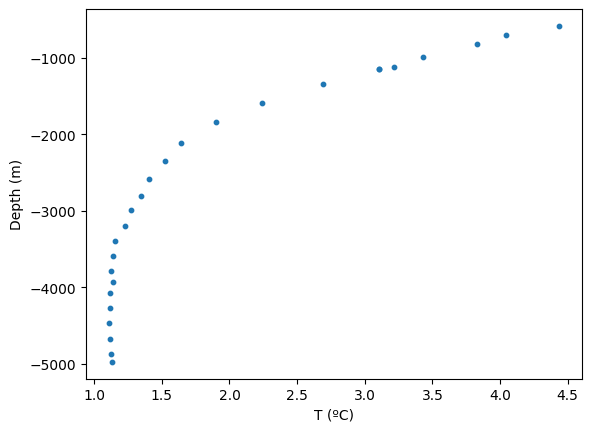

In [2]:
import matplotlib.pyplot as plt

# Temperature measurements extracted from Figure 3 in Munk, 1966
CTD_T = [1.1296296296296295, 1.122004357298475, 1.1143790849673203, 1.1067538126361656, 1.1143790849673203, 1.1143790849673203, 1.1372549019607843, 1.122004357298475, 1.1372549019607843, 1.1525054466230937, 1.2287581699346406, 1.2745098039215685, 1.343137254901961, 1.4041394335511983, 1.526143790849673, 1.6405228758169934, 1.8997821350762527, 2.242919389978214, 2.69281045751634, 3.104575163398693, 3.104575163398693, 3.218954248366013, 3.4324618736383443, 3.8289760348583877, 4.042483660130719, 4.438997821350762]
CTD_z = [-4976.958525345623, -4869.431643625192, -4677.419354838709, -4470.046082949309, -4270.353302611367, -4070.6605222734256, -3932.411674347158, -3786.4823348694317, -3586.78955453149, -3394.7772657450078, -3195.084485407066, -2995.3917050691243, -2803.379416282642, -2580.6451612903224, -2350.230414746544, -2112.1351766513058, -1843.3179723502303, -1597.5422427035332, -1344.0860215053763, -1144.3932411674346, -1144.3932411674346, -1121.351766513057, -990.7834101382491, -821.8125960061443, -698.9247311827958, -583.7173579109067]

plt.scatter(CTD_T,CTD_z,s=10)
plt.xlabel('T (ºC)')
plt.ylabel('Depth (m)')


### 1.2 Abyssal recipes

Munk (1966) proposed that the thermal structure of the ocean interior is set by a balance between upwelling and diffusion. In this view, cold waters sink near the poles and spread across the seafloor before slowly rising through the ocean interior. If we assume, as Munk did, that the water upwells uniformly across the globe, the upwelling speed is approximately $10^{-7}$ m/s. This is far too small to directly measure, but it is large enough to have a major impact on the distribution of tracers. Since light can only penetrate through the top ~100m of ocean, we can ignore solar heating, except in that it sets the temperature near the ocean surface.

### 1.3 Steady advection/diffusion equation

Dedalus can solve differential equations in various forms. In addition to time-dependent initial value problems (IVPs), Dedalus can solve linear and nonlinear boundary value problems. The code below uses Dedalus to solve a linear boundary value problem (IVBP) for the steady state advection/diffusion equation.

Here, the top and bottom temperature are set from the measured profile and these are used as boundary conditions. The vertical (upwelling) velocity is set to $10^{-7} m/s$, and the diffusivity is set to $10^{-7}$ $m^2/s$, to approximate the molecular diffusivity of heat in seawater.

INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.1e+01/s


2024-12-20 00:43:43,658 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.1e+01/s


Text(0, 0.5, 'Depth (m)')

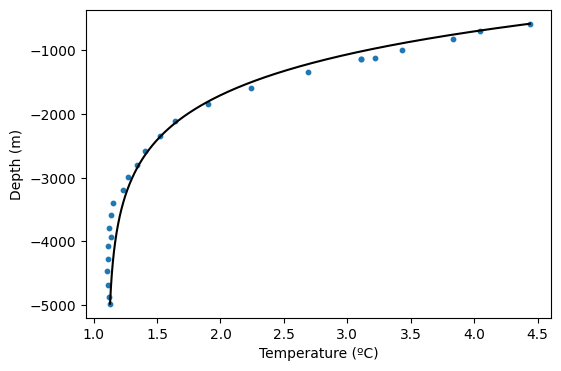

In [3]:
"""
Dedalus script to solve the steady advection/diffusion equation
"""

import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as d3
import logging
logger = logging.getLogger(__name__)

# Set various parameters. Note that the depth and the top and bottom temperature
# are taken from the CTD data in the code cell above. That cell must be run first to define CTD_T and CTD_z.
z_surface = CTD_z[-1]
z_bottom = CTD_z[0]
T_surface = CTD_T[-1]
T_bottom = CTD_T[0]
Nz = 1000

# Set the upwelling velocity
w = 1e-7 # m/s
# Set the diffusivity
kappa=8.5e-5 # m^2/s

# Bases
zcoord = d3.Coordinate('z')
dist = d3.Distributor(zcoord, dtype=np.float64)
zbasis = d3.Chebyshev(zcoord, size=Nz, bounds=(z_bottom, z_surface))
z = dist.local_grid(zbasis)

# Fields
T = dist.Field(name='T', bases=zbasis)

# Add two tau variables to allow us to apply two boundary conditions
tau_1 = dist.Field(name='tau_1')
tau_2 = dist.Field(name='tau_2')
lift_basis = zbasis.derivative_basis(1)
lift = lambda A: d3.Lift(A, lift_basis, -1)

# Substitutions
dz = lambda A: d3.Differentiate(A, zcoord)
Tz = dz(T) + lift(tau_1)
Tzz = dz(Tz) + lift(tau_2)

# Problem
problem = d3.LBVP([T, tau_1, tau_2], namespace=locals())
problem.add_equation("w*Tz - kappa*Tzz = 0")
problem.add_equation("T(z=z_surface) = T_surface")
problem.add_equation("T(z=z_bottom) = T_bottom")

# Solver
solver = problem.build_solver()
solver.solve()

# Plot
plt.figure(figsize=(6, 4))
Tg=T['g']
plt.scatter(CTD_T,CTD_z,s=10)
plt.plot(Tg,z,'k')
plt.xlabel('Temperature (ºC)')
plt.ylabel('Depth (m)')

### 1.4 Student investigation
<a id='section1pt4'></a>
Note that the profile above is not a good fit to the data. This implies that molecular diffusion isn't sufficient to transport heat down from the surface and stop the ocean from filling up with cold, dense water.

Munk (1966) proposed that small-scale turbulence in the ocean interior results in a diffusivity that is orders of magnitude larger than the molecular value. Find a diffusivity that gives a good match with the data and test it in the Dedalus script above. Comment on the ability of this model (steady advection/diffusion) to fit the data.

**My answer**

Keeping the value of w the same as 1e$^{-7}$. With some different attempts, I chose a $\kappa$ value of 8.5e$^{-5}$. This fits the model imperfectly, however follows the graph as a whole. We see the needed 'slowing growth' form, with gradient changing from initially high and then tending towards horizontal. It fails at points as the curve has its major curve point at a higher value of T and D. Nonetheless, this proves to be a good approximation overall.

This diffusivity is approximately 1000 times greater than the original set value of 1e$^{-7}$.

### 1.5 Turning ocean mixing upside down

Decades of research to measure the turbulent diffusivity in the ocean consistently found values much smaller than the one predicted by Munk (1966). Specifically, while larger values of the turbulent diffusivity were found near the bottom of the ocean over rough topographic features, the values in the upper ocean were about 10x smaller than the values predicted by Munk. 50 years after Munk's seminal paper, Ferrari et al. (2016) proposed that a depth-dependent turbulent diffusivity could be balanced by <em>downwelling</em>, with negative vertical velocities in the ocean interior. In this theory, the overturning circulation is upwelling in thin boundary layers along the sloping sides of the ocean basins.

When the diffusivity, $\kappa$, is a function of $z$, the steady advection/diffusion equation can be written

$$ w\frac{dT}{dz} = \frac{d}{dz}\left(\kappa(z) \frac{dT}{dz}\right)$$

The Dedalus script below solves the previous equation and again compares the results with the observed temperature profile. For the depth-dependent diffusivity, $\kappa(z)$, we take

$$ \kappa(z)=\kappa_{bg} + (\kappa_0-\kappa_{bg})e^{-(z+D)/l} $$

using the form from Rogers et al., 2023, where $\kappa_{bg}=1\times 10^{-5} m^2/s$ is the background diffusivity characteristic of the upper water column, $\kappa_0=8.6\times 10^{-4} m^2/s$ characterizes the enhanced mixing near the bottom of the ocean, and $l=667m$ is an exponential decay scale. In the script below, we start with $w=0$.

INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 2.0e+00/s


2024-12-20 00:43:44,723 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 2.0e+00/s


Text(0, 0.5, 'Depth (m)')

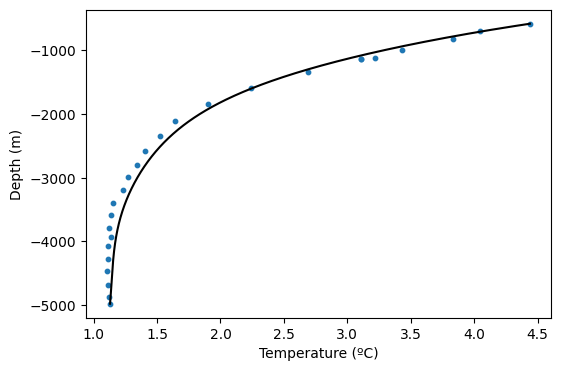

In [4]:
"""
Dedalus script to solve the steady advection/diffusion equation
with a spatially-variable diffusivity
"""

import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as d3
import logging
logger = logging.getLogger(__name__)

# Set various parameters. Note that the depth and the top and bottom temperature
# are taken from the CTD data in the code cell above. That cell must be run first to define CTD_T and CTD_z.
z_surface = CTD_z[-1]
z_bottom = CTD_z[0]
T_surface = CTD_T[-1]
T_bottom = CTD_T[0]
Nz = 1000

# Set the vertical velocity
w = 1e-8 # m/s

# Bases
zcoord = d3.Coordinate('z')
dist = d3.Distributor(zcoord, dtype=np.float64)
zbasis = d3.Chebyshev(zcoord, size=Nz, bounds=(z_bottom, z_surface))
z = dist.local_grid(zbasis)

# Fields
T = dist.Field(name='T', bases=zbasis)
kappa = dist.Field(name='kappa', bases=zbasis)
# Set the diffusivity
# Below is the diffusivity profile from Rogers et al., 2023
kappa['g']=1e-5 + (8.6e-5-1e-5)*np.exp((-5e3-z)/667) # m^2/s

# Add two tau variables to allow us to apply two boundary conditions
tau_1 = dist.Field(name='tau_1')
tau_2 = dist.Field(name='tau_2')
lift_basis = zbasis.derivative_basis(1)
lift = lambda A: d3.Lift(A, lift_basis, -1)

# Substitutions
dz = lambda A: d3.Differentiate(A, zcoord)
Tz = dz(T) + lift(tau_1)
Tzz = dz(Tz) + lift(tau_2)

# Problem
problem = d3.LBVP([T, tau_1, tau_2], namespace=locals())
problem.add_equation("w*Tz - dz(kappa*Tz) + lift(tau_2) = 0")
problem.add_equation("T(z=z_surface) = T_surface")
problem.add_equation("T(z=z_bottom) = T_bottom")

# Solver
solver = problem.build_solver()
solver.solve()

# Plot
plt.figure(figsize=(6, 4))
Tg=T['g']
plt.scatter(CTD_T,CTD_z,s=10)
plt.plot(Tg,z,'k')
plt.xlabel('Temperature (ºC)')
plt.ylabel('Depth (m)')

### 1.6 Student investigation
<a id='section1pt6'></a>
Note from the results of the script above that the density profile is reasonable, even though $w=0$. In the box below, comment on the balance in this case and what this implies about the diffusive heat flux.

Next, find a vertical velocity that produces a better agreement with the observations and report it below. Then, try varying the details of the $\kappa(z)$ profile. How sensitive is the optimal $w$ to your choice of $\kappa(z)$? What does this imply about the circulation in the ocean interior if $\kappa(z)$ varies between regions of smooth and rough topography?

(As an aside, note that the requied vertical velocity is much smaller than the one used by Munk (1966). This implies that the dense, cold water that sinks at the poles must rise elsewhere. Ferrari et al. (2016) proposed that this occurs in boundary layers near the seafloor.)

**My Answer**

A value of 0 for $w$ means that there is no vertical velocity, and therefore all changes in temperature with depth are due to turbulence and, on a small level, molecular diffusion. This model fit the data fairly well, although will overestimate temperature at a given depth by up to 0.5 degrees.

First, we try varying the value of w(z). A value of w = 8e-9 m/s produces an excellent fit. At worst, it over/underestimates the T by ~0.1 degrees.

Now, we try different values within the $\kappa(z)$ expression and see how they affect optimal $w$.

| state | $\kappa_{bg}$ | $\kappa_0$ | Optimal $w$ |comment|
| ------|---------------|------------|--------------|-------|
|Original| 1e-5 | 8.6e-4 | 8e-9 | Fits the data well as described above |
| 1 | 1e-4 | 8.6e-4 | 1e-7 | Increasing the value of $\kappa_{bg}$ requires a much higher value of $w$. This can be rationalised as a greater backgroud diffusivity requires more upwelling to balance it.|
| 2 | 1e-5 | 8.6e-5 |1e-8 |  Decreasing the value of $\kappa_0$ also requires a greater value of $w$. With less turbulence at depth, there is less of a difference between deep and surface $\kappa$. Therefore, greater vertical velocity is needed to gain the needed T curve.  |

The interesting variation between $\kappa$ and $w$ can be attributed to the complex relation between them. This can be seen in the graph below.



Text(0, 0.5, 'Depth (m)')

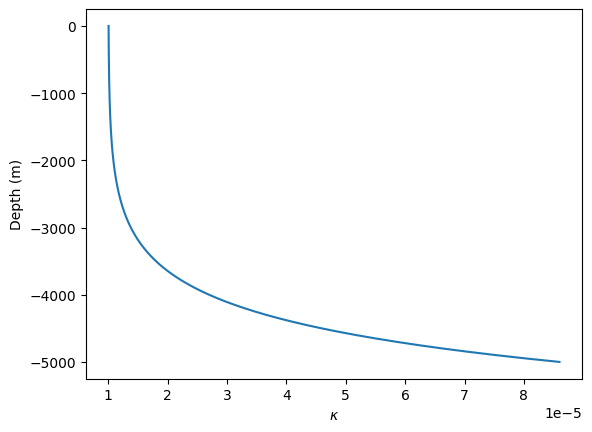

In [5]:
def kappa_time(z):
  kappa_nums=1e-5 + (8.6e-5-1e-5)*np.exp((-5e3-z)/667) # m^2/s
  return kappa_nums

depths = np.linspace(-5000,0,1000)

plt.plot(kappa_time(depths),depths)

plt.xlabel('$\kappa$')
plt.ylabel('Depth (m)')


## 2. Transport of pollution in a river

Advection/diffusion equations are a common way to model the material transport in many physical systems. In this section we will model the transport and dilution of a pollutants added to a river.

For simplicity, we will model the river as a rectangular channel, and we will neglect depth variations. Let $x$ be the coordinate along the length of the river, and $y$ be the cross-stream coordinate. We will model the river current as

$$ u(y) = U_0\left(1-\frac{(y-w/2)^2}{(w/2)^2}\right) $$

where $w$ is the width of the river and $U_0$ is the maximum current speed which occurs at the center of the river (the $y$-coordinate will run from 0 to $w$).

Since we want to know how the pollution levels vary in time, we will solve the time-dependent advection/diffusion equation. We will model the addition of pollution by adding a time-dependent source term to the right hand side of the equation governing pollutant concentration:

$$ \frac{\partial c}{\partial t} + u(y)\frac{\partial c}{\partial x} = \kappa \nabla^2 c + S(x,y) $$

where $\nabla^2=(\partial_x^2 + \partial_y^2)$ is the Laplacian operator for diffusion in 2D Cartesian coordinates, and $S$ is the source term.

### 2.1 Dedalus script

The script below solves the time-dependent advection/diffusion equation with a source term.

In [6]:
"""
Script to solve the time-dependent advection/diffusion equation
"""

import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as dedalus
import logging
logger = logging.getLogger(__name__)

# Set parameters
U0 = 0.1 # maximum current speed in m/s       - CHANGE THIS
w = 10 # width of the river in m
L = 50 # length of the river section to simulate
kappa = 1e-2 # diffusivity in m^2/s           - CHANGE THIS
S0 = 1 # amplitude of the pollution source term
S_w = 1 # width of the source term in m
S_x = 10 # center of the forcing in x
S_y = 0 # center of the forcing in y
S_t = 1 # forcing timescale

# Numerical parameters
Nx = 256 # number of gridoints in x
Ny = 32 # number of gridpoints in y
stop_sim_time=1500 # end time in seconds
timestep = (L/Nx)/U0 # timestep in seconds, calculated from the CFL number

import numpy as np
import dedalus.public as dedalus
import logging
logger = logging.getLogger(__name__)

# Bases and coordinates
coords = dedalus.CartesianCoordinates('x', 'y')
dist = dedalus.Distributor(coords, dtype=np.float64)
xbasis = dedalus.RealFourier(coords['x'], size=Nx, bounds=(0, L), dealias=3/2)
ybasis = dedalus.ChebyshevT(coords['y'], size=Ny, bounds=(0, w), dealias=3/2)
x, y = dist.local_grids(xbasis, ybasis)
ex, ey = coords.unit_vector_fields(dist) # x and y unit vectors

# Fields
c = dist.Field(name='b', bases=(xbasis,ybasis))
u = dist.Field(name='u', bases=(xbasis,ybasis))
tau_1 = dist.Field(name='tau_1', bases=xbasis)
tau_2 = dist.Field(name='tau_2', bases=xbasis)

# Specify the velocity field
u['g'] = U0 * (1- (y - w/2)**2.0/(w/2)**2.0) # parabolic velocity profile

# Substitutions
lift_basis = ybasis.derivative_basis(1)
lift = lambda A: dedalus.Lift(A, lift_basis, -1)
grad_c = dedalus.grad(c) + ey*lift(tau_1)
dx = lambda A: dedalus.Differentiate(A, coords['x'])

S = dist.Field(name='u', bases=(xbasis,ybasis))
S['g'] = S0*np.exp(-(x-S_x)**2.0/S_w**2.0-(y-S_y)**2.0/S_w**2.0)

# Problem
problem = dedalus.IVP([c, tau_1, tau_2], namespace=locals())
problem.add_equation("dt(c) + u*dx(c) - kappa*div(grad_c) + lift(tau_2) = S/S_t")
problem.add_equation("c(y=0) = 0")
problem.add_equation("c(y=w) = 0")

# Now, set the solver
solver = problem.build_solver(dedalus.RK222)
solver.stop_sim_time = stop_sim_time

# Create an array to periodically save the concentration field for plotting later
c.change_scales(1)
c_save = [np.copy(c['g'])];

t_save = [solver.sim_time]; # Save the initial condition and the initial time
# Main loop
try:
    logger.info('Starting main loop')
    while solver.proceed:
        solver.step(timestep)
        if (solver.iteration-1) % 10 == 0:
            logger.info('Iteration=%i, Time=%e, dt=%e' %(solver.iteration, solver.sim_time, timestep))
            c.change_scales(1)
            c_save.append(np.copy(c['g']))
            t_save.append(solver.sim_time)
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()

# Convert the variables to numpy arrays for allow array slicing
c_save = np.array(c_save)

INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.5e+00/s


2024-12-20 00:43:45,898 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.5e+00/s


INFO:__main__:Starting main loop


2024-12-20 00:43:45,907 __main__ 0/1 INFO :: Starting main loop


INFO:__main__:Iteration=1, Time=1.953125e+00, dt=1.953125e+00


2024-12-20 00:43:47,070 __main__ 0/1 INFO :: Iteration=1, Time=1.953125e+00, dt=1.953125e+00


INFO:__main__:Iteration=11, Time=2.148438e+01, dt=1.953125e+00


2024-12-20 00:43:47,127 __main__ 0/1 INFO :: Iteration=11, Time=2.148438e+01, dt=1.953125e+00


INFO:__main__:Iteration=21, Time=4.101562e+01, dt=1.953125e+00


2024-12-20 00:43:47,181 __main__ 0/1 INFO :: Iteration=21, Time=4.101562e+01, dt=1.953125e+00


INFO:__main__:Iteration=31, Time=6.054688e+01, dt=1.953125e+00


2024-12-20 00:43:47,242 __main__ 0/1 INFO :: Iteration=31, Time=6.054688e+01, dt=1.953125e+00


INFO:__main__:Iteration=41, Time=8.007812e+01, dt=1.953125e+00


2024-12-20 00:43:47,293 __main__ 0/1 INFO :: Iteration=41, Time=8.007812e+01, dt=1.953125e+00


INFO:__main__:Iteration=51, Time=9.960938e+01, dt=1.953125e+00


2024-12-20 00:43:47,343 __main__ 0/1 INFO :: Iteration=51, Time=9.960938e+01, dt=1.953125e+00


INFO:__main__:Iteration=61, Time=1.191406e+02, dt=1.953125e+00


2024-12-20 00:43:47,390 __main__ 0/1 INFO :: Iteration=61, Time=1.191406e+02, dt=1.953125e+00


INFO:__main__:Iteration=71, Time=1.386719e+02, dt=1.953125e+00


2024-12-20 00:43:47,432 __main__ 0/1 INFO :: Iteration=71, Time=1.386719e+02, dt=1.953125e+00


INFO:__main__:Iteration=81, Time=1.582031e+02, dt=1.953125e+00


2024-12-20 00:43:47,480 __main__ 0/1 INFO :: Iteration=81, Time=1.582031e+02, dt=1.953125e+00


INFO:__main__:Iteration=91, Time=1.777344e+02, dt=1.953125e+00


2024-12-20 00:43:47,524 __main__ 0/1 INFO :: Iteration=91, Time=1.777344e+02, dt=1.953125e+00


INFO:__main__:Iteration=101, Time=1.972656e+02, dt=1.953125e+00


2024-12-20 00:43:47,576 __main__ 0/1 INFO :: Iteration=101, Time=1.972656e+02, dt=1.953125e+00


INFO:__main__:Iteration=111, Time=2.167969e+02, dt=1.953125e+00


2024-12-20 00:43:47,655 __main__ 0/1 INFO :: Iteration=111, Time=2.167969e+02, dt=1.953125e+00


INFO:__main__:Iteration=121, Time=2.363281e+02, dt=1.953125e+00


2024-12-20 00:43:47,711 __main__ 0/1 INFO :: Iteration=121, Time=2.363281e+02, dt=1.953125e+00


INFO:__main__:Iteration=131, Time=2.558594e+02, dt=1.953125e+00


2024-12-20 00:43:47,764 __main__ 0/1 INFO :: Iteration=131, Time=2.558594e+02, dt=1.953125e+00


INFO:__main__:Iteration=141, Time=2.753906e+02, dt=1.953125e+00


2024-12-20 00:43:47,829 __main__ 0/1 INFO :: Iteration=141, Time=2.753906e+02, dt=1.953125e+00


INFO:__main__:Iteration=151, Time=2.949219e+02, dt=1.953125e+00


2024-12-20 00:43:47,887 __main__ 0/1 INFO :: Iteration=151, Time=2.949219e+02, dt=1.953125e+00


INFO:__main__:Iteration=161, Time=3.144531e+02, dt=1.953125e+00


2024-12-20 00:43:47,982 __main__ 0/1 INFO :: Iteration=161, Time=3.144531e+02, dt=1.953125e+00


INFO:__main__:Iteration=171, Time=3.339844e+02, dt=1.953125e+00


2024-12-20 00:43:48,056 __main__ 0/1 INFO :: Iteration=171, Time=3.339844e+02, dt=1.953125e+00


INFO:__main__:Iteration=181, Time=3.535156e+02, dt=1.953125e+00


2024-12-20 00:43:48,116 __main__ 0/1 INFO :: Iteration=181, Time=3.535156e+02, dt=1.953125e+00


INFO:__main__:Iteration=191, Time=3.730469e+02, dt=1.953125e+00


2024-12-20 00:43:48,187 __main__ 0/1 INFO :: Iteration=191, Time=3.730469e+02, dt=1.953125e+00


INFO:__main__:Iteration=201, Time=3.925781e+02, dt=1.953125e+00


2024-12-20 00:43:48,278 __main__ 0/1 INFO :: Iteration=201, Time=3.925781e+02, dt=1.953125e+00


INFO:__main__:Iteration=211, Time=4.121094e+02, dt=1.953125e+00


2024-12-20 00:43:48,352 __main__ 0/1 INFO :: Iteration=211, Time=4.121094e+02, dt=1.953125e+00


INFO:__main__:Iteration=221, Time=4.316406e+02, dt=1.953125e+00


2024-12-20 00:43:48,410 __main__ 0/1 INFO :: Iteration=221, Time=4.316406e+02, dt=1.953125e+00


INFO:__main__:Iteration=231, Time=4.511719e+02, dt=1.953125e+00


2024-12-20 00:43:48,472 __main__ 0/1 INFO :: Iteration=231, Time=4.511719e+02, dt=1.953125e+00


INFO:__main__:Iteration=241, Time=4.707031e+02, dt=1.953125e+00


2024-12-20 00:43:48,578 __main__ 0/1 INFO :: Iteration=241, Time=4.707031e+02, dt=1.953125e+00


INFO:__main__:Iteration=251, Time=4.902344e+02, dt=1.953125e+00


2024-12-20 00:43:48,625 __main__ 0/1 INFO :: Iteration=251, Time=4.902344e+02, dt=1.953125e+00


INFO:__main__:Iteration=261, Time=5.097656e+02, dt=1.953125e+00


2024-12-20 00:43:48,681 __main__ 0/1 INFO :: Iteration=261, Time=5.097656e+02, dt=1.953125e+00


INFO:__main__:Iteration=271, Time=5.292969e+02, dt=1.953125e+00


2024-12-20 00:43:48,722 __main__ 0/1 INFO :: Iteration=271, Time=5.292969e+02, dt=1.953125e+00


INFO:__main__:Iteration=281, Time=5.488281e+02, dt=1.953125e+00


2024-12-20 00:43:48,764 __main__ 0/1 INFO :: Iteration=281, Time=5.488281e+02, dt=1.953125e+00


INFO:__main__:Iteration=291, Time=5.683594e+02, dt=1.953125e+00


2024-12-20 00:43:48,819 __main__ 0/1 INFO :: Iteration=291, Time=5.683594e+02, dt=1.953125e+00


INFO:__main__:Iteration=301, Time=5.878906e+02, dt=1.953125e+00


2024-12-20 00:43:48,890 __main__ 0/1 INFO :: Iteration=301, Time=5.878906e+02, dt=1.953125e+00


INFO:__main__:Iteration=311, Time=6.074219e+02, dt=1.953125e+00


2024-12-20 00:43:48,933 __main__ 0/1 INFO :: Iteration=311, Time=6.074219e+02, dt=1.953125e+00


INFO:__main__:Iteration=321, Time=6.269531e+02, dt=1.953125e+00


2024-12-20 00:43:48,977 __main__ 0/1 INFO :: Iteration=321, Time=6.269531e+02, dt=1.953125e+00


INFO:__main__:Iteration=331, Time=6.464844e+02, dt=1.953125e+00


2024-12-20 00:43:49,047 __main__ 0/1 INFO :: Iteration=331, Time=6.464844e+02, dt=1.953125e+00


INFO:__main__:Iteration=341, Time=6.660156e+02, dt=1.953125e+00


2024-12-20 00:43:49,160 __main__ 0/1 INFO :: Iteration=341, Time=6.660156e+02, dt=1.953125e+00


INFO:__main__:Iteration=351, Time=6.855469e+02, dt=1.953125e+00


2024-12-20 00:43:49,211 __main__ 0/1 INFO :: Iteration=351, Time=6.855469e+02, dt=1.953125e+00


INFO:__main__:Iteration=361, Time=7.050781e+02, dt=1.953125e+00


2024-12-20 00:43:49,350 __main__ 0/1 INFO :: Iteration=361, Time=7.050781e+02, dt=1.953125e+00


INFO:__main__:Iteration=371, Time=7.246094e+02, dt=1.953125e+00


2024-12-20 00:43:49,397 __main__ 0/1 INFO :: Iteration=371, Time=7.246094e+02, dt=1.953125e+00


INFO:__main__:Iteration=381, Time=7.441406e+02, dt=1.953125e+00


2024-12-20 00:43:49,455 __main__ 0/1 INFO :: Iteration=381, Time=7.441406e+02, dt=1.953125e+00


INFO:__main__:Iteration=391, Time=7.636719e+02, dt=1.953125e+00


2024-12-20 00:43:49,506 __main__ 0/1 INFO :: Iteration=391, Time=7.636719e+02, dt=1.953125e+00


INFO:__main__:Iteration=401, Time=7.832031e+02, dt=1.953125e+00


2024-12-20 00:43:49,575 __main__ 0/1 INFO :: Iteration=401, Time=7.832031e+02, dt=1.953125e+00


INFO:__main__:Iteration=411, Time=8.027344e+02, dt=1.953125e+00


2024-12-20 00:43:49,633 __main__ 0/1 INFO :: Iteration=411, Time=8.027344e+02, dt=1.953125e+00


INFO:__main__:Iteration=421, Time=8.222656e+02, dt=1.953125e+00


2024-12-20 00:43:49,764 __main__ 0/1 INFO :: Iteration=421, Time=8.222656e+02, dt=1.953125e+00


INFO:__main__:Iteration=431, Time=8.417969e+02, dt=1.953125e+00


2024-12-20 00:43:49,835 __main__ 0/1 INFO :: Iteration=431, Time=8.417969e+02, dt=1.953125e+00


INFO:__main__:Iteration=441, Time=8.613281e+02, dt=1.953125e+00


2024-12-20 00:43:49,885 __main__ 0/1 INFO :: Iteration=441, Time=8.613281e+02, dt=1.953125e+00


INFO:__main__:Iteration=451, Time=8.808594e+02, dt=1.953125e+00


2024-12-20 00:43:49,983 __main__ 0/1 INFO :: Iteration=451, Time=8.808594e+02, dt=1.953125e+00


INFO:__main__:Iteration=461, Time=9.003906e+02, dt=1.953125e+00


2024-12-20 00:43:50,079 __main__ 0/1 INFO :: Iteration=461, Time=9.003906e+02, dt=1.953125e+00


INFO:__main__:Iteration=471, Time=9.199219e+02, dt=1.953125e+00


2024-12-20 00:43:50,245 __main__ 0/1 INFO :: Iteration=471, Time=9.199219e+02, dt=1.953125e+00


INFO:__main__:Iteration=481, Time=9.394531e+02, dt=1.953125e+00


2024-12-20 00:43:50,353 __main__ 0/1 INFO :: Iteration=481, Time=9.394531e+02, dt=1.953125e+00


INFO:__main__:Iteration=491, Time=9.589844e+02, dt=1.953125e+00


2024-12-20 00:43:50,411 __main__ 0/1 INFO :: Iteration=491, Time=9.589844e+02, dt=1.953125e+00


INFO:__main__:Iteration=501, Time=9.785156e+02, dt=1.953125e+00


2024-12-20 00:43:50,501 __main__ 0/1 INFO :: Iteration=501, Time=9.785156e+02, dt=1.953125e+00


INFO:__main__:Iteration=511, Time=9.980469e+02, dt=1.953125e+00


2024-12-20 00:43:50,617 __main__ 0/1 INFO :: Iteration=511, Time=9.980469e+02, dt=1.953125e+00


INFO:__main__:Iteration=521, Time=1.017578e+03, dt=1.953125e+00


2024-12-20 00:43:50,741 __main__ 0/1 INFO :: Iteration=521, Time=1.017578e+03, dt=1.953125e+00


INFO:__main__:Iteration=531, Time=1.037109e+03, dt=1.953125e+00


2024-12-20 00:43:50,798 __main__ 0/1 INFO :: Iteration=531, Time=1.037109e+03, dt=1.953125e+00


INFO:__main__:Iteration=541, Time=1.056641e+03, dt=1.953125e+00


2024-12-20 00:43:50,840 __main__ 0/1 INFO :: Iteration=541, Time=1.056641e+03, dt=1.953125e+00


INFO:__main__:Iteration=551, Time=1.076172e+03, dt=1.953125e+00


2024-12-20 00:43:50,887 __main__ 0/1 INFO :: Iteration=551, Time=1.076172e+03, dt=1.953125e+00


INFO:__main__:Iteration=561, Time=1.095703e+03, dt=1.953125e+00


2024-12-20 00:43:50,928 __main__ 0/1 INFO :: Iteration=561, Time=1.095703e+03, dt=1.953125e+00


INFO:__main__:Iteration=571, Time=1.115234e+03, dt=1.953125e+00


2024-12-20 00:43:50,972 __main__ 0/1 INFO :: Iteration=571, Time=1.115234e+03, dt=1.953125e+00


INFO:__main__:Iteration=581, Time=1.134766e+03, dt=1.953125e+00


2024-12-20 00:43:51,019 __main__ 0/1 INFO :: Iteration=581, Time=1.134766e+03, dt=1.953125e+00


INFO:__main__:Iteration=591, Time=1.154297e+03, dt=1.953125e+00


2024-12-20 00:43:51,062 __main__ 0/1 INFO :: Iteration=591, Time=1.154297e+03, dt=1.953125e+00


INFO:__main__:Iteration=601, Time=1.173828e+03, dt=1.953125e+00


2024-12-20 00:43:51,113 __main__ 0/1 INFO :: Iteration=601, Time=1.173828e+03, dt=1.953125e+00


INFO:__main__:Iteration=611, Time=1.193359e+03, dt=1.953125e+00


2024-12-20 00:43:51,206 __main__ 0/1 INFO :: Iteration=611, Time=1.193359e+03, dt=1.953125e+00


INFO:__main__:Iteration=621, Time=1.212891e+03, dt=1.953125e+00


2024-12-20 00:43:51,268 __main__ 0/1 INFO :: Iteration=621, Time=1.212891e+03, dt=1.953125e+00


INFO:__main__:Iteration=631, Time=1.232422e+03, dt=1.953125e+00


2024-12-20 00:43:51,312 __main__ 0/1 INFO :: Iteration=631, Time=1.232422e+03, dt=1.953125e+00


INFO:__main__:Iteration=641, Time=1.251953e+03, dt=1.953125e+00


2024-12-20 00:43:51,373 __main__ 0/1 INFO :: Iteration=641, Time=1.251953e+03, dt=1.953125e+00


INFO:__main__:Iteration=651, Time=1.271484e+03, dt=1.953125e+00


2024-12-20 00:43:51,424 __main__ 0/1 INFO :: Iteration=651, Time=1.271484e+03, dt=1.953125e+00


INFO:__main__:Iteration=661, Time=1.291016e+03, dt=1.953125e+00


2024-12-20 00:43:51,469 __main__ 0/1 INFO :: Iteration=661, Time=1.291016e+03, dt=1.953125e+00


INFO:__main__:Iteration=671, Time=1.310547e+03, dt=1.953125e+00


2024-12-20 00:43:51,523 __main__ 0/1 INFO :: Iteration=671, Time=1.310547e+03, dt=1.953125e+00


INFO:__main__:Iteration=681, Time=1.330078e+03, dt=1.953125e+00


2024-12-20 00:43:51,571 __main__ 0/1 INFO :: Iteration=681, Time=1.330078e+03, dt=1.953125e+00


INFO:__main__:Iteration=691, Time=1.349609e+03, dt=1.953125e+00


2024-12-20 00:43:51,621 __main__ 0/1 INFO :: Iteration=691, Time=1.349609e+03, dt=1.953125e+00


INFO:__main__:Iteration=701, Time=1.369141e+03, dt=1.953125e+00


2024-12-20 00:43:51,674 __main__ 0/1 INFO :: Iteration=701, Time=1.369141e+03, dt=1.953125e+00


INFO:__main__:Iteration=711, Time=1.388672e+03, dt=1.953125e+00


2024-12-20 00:43:51,719 __main__ 0/1 INFO :: Iteration=711, Time=1.388672e+03, dt=1.953125e+00


INFO:__main__:Iteration=721, Time=1.408203e+03, dt=1.953125e+00


2024-12-20 00:43:51,767 __main__ 0/1 INFO :: Iteration=721, Time=1.408203e+03, dt=1.953125e+00


INFO:__main__:Iteration=731, Time=1.427734e+03, dt=1.953125e+00


2024-12-20 00:43:51,811 __main__ 0/1 INFO :: Iteration=731, Time=1.427734e+03, dt=1.953125e+00


INFO:__main__:Iteration=741, Time=1.447266e+03, dt=1.953125e+00


2024-12-20 00:43:51,859 __main__ 0/1 INFO :: Iteration=741, Time=1.447266e+03, dt=1.953125e+00


INFO:__main__:Iteration=751, Time=1.466797e+03, dt=1.953125e+00


2024-12-20 00:43:51,904 __main__ 0/1 INFO :: Iteration=751, Time=1.466797e+03, dt=1.953125e+00


INFO:__main__:Iteration=761, Time=1.486328e+03, dt=1.953125e+00


2024-12-20 00:43:51,945 __main__ 0/1 INFO :: Iteration=761, Time=1.486328e+03, dt=1.953125e+00


INFO:solvers:Simulation stop time reached.


2024-12-20 00:43:51,978 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 768


2024-12-20 00:43:51,982 solvers 0/1 INFO :: Final iteration: 768


INFO:solvers:Final sim time: 1500.0


2024-12-20 00:43:51,989 solvers 0/1 INFO :: Final sim time: 1500.0


INFO:solvers:Setup time (init - iter 0): 1.539 sec


2024-12-20 00:43:51,993 solvers 0/1 INFO :: Setup time (init - iter 0): 1.539 sec


INFO:solvers:Warmup time (iter 0-10): 0.1144 sec


2024-12-20 00:43:51,996 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.1144 sec


INFO:solvers:Run time (iter 10-end): 4.858 sec


2024-12-20 00:43:52,006 solvers 0/1 INFO :: Run time (iter 10-end): 4.858 sec


INFO:solvers:CPU time (iter 10-end): 0.001349 cpu-hr


2024-12-20 00:43:52,015 solvers 0/1 INFO :: CPU time (iter 10-end): 0.001349 cpu-hr


INFO:solvers:Speed: 2.706e+06 mode-stages/cpu-sec


2024-12-20 00:43:52,020 solvers 0/1 INFO :: Speed: 2.706e+06 mode-stages/cpu-sec


## 2.2 Visualization

The script below makes a movie of the results from the saved variables. To run this, you need to have ffmpeg installed.  If you don't already have it installed, you can install ffmpeg with the command:

`conda install -c conda-forge ffmpeg`

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


2024-12-20 00:43:52,717 matplotlib.animation 0/1 INFO :: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 600x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmpjdllb5ro/temp.m4v


2024-12-20 00:43:52,741 matplotlib.animation 0/1 INFO :: MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 600x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmpjdllb5ro/temp.m4v


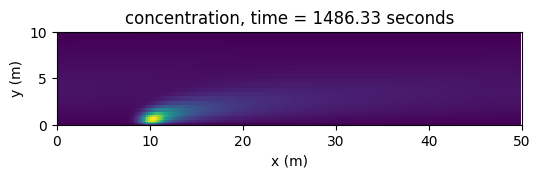

In [7]:
# create a figure and axes
fig = plt.figure(figsize=(6,6))

# Create arrays with the latitude and longitude coordinates for plotting using pcolor
from dedalus.extras import plot_tools
(X, Y) = plot_tools.quad_mesh(np.squeeze(x), np.squeeze(y))

# Define an animation function
def drawframe(n):
    plt.clf()
    concentration = plt.pcolor(X, Y, c_save[n,:,:].T)
    # Specify the axis limits and labels
    plt.axis('square')
    plt.xlim(0, L)
    plt.ylim(0, w)
    plt.xlabel('x (m)')
    plt.ylabel('y (m)')
    plt.title('concentration, time = {0:.2f} seconds'.format(t_save[n]))
    return (concentration,)

from matplotlib import animation
# blit=True re-draws only the parts that have changed.
anim = animation.FuncAnimation(fig, drawframe, frames=len(t_save), interval=40, blit=True)

from IPython.display import HTML
HTML(anim.to_html5_video())

## 2.3 Student investigation
<a id='section2pt3'></a>
In the boxes below, plot the pollution concentration at a few points as a function of time. Then vary the maximum flow speed and the diffusivity and explore how the pollution levels depend on these parameters. Using dimensional analysis, estimate the time needed for the pollution to reach the opposite side of the river. How far downstream of the source do you expect this to happen (assuming that the domain in the x-direction is infinite).

**My Answer**

Below there are two plots showing how concentration varies with time at given points along the river. The first is fairly far down the river, and near its midpoint. The second is near the start of the river, and at the midpoint. The first plot shows a greater magnitude overall, as advection carries the tracer away from start point rapidly. We also see a shift in the first inflection point, where the central point experiences greater concentrations at a later time.

Here, maximum flow speed is 0.1 and $\kappa$ is 1e$^{-2}$.


Text(0.5, 1.0, 'Concentration variation with time at 23.4m length, and 3.1m width')

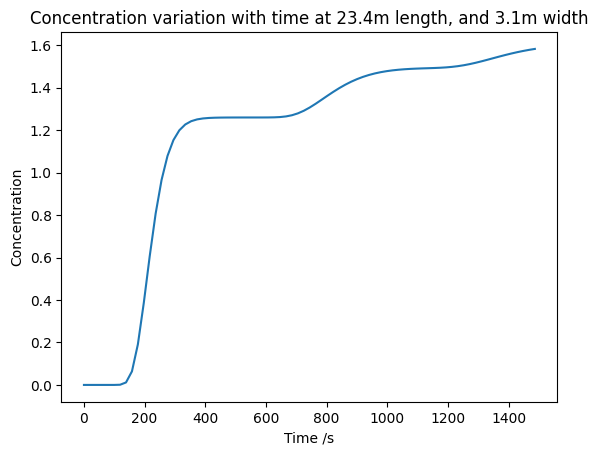

In [8]:
# Nx = 256 - number of gridoints in x. x is length of river.
# Ny = 32 - number of gridpoints in y. y is width of river.
# the [] after c_save describe the concentration at about 2/5 along the river's length
# and about 1/3 along the river's width

x_bit = 120
y_bit = 10
length_bit = x_bit/256 * L
width_bit = y_bit/32 * w

plt.plot(t_save, c_save[:,x_bit,y_bit])
plt.xlabel('Time /s')
plt.ylabel('Concentration')

title = f'Concentration variation with time at {round(length_bit,1)}m length, and {round(width_bit,1)}m width'
plt.title(title)

Text(0.5, 1.0, 'Concentration variation with time at 2.0m length, and 5.0m width')

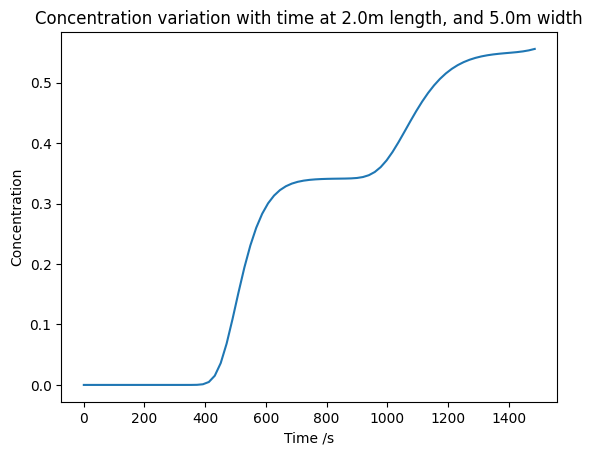

In [9]:
x_bit = 10
y_bit = 16
length_bit = x_bit/256 * L
width_bit = y_bit/32 * w

plt.plot(t_save, c_save[:,x_bit,y_bit])
plt.xlabel('Time /s')
plt.ylabel('Concentration')

title = f'Concentration variation with time at {round(length_bit,1)}m length, and {round(width_bit,1)}m width'
plt.title(title)

**My Answer - continued**

Now, we vary the maximum flow speed and diffusivity. The original value has $U_0 = 0.1$ and $\kappa = 1e^{-7}$. Below, I vary both values to smaller and greater values, with the middle plot showing the original set up.

In the original set up, at this point in the river, we see a maximum concentration of 2. Increasing $U_0$ does not affect the magnitude of final concentration, but produces a more turbulent path. The lowest $U_0$ has a smooth increase due to this lower turbulence.

An increase in $\kappa$ has a more pronounced effect. Doubling $\kappa$ will almost double concentration between scenarios, and vice versa for halving. This is to be expected as with a greater $\kappa$, diffusion is stronger and so more tracer will get to the end of the river. The shape of the concentration curve at a given $U_0$ is maintained for different $\kappa$s, however amplitude is increased for greater $\kappa$ and vice versa.



INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.2e+00/s


2024-12-20 01:41:21,547 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.2e+00/s


INFO:__main__:Starting main loop


2024-12-20 01:41:21,555 __main__ 0/1 INFO :: Starting main loop


INFO:__main__:Iteration=1, Time=3.906250e+00, dt=3.906250e+00


2024-12-20 01:41:21,595 __main__ 0/1 INFO :: Iteration=1, Time=3.906250e+00, dt=3.906250e+00


INFO:__main__:Iteration=11, Time=4.296875e+01, dt=3.906250e+00


2024-12-20 01:41:21,623 __main__ 0/1 INFO :: Iteration=11, Time=4.296875e+01, dt=3.906250e+00


INFO:__main__:Iteration=21, Time=8.203125e+01, dt=3.906250e+00


2024-12-20 01:41:21,650 __main__ 0/1 INFO :: Iteration=21, Time=8.203125e+01, dt=3.906250e+00


INFO:__main__:Iteration=31, Time=1.210938e+02, dt=3.906250e+00


2024-12-20 01:41:21,677 __main__ 0/1 INFO :: Iteration=31, Time=1.210938e+02, dt=3.906250e+00


INFO:__main__:Iteration=41, Time=1.601562e+02, dt=3.906250e+00


2024-12-20 01:41:21,704 __main__ 0/1 INFO :: Iteration=41, Time=1.601562e+02, dt=3.906250e+00


INFO:__main__:Iteration=51, Time=1.992188e+02, dt=3.906250e+00


2024-12-20 01:41:21,732 __main__ 0/1 INFO :: Iteration=51, Time=1.992188e+02, dt=3.906250e+00


INFO:__main__:Iteration=61, Time=2.382812e+02, dt=3.906250e+00


2024-12-20 01:41:21,763 __main__ 0/1 INFO :: Iteration=61, Time=2.382812e+02, dt=3.906250e+00


INFO:__main__:Iteration=71, Time=2.773438e+02, dt=3.906250e+00


2024-12-20 01:41:21,792 __main__ 0/1 INFO :: Iteration=71, Time=2.773438e+02, dt=3.906250e+00


INFO:__main__:Iteration=81, Time=3.164062e+02, dt=3.906250e+00


2024-12-20 01:41:21,821 __main__ 0/1 INFO :: Iteration=81, Time=3.164062e+02, dt=3.906250e+00


INFO:__main__:Iteration=91, Time=3.554688e+02, dt=3.906250e+00


2024-12-20 01:41:21,862 __main__ 0/1 INFO :: Iteration=91, Time=3.554688e+02, dt=3.906250e+00


INFO:__main__:Iteration=101, Time=3.945312e+02, dt=3.906250e+00


2024-12-20 01:41:21,891 __main__ 0/1 INFO :: Iteration=101, Time=3.945312e+02, dt=3.906250e+00


INFO:__main__:Iteration=111, Time=4.335938e+02, dt=3.906250e+00


2024-12-20 01:41:21,920 __main__ 0/1 INFO :: Iteration=111, Time=4.335938e+02, dt=3.906250e+00


INFO:__main__:Iteration=121, Time=4.726562e+02, dt=3.906250e+00


2024-12-20 01:41:21,950 __main__ 0/1 INFO :: Iteration=121, Time=4.726562e+02, dt=3.906250e+00


INFO:__main__:Iteration=131, Time=5.117188e+02, dt=3.906250e+00


2024-12-20 01:41:21,980 __main__ 0/1 INFO :: Iteration=131, Time=5.117188e+02, dt=3.906250e+00


INFO:__main__:Iteration=141, Time=5.507812e+02, dt=3.906250e+00


2024-12-20 01:41:22,013 __main__ 0/1 INFO :: Iteration=141, Time=5.507812e+02, dt=3.906250e+00


INFO:__main__:Iteration=151, Time=5.898438e+02, dt=3.906250e+00


2024-12-20 01:41:22,041 __main__ 0/1 INFO :: Iteration=151, Time=5.898438e+02, dt=3.906250e+00


INFO:__main__:Iteration=161, Time=6.289062e+02, dt=3.906250e+00


2024-12-20 01:41:22,074 __main__ 0/1 INFO :: Iteration=161, Time=6.289062e+02, dt=3.906250e+00


INFO:__main__:Iteration=171, Time=6.679688e+02, dt=3.906250e+00


2024-12-20 01:41:22,102 __main__ 0/1 INFO :: Iteration=171, Time=6.679688e+02, dt=3.906250e+00


INFO:__main__:Iteration=181, Time=7.070312e+02, dt=3.906250e+00


2024-12-20 01:41:22,131 __main__ 0/1 INFO :: Iteration=181, Time=7.070312e+02, dt=3.906250e+00


INFO:__main__:Iteration=191, Time=7.460938e+02, dt=3.906250e+00


2024-12-20 01:41:22,160 __main__ 0/1 INFO :: Iteration=191, Time=7.460938e+02, dt=3.906250e+00


INFO:__main__:Iteration=201, Time=7.851562e+02, dt=3.906250e+00


2024-12-20 01:41:22,189 __main__ 0/1 INFO :: Iteration=201, Time=7.851562e+02, dt=3.906250e+00


INFO:__main__:Iteration=211, Time=8.242188e+02, dt=3.906250e+00


2024-12-20 01:41:22,220 __main__ 0/1 INFO :: Iteration=211, Time=8.242188e+02, dt=3.906250e+00


INFO:__main__:Iteration=221, Time=8.632812e+02, dt=3.906250e+00


2024-12-20 01:41:22,260 __main__ 0/1 INFO :: Iteration=221, Time=8.632812e+02, dt=3.906250e+00


INFO:__main__:Iteration=231, Time=9.023438e+02, dt=3.906250e+00


2024-12-20 01:41:22,296 __main__ 0/1 INFO :: Iteration=231, Time=9.023438e+02, dt=3.906250e+00


INFO:__main__:Iteration=241, Time=9.414062e+02, dt=3.906250e+00


2024-12-20 01:41:22,332 __main__ 0/1 INFO :: Iteration=241, Time=9.414062e+02, dt=3.906250e+00


INFO:__main__:Iteration=251, Time=9.804688e+02, dt=3.906250e+00


2024-12-20 01:41:22,367 __main__ 0/1 INFO :: Iteration=251, Time=9.804688e+02, dt=3.906250e+00


INFO:__main__:Iteration=261, Time=1.019531e+03, dt=3.906250e+00


2024-12-20 01:41:22,400 __main__ 0/1 INFO :: Iteration=261, Time=1.019531e+03, dt=3.906250e+00


INFO:__main__:Iteration=271, Time=1.058594e+03, dt=3.906250e+00


2024-12-20 01:41:22,443 __main__ 0/1 INFO :: Iteration=271, Time=1.058594e+03, dt=3.906250e+00


INFO:__main__:Iteration=281, Time=1.097656e+03, dt=3.906250e+00


2024-12-20 01:41:22,479 __main__ 0/1 INFO :: Iteration=281, Time=1.097656e+03, dt=3.906250e+00


INFO:__main__:Iteration=291, Time=1.136719e+03, dt=3.906250e+00


2024-12-20 01:41:22,519 __main__ 0/1 INFO :: Iteration=291, Time=1.136719e+03, dt=3.906250e+00


INFO:__main__:Iteration=301, Time=1.175781e+03, dt=3.906250e+00


2024-12-20 01:41:22,555 __main__ 0/1 INFO :: Iteration=301, Time=1.175781e+03, dt=3.906250e+00


INFO:__main__:Iteration=311, Time=1.214844e+03, dt=3.906250e+00


2024-12-20 01:41:22,589 __main__ 0/1 INFO :: Iteration=311, Time=1.214844e+03, dt=3.906250e+00


INFO:__main__:Iteration=321, Time=1.253906e+03, dt=3.906250e+00


2024-12-20 01:41:22,617 __main__ 0/1 INFO :: Iteration=321, Time=1.253906e+03, dt=3.906250e+00


INFO:__main__:Iteration=331, Time=1.292969e+03, dt=3.906250e+00


2024-12-20 01:41:22,645 __main__ 0/1 INFO :: Iteration=331, Time=1.292969e+03, dt=3.906250e+00


INFO:__main__:Iteration=341, Time=1.332031e+03, dt=3.906250e+00


2024-12-20 01:41:22,674 __main__ 0/1 INFO :: Iteration=341, Time=1.332031e+03, dt=3.906250e+00


INFO:__main__:Iteration=351, Time=1.371094e+03, dt=3.906250e+00


2024-12-20 01:41:22,702 __main__ 0/1 INFO :: Iteration=351, Time=1.371094e+03, dt=3.906250e+00


INFO:__main__:Iteration=361, Time=1.410156e+03, dt=3.906250e+00


2024-12-20 01:41:22,731 __main__ 0/1 INFO :: Iteration=361, Time=1.410156e+03, dt=3.906250e+00


INFO:__main__:Iteration=371, Time=1.449219e+03, dt=3.906250e+00


2024-12-20 01:41:22,759 __main__ 0/1 INFO :: Iteration=371, Time=1.449219e+03, dt=3.906250e+00


INFO:__main__:Iteration=381, Time=1.488281e+03, dt=3.906250e+00


2024-12-20 01:41:22,786 __main__ 0/1 INFO :: Iteration=381, Time=1.488281e+03, dt=3.906250e+00


INFO:solvers:Simulation stop time reached.


2024-12-20 01:41:22,799 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 384


2024-12-20 01:41:22,803 solvers 0/1 INFO :: Final iteration: 384


INFO:solvers:Final sim time: 1500.0


2024-12-20 01:41:22,806 solvers 0/1 INFO :: Final sim time: 1500.0


INFO:solvers:Setup time (init - iter 0): 0.278 sec


2024-12-20 01:41:22,810 solvers 0/1 INFO :: Setup time (init - iter 0): 0.278 sec


INFO:solvers:Warmup time (iter 0-10): 0.05924 sec


2024-12-20 01:41:22,818 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.05924 sec


INFO:solvers:Run time (iter 10-end): 1.182 sec


2024-12-20 01:41:22,820 solvers 0/1 INFO :: Run time (iter 10-end): 1.182 sec


INFO:solvers:CPU time (iter 10-end): 0.0003283 cpu-hr


2024-12-20 01:41:22,822 solvers 0/1 INFO :: CPU time (iter 10-end): 0.0003283 cpu-hr


INFO:solvers:Speed: 5.488e+06 mode-stages/cpu-sec


2024-12-20 01:41:22,824 solvers 0/1 INFO :: Speed: 5.488e+06 mode-stages/cpu-sec


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.9e+00/s


2024-12-20 01:41:23,157 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.9e+00/s


INFO:__main__:Starting main loop


2024-12-20 01:41:23,163 __main__ 0/1 INFO :: Starting main loop


INFO:__main__:Iteration=1, Time=1.953125e+00, dt=1.953125e+00


2024-12-20 01:41:23,201 __main__ 0/1 INFO :: Iteration=1, Time=1.953125e+00, dt=1.953125e+00


INFO:__main__:Iteration=11, Time=2.148438e+01, dt=1.953125e+00


2024-12-20 01:41:23,234 __main__ 0/1 INFO :: Iteration=11, Time=2.148438e+01, dt=1.953125e+00


INFO:__main__:Iteration=21, Time=4.101562e+01, dt=1.953125e+00


2024-12-20 01:41:23,267 __main__ 0/1 INFO :: Iteration=21, Time=4.101562e+01, dt=1.953125e+00


INFO:__main__:Iteration=31, Time=6.054688e+01, dt=1.953125e+00


2024-12-20 01:41:23,305 __main__ 0/1 INFO :: Iteration=31, Time=6.054688e+01, dt=1.953125e+00


INFO:__main__:Iteration=41, Time=8.007812e+01, dt=1.953125e+00


2024-12-20 01:41:23,340 __main__ 0/1 INFO :: Iteration=41, Time=8.007812e+01, dt=1.953125e+00


INFO:__main__:Iteration=51, Time=9.960938e+01, dt=1.953125e+00


2024-12-20 01:41:23,377 __main__ 0/1 INFO :: Iteration=51, Time=9.960938e+01, dt=1.953125e+00


INFO:__main__:Iteration=61, Time=1.191406e+02, dt=1.953125e+00


2024-12-20 01:41:23,410 __main__ 0/1 INFO :: Iteration=61, Time=1.191406e+02, dt=1.953125e+00


INFO:__main__:Iteration=71, Time=1.386719e+02, dt=1.953125e+00


2024-12-20 01:41:23,449 __main__ 0/1 INFO :: Iteration=71, Time=1.386719e+02, dt=1.953125e+00


INFO:__main__:Iteration=81, Time=1.582031e+02, dt=1.953125e+00


2024-12-20 01:41:23,483 __main__ 0/1 INFO :: Iteration=81, Time=1.582031e+02, dt=1.953125e+00


INFO:__main__:Iteration=91, Time=1.777344e+02, dt=1.953125e+00


2024-12-20 01:41:23,517 __main__ 0/1 INFO :: Iteration=91, Time=1.777344e+02, dt=1.953125e+00


INFO:__main__:Iteration=101, Time=1.972656e+02, dt=1.953125e+00


2024-12-20 01:41:23,547 __main__ 0/1 INFO :: Iteration=101, Time=1.972656e+02, dt=1.953125e+00


INFO:__main__:Iteration=111, Time=2.167969e+02, dt=1.953125e+00


2024-12-20 01:41:23,577 __main__ 0/1 INFO :: Iteration=111, Time=2.167969e+02, dt=1.953125e+00


INFO:__main__:Iteration=121, Time=2.363281e+02, dt=1.953125e+00


2024-12-20 01:41:23,608 __main__ 0/1 INFO :: Iteration=121, Time=2.363281e+02, dt=1.953125e+00


INFO:__main__:Iteration=131, Time=2.558594e+02, dt=1.953125e+00


2024-12-20 01:41:23,637 __main__ 0/1 INFO :: Iteration=131, Time=2.558594e+02, dt=1.953125e+00


INFO:__main__:Iteration=141, Time=2.753906e+02, dt=1.953125e+00


2024-12-20 01:41:23,666 __main__ 0/1 INFO :: Iteration=141, Time=2.753906e+02, dt=1.953125e+00


INFO:__main__:Iteration=151, Time=2.949219e+02, dt=1.953125e+00


2024-12-20 01:41:23,695 __main__ 0/1 INFO :: Iteration=151, Time=2.949219e+02, dt=1.953125e+00


INFO:__main__:Iteration=161, Time=3.144531e+02, dt=1.953125e+00


2024-12-20 01:41:23,724 __main__ 0/1 INFO :: Iteration=161, Time=3.144531e+02, dt=1.953125e+00


INFO:__main__:Iteration=171, Time=3.339844e+02, dt=1.953125e+00


2024-12-20 01:41:23,751 __main__ 0/1 INFO :: Iteration=171, Time=3.339844e+02, dt=1.953125e+00


INFO:__main__:Iteration=181, Time=3.535156e+02, dt=1.953125e+00


2024-12-20 01:41:23,778 __main__ 0/1 INFO :: Iteration=181, Time=3.535156e+02, dt=1.953125e+00


INFO:__main__:Iteration=191, Time=3.730469e+02, dt=1.953125e+00


2024-12-20 01:41:23,806 __main__ 0/1 INFO :: Iteration=191, Time=3.730469e+02, dt=1.953125e+00


INFO:__main__:Iteration=201, Time=3.925781e+02, dt=1.953125e+00


2024-12-20 01:41:23,835 __main__ 0/1 INFO :: Iteration=201, Time=3.925781e+02, dt=1.953125e+00


INFO:__main__:Iteration=211, Time=4.121094e+02, dt=1.953125e+00


2024-12-20 01:41:23,866 __main__ 0/1 INFO :: Iteration=211, Time=4.121094e+02, dt=1.953125e+00


INFO:__main__:Iteration=221, Time=4.316406e+02, dt=1.953125e+00


2024-12-20 01:41:23,899 __main__ 0/1 INFO :: Iteration=221, Time=4.316406e+02, dt=1.953125e+00


INFO:__main__:Iteration=231, Time=4.511719e+02, dt=1.953125e+00


2024-12-20 01:41:23,934 __main__ 0/1 INFO :: Iteration=231, Time=4.511719e+02, dt=1.953125e+00


INFO:__main__:Iteration=241, Time=4.707031e+02, dt=1.953125e+00


2024-12-20 01:41:23,965 __main__ 0/1 INFO :: Iteration=241, Time=4.707031e+02, dt=1.953125e+00


INFO:__main__:Iteration=251, Time=4.902344e+02, dt=1.953125e+00


2024-12-20 01:41:23,993 __main__ 0/1 INFO :: Iteration=251, Time=4.902344e+02, dt=1.953125e+00


INFO:__main__:Iteration=261, Time=5.097656e+02, dt=1.953125e+00


2024-12-20 01:41:24,024 __main__ 0/1 INFO :: Iteration=261, Time=5.097656e+02, dt=1.953125e+00


INFO:__main__:Iteration=271, Time=5.292969e+02, dt=1.953125e+00


2024-12-20 01:41:24,062 __main__ 0/1 INFO :: Iteration=271, Time=5.292969e+02, dt=1.953125e+00


INFO:__main__:Iteration=281, Time=5.488281e+02, dt=1.953125e+00


2024-12-20 01:41:24,092 __main__ 0/1 INFO :: Iteration=281, Time=5.488281e+02, dt=1.953125e+00


INFO:__main__:Iteration=291, Time=5.683594e+02, dt=1.953125e+00


2024-12-20 01:41:24,121 __main__ 0/1 INFO :: Iteration=291, Time=5.683594e+02, dt=1.953125e+00


INFO:__main__:Iteration=301, Time=5.878906e+02, dt=1.953125e+00


2024-12-20 01:41:24,151 __main__ 0/1 INFO :: Iteration=301, Time=5.878906e+02, dt=1.953125e+00


INFO:__main__:Iteration=311, Time=6.074219e+02, dt=1.953125e+00


2024-12-20 01:41:24,182 __main__ 0/1 INFO :: Iteration=311, Time=6.074219e+02, dt=1.953125e+00


INFO:__main__:Iteration=321, Time=6.269531e+02, dt=1.953125e+00


2024-12-20 01:41:24,218 __main__ 0/1 INFO :: Iteration=321, Time=6.269531e+02, dt=1.953125e+00


INFO:__main__:Iteration=331, Time=6.464844e+02, dt=1.953125e+00


2024-12-20 01:41:24,259 __main__ 0/1 INFO :: Iteration=331, Time=6.464844e+02, dt=1.953125e+00


INFO:__main__:Iteration=341, Time=6.660156e+02, dt=1.953125e+00


2024-12-20 01:41:24,299 __main__ 0/1 INFO :: Iteration=341, Time=6.660156e+02, dt=1.953125e+00


INFO:__main__:Iteration=351, Time=6.855469e+02, dt=1.953125e+00


2024-12-20 01:41:24,334 __main__ 0/1 INFO :: Iteration=351, Time=6.855469e+02, dt=1.953125e+00


INFO:__main__:Iteration=361, Time=7.050781e+02, dt=1.953125e+00


2024-12-20 01:41:24,370 __main__ 0/1 INFO :: Iteration=361, Time=7.050781e+02, dt=1.953125e+00


INFO:__main__:Iteration=371, Time=7.246094e+02, dt=1.953125e+00


2024-12-20 01:41:24,406 __main__ 0/1 INFO :: Iteration=371, Time=7.246094e+02, dt=1.953125e+00


INFO:__main__:Iteration=381, Time=7.441406e+02, dt=1.953125e+00


2024-12-20 01:41:24,446 __main__ 0/1 INFO :: Iteration=381, Time=7.441406e+02, dt=1.953125e+00


INFO:__main__:Iteration=391, Time=7.636719e+02, dt=1.953125e+00


2024-12-20 01:41:24,486 __main__ 0/1 INFO :: Iteration=391, Time=7.636719e+02, dt=1.953125e+00


INFO:__main__:Iteration=401, Time=7.832031e+02, dt=1.953125e+00


2024-12-20 01:41:24,524 __main__ 0/1 INFO :: Iteration=401, Time=7.832031e+02, dt=1.953125e+00


INFO:__main__:Iteration=411, Time=8.027344e+02, dt=1.953125e+00


2024-12-20 01:41:24,560 __main__ 0/1 INFO :: Iteration=411, Time=8.027344e+02, dt=1.953125e+00


INFO:__main__:Iteration=421, Time=8.222656e+02, dt=1.953125e+00


2024-12-20 01:41:24,594 __main__ 0/1 INFO :: Iteration=421, Time=8.222656e+02, dt=1.953125e+00


INFO:__main__:Iteration=431, Time=8.417969e+02, dt=1.953125e+00


2024-12-20 01:41:24,625 __main__ 0/1 INFO :: Iteration=431, Time=8.417969e+02, dt=1.953125e+00


INFO:__main__:Iteration=441, Time=8.613281e+02, dt=1.953125e+00


2024-12-20 01:41:24,656 __main__ 0/1 INFO :: Iteration=441, Time=8.613281e+02, dt=1.953125e+00


INFO:__main__:Iteration=451, Time=8.808594e+02, dt=1.953125e+00


2024-12-20 01:41:24,686 __main__ 0/1 INFO :: Iteration=451, Time=8.808594e+02, dt=1.953125e+00


INFO:__main__:Iteration=461, Time=9.003906e+02, dt=1.953125e+00


2024-12-20 01:41:24,715 __main__ 0/1 INFO :: Iteration=461, Time=9.003906e+02, dt=1.953125e+00


INFO:__main__:Iteration=471, Time=9.199219e+02, dt=1.953125e+00


2024-12-20 01:41:24,744 __main__ 0/1 INFO :: Iteration=471, Time=9.199219e+02, dt=1.953125e+00


INFO:__main__:Iteration=481, Time=9.394531e+02, dt=1.953125e+00


2024-12-20 01:41:24,774 __main__ 0/1 INFO :: Iteration=481, Time=9.394531e+02, dt=1.953125e+00


INFO:__main__:Iteration=491, Time=9.589844e+02, dt=1.953125e+00


2024-12-20 01:41:24,805 __main__ 0/1 INFO :: Iteration=491, Time=9.589844e+02, dt=1.953125e+00


INFO:__main__:Iteration=501, Time=9.785156e+02, dt=1.953125e+00


2024-12-20 01:41:24,839 __main__ 0/1 INFO :: Iteration=501, Time=9.785156e+02, dt=1.953125e+00


INFO:__main__:Iteration=511, Time=9.980469e+02, dt=1.953125e+00


2024-12-20 01:41:24,868 __main__ 0/1 INFO :: Iteration=511, Time=9.980469e+02, dt=1.953125e+00


INFO:__main__:Iteration=521, Time=1.017578e+03, dt=1.953125e+00


2024-12-20 01:41:24,899 __main__ 0/1 INFO :: Iteration=521, Time=1.017578e+03, dt=1.953125e+00


INFO:__main__:Iteration=531, Time=1.037109e+03, dt=1.953125e+00


2024-12-20 01:41:24,929 __main__ 0/1 INFO :: Iteration=531, Time=1.037109e+03, dt=1.953125e+00


INFO:__main__:Iteration=541, Time=1.056641e+03, dt=1.953125e+00


2024-12-20 01:41:24,971 __main__ 0/1 INFO :: Iteration=541, Time=1.056641e+03, dt=1.953125e+00


INFO:__main__:Iteration=551, Time=1.076172e+03, dt=1.953125e+00


2024-12-20 01:41:25,002 __main__ 0/1 INFO :: Iteration=551, Time=1.076172e+03, dt=1.953125e+00


INFO:__main__:Iteration=561, Time=1.095703e+03, dt=1.953125e+00


2024-12-20 01:41:25,034 __main__ 0/1 INFO :: Iteration=561, Time=1.095703e+03, dt=1.953125e+00


INFO:__main__:Iteration=571, Time=1.115234e+03, dt=1.953125e+00


2024-12-20 01:41:25,063 __main__ 0/1 INFO :: Iteration=571, Time=1.115234e+03, dt=1.953125e+00


INFO:__main__:Iteration=581, Time=1.134766e+03, dt=1.953125e+00


2024-12-20 01:41:25,094 __main__ 0/1 INFO :: Iteration=581, Time=1.134766e+03, dt=1.953125e+00


INFO:__main__:Iteration=591, Time=1.154297e+03, dt=1.953125e+00


2024-12-20 01:41:25,125 __main__ 0/1 INFO :: Iteration=591, Time=1.154297e+03, dt=1.953125e+00


INFO:__main__:Iteration=601, Time=1.173828e+03, dt=1.953125e+00


2024-12-20 01:41:25,163 __main__ 0/1 INFO :: Iteration=601, Time=1.173828e+03, dt=1.953125e+00


INFO:__main__:Iteration=611, Time=1.193359e+03, dt=1.953125e+00


2024-12-20 01:41:25,194 __main__ 0/1 INFO :: Iteration=611, Time=1.193359e+03, dt=1.953125e+00


INFO:__main__:Iteration=621, Time=1.212891e+03, dt=1.953125e+00


2024-12-20 01:41:25,228 __main__ 0/1 INFO :: Iteration=621, Time=1.212891e+03, dt=1.953125e+00


INFO:__main__:Iteration=631, Time=1.232422e+03, dt=1.953125e+00


2024-12-20 01:41:25,264 __main__ 0/1 INFO :: Iteration=631, Time=1.232422e+03, dt=1.953125e+00


INFO:__main__:Iteration=641, Time=1.251953e+03, dt=1.953125e+00


2024-12-20 01:41:25,300 __main__ 0/1 INFO :: Iteration=641, Time=1.251953e+03, dt=1.953125e+00


INFO:__main__:Iteration=651, Time=1.271484e+03, dt=1.953125e+00


2024-12-20 01:41:25,339 __main__ 0/1 INFO :: Iteration=651, Time=1.271484e+03, dt=1.953125e+00


INFO:__main__:Iteration=661, Time=1.291016e+03, dt=1.953125e+00


2024-12-20 01:41:25,377 __main__ 0/1 INFO :: Iteration=661, Time=1.291016e+03, dt=1.953125e+00


INFO:__main__:Iteration=671, Time=1.310547e+03, dt=1.953125e+00


2024-12-20 01:41:25,414 __main__ 0/1 INFO :: Iteration=671, Time=1.310547e+03, dt=1.953125e+00


INFO:__main__:Iteration=681, Time=1.330078e+03, dt=1.953125e+00


2024-12-20 01:41:25,456 __main__ 0/1 INFO :: Iteration=681, Time=1.330078e+03, dt=1.953125e+00


INFO:__main__:Iteration=691, Time=1.349609e+03, dt=1.953125e+00


2024-12-20 01:41:25,492 __main__ 0/1 INFO :: Iteration=691, Time=1.349609e+03, dt=1.953125e+00


INFO:__main__:Iteration=701, Time=1.369141e+03, dt=1.953125e+00


2024-12-20 01:41:25,531 __main__ 0/1 INFO :: Iteration=701, Time=1.369141e+03, dt=1.953125e+00


INFO:__main__:Iteration=711, Time=1.388672e+03, dt=1.953125e+00


2024-12-20 01:41:25,568 __main__ 0/1 INFO :: Iteration=711, Time=1.388672e+03, dt=1.953125e+00


INFO:__main__:Iteration=721, Time=1.408203e+03, dt=1.953125e+00


2024-12-20 01:41:25,600 __main__ 0/1 INFO :: Iteration=721, Time=1.408203e+03, dt=1.953125e+00


INFO:__main__:Iteration=731, Time=1.427734e+03, dt=1.953125e+00


2024-12-20 01:41:25,629 __main__ 0/1 INFO :: Iteration=731, Time=1.427734e+03, dt=1.953125e+00


INFO:__main__:Iteration=741, Time=1.447266e+03, dt=1.953125e+00


2024-12-20 01:41:25,658 __main__ 0/1 INFO :: Iteration=741, Time=1.447266e+03, dt=1.953125e+00


INFO:__main__:Iteration=751, Time=1.466797e+03, dt=1.953125e+00


2024-12-20 01:41:25,690 __main__ 0/1 INFO :: Iteration=751, Time=1.466797e+03, dt=1.953125e+00


INFO:__main__:Iteration=761, Time=1.486328e+03, dt=1.953125e+00


2024-12-20 01:41:25,718 __main__ 0/1 INFO :: Iteration=761, Time=1.486328e+03, dt=1.953125e+00


INFO:solvers:Simulation stop time reached.


2024-12-20 01:41:25,741 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 768


2024-12-20 01:41:25,744 solvers 0/1 INFO :: Final iteration: 768


INFO:solvers:Final sim time: 1500.0


2024-12-20 01:41:25,747 solvers 0/1 INFO :: Final sim time: 1500.0


INFO:solvers:Setup time (init - iter 0): 0.3032 sec


2024-12-20 01:41:25,750 solvers 0/1 INFO :: Setup time (init - iter 0): 0.3032 sec


INFO:solvers:Warmup time (iter 0-10): 0.06048 sec


2024-12-20 01:41:25,756 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.06048 sec


INFO:solvers:Run time (iter 10-end): 2.513 sec


2024-12-20 01:41:25,758 solvers 0/1 INFO :: Run time (iter 10-end): 2.513 sec


INFO:solvers:CPU time (iter 10-end): 0.000698 cpu-hr


2024-12-20 01:41:25,761 solvers 0/1 INFO :: CPU time (iter 10-end): 0.000698 cpu-hr


INFO:solvers:Speed: 5.231e+06 mode-stages/cpu-sec


2024-12-20 01:41:25,766 solvers 0/1 INFO :: Speed: 5.231e+06 mode-stages/cpu-sec


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.0e+00/s


2024-12-20 01:41:26,088 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.0e+00/s


INFO:__main__:Starting main loop


2024-12-20 01:41:26,096 __main__ 0/1 INFO :: Starting main loop


INFO:__main__:Iteration=1, Time=9.765625e-01, dt=9.765625e-01


2024-12-20 01:41:26,143 __main__ 0/1 INFO :: Iteration=1, Time=9.765625e-01, dt=9.765625e-01


INFO:__main__:Iteration=11, Time=1.074219e+01, dt=9.765625e-01


2024-12-20 01:41:26,181 __main__ 0/1 INFO :: Iteration=11, Time=1.074219e+01, dt=9.765625e-01


INFO:__main__:Iteration=21, Time=2.050781e+01, dt=9.765625e-01


2024-12-20 01:41:26,210 __main__ 0/1 INFO :: Iteration=21, Time=2.050781e+01, dt=9.765625e-01


INFO:__main__:Iteration=31, Time=3.027344e+01, dt=9.765625e-01


2024-12-20 01:41:26,247 __main__ 0/1 INFO :: Iteration=31, Time=3.027344e+01, dt=9.765625e-01


INFO:__main__:Iteration=41, Time=4.003906e+01, dt=9.765625e-01


2024-12-20 01:41:26,285 __main__ 0/1 INFO :: Iteration=41, Time=4.003906e+01, dt=9.765625e-01


INFO:__main__:Iteration=51, Time=4.980469e+01, dt=9.765625e-01


2024-12-20 01:41:26,321 __main__ 0/1 INFO :: Iteration=51, Time=4.980469e+01, dt=9.765625e-01


INFO:__main__:Iteration=61, Time=5.957031e+01, dt=9.765625e-01


2024-12-20 01:41:26,357 __main__ 0/1 INFO :: Iteration=61, Time=5.957031e+01, dt=9.765625e-01


INFO:__main__:Iteration=71, Time=6.933594e+01, dt=9.765625e-01


2024-12-20 01:41:26,393 __main__ 0/1 INFO :: Iteration=71, Time=6.933594e+01, dt=9.765625e-01


INFO:__main__:Iteration=81, Time=7.910156e+01, dt=9.765625e-01


2024-12-20 01:41:26,431 __main__ 0/1 INFO :: Iteration=81, Time=7.910156e+01, dt=9.765625e-01


INFO:__main__:Iteration=91, Time=8.886719e+01, dt=9.765625e-01


2024-12-20 01:41:26,470 __main__ 0/1 INFO :: Iteration=91, Time=8.886719e+01, dt=9.765625e-01


INFO:__main__:Iteration=101, Time=9.863281e+01, dt=9.765625e-01


2024-12-20 01:41:26,507 __main__ 0/1 INFO :: Iteration=101, Time=9.863281e+01, dt=9.765625e-01


INFO:__main__:Iteration=111, Time=1.083984e+02, dt=9.765625e-01


2024-12-20 01:41:26,537 __main__ 0/1 INFO :: Iteration=111, Time=1.083984e+02, dt=9.765625e-01


INFO:__main__:Iteration=121, Time=1.181641e+02, dt=9.765625e-01


2024-12-20 01:41:26,566 __main__ 0/1 INFO :: Iteration=121, Time=1.181641e+02, dt=9.765625e-01


INFO:__main__:Iteration=131, Time=1.279297e+02, dt=9.765625e-01


2024-12-20 01:41:26,599 __main__ 0/1 INFO :: Iteration=131, Time=1.279297e+02, dt=9.765625e-01


INFO:__main__:Iteration=141, Time=1.376953e+02, dt=9.765625e-01


2024-12-20 01:41:26,628 __main__ 0/1 INFO :: Iteration=141, Time=1.376953e+02, dt=9.765625e-01


INFO:__main__:Iteration=151, Time=1.474609e+02, dt=9.765625e-01


2024-12-20 01:41:26,657 __main__ 0/1 INFO :: Iteration=151, Time=1.474609e+02, dt=9.765625e-01


INFO:__main__:Iteration=161, Time=1.572266e+02, dt=9.765625e-01


2024-12-20 01:41:26,690 __main__ 0/1 INFO :: Iteration=161, Time=1.572266e+02, dt=9.765625e-01


INFO:__main__:Iteration=171, Time=1.669922e+02, dt=9.765625e-01


2024-12-20 01:41:26,719 __main__ 0/1 INFO :: Iteration=171, Time=1.669922e+02, dt=9.765625e-01


INFO:__main__:Iteration=181, Time=1.767578e+02, dt=9.765625e-01


2024-12-20 01:41:26,748 __main__ 0/1 INFO :: Iteration=181, Time=1.767578e+02, dt=9.765625e-01


INFO:__main__:Iteration=191, Time=1.865234e+02, dt=9.765625e-01


2024-12-20 01:41:26,778 __main__ 0/1 INFO :: Iteration=191, Time=1.865234e+02, dt=9.765625e-01


INFO:__main__:Iteration=201, Time=1.962891e+02, dt=9.765625e-01


2024-12-20 01:41:26,809 __main__ 0/1 INFO :: Iteration=201, Time=1.962891e+02, dt=9.765625e-01


INFO:__main__:Iteration=211, Time=2.060547e+02, dt=9.765625e-01


2024-12-20 01:41:26,839 __main__ 0/1 INFO :: Iteration=211, Time=2.060547e+02, dt=9.765625e-01


INFO:__main__:Iteration=221, Time=2.158203e+02, dt=9.765625e-01


2024-12-20 01:41:26,869 __main__ 0/1 INFO :: Iteration=221, Time=2.158203e+02, dt=9.765625e-01


INFO:__main__:Iteration=231, Time=2.255859e+02, dt=9.765625e-01


2024-12-20 01:41:26,898 __main__ 0/1 INFO :: Iteration=231, Time=2.255859e+02, dt=9.765625e-01


INFO:__main__:Iteration=241, Time=2.353516e+02, dt=9.765625e-01


2024-12-20 01:41:26,927 __main__ 0/1 INFO :: Iteration=241, Time=2.353516e+02, dt=9.765625e-01


INFO:__main__:Iteration=251, Time=2.451172e+02, dt=9.765625e-01


2024-12-20 01:41:26,958 __main__ 0/1 INFO :: Iteration=251, Time=2.451172e+02, dt=9.765625e-01


INFO:__main__:Iteration=261, Time=2.548828e+02, dt=9.765625e-01


2024-12-20 01:41:26,990 __main__ 0/1 INFO :: Iteration=261, Time=2.548828e+02, dt=9.765625e-01


INFO:__main__:Iteration=271, Time=2.646484e+02, dt=9.765625e-01


2024-12-20 01:41:27,028 __main__ 0/1 INFO :: Iteration=271, Time=2.646484e+02, dt=9.765625e-01


INFO:__main__:Iteration=281, Time=2.744141e+02, dt=9.765625e-01


2024-12-20 01:41:27,062 __main__ 0/1 INFO :: Iteration=281, Time=2.744141e+02, dt=9.765625e-01


INFO:__main__:Iteration=291, Time=2.841797e+02, dt=9.765625e-01


2024-12-20 01:41:27,092 __main__ 0/1 INFO :: Iteration=291, Time=2.841797e+02, dt=9.765625e-01


INFO:__main__:Iteration=301, Time=2.939453e+02, dt=9.765625e-01


2024-12-20 01:41:27,123 __main__ 0/1 INFO :: Iteration=301, Time=2.939453e+02, dt=9.765625e-01


INFO:__main__:Iteration=311, Time=3.037109e+02, dt=9.765625e-01


2024-12-20 01:41:27,153 __main__ 0/1 INFO :: Iteration=311, Time=3.037109e+02, dt=9.765625e-01


INFO:__main__:Iteration=321, Time=3.134766e+02, dt=9.765625e-01


2024-12-20 01:41:27,183 __main__ 0/1 INFO :: Iteration=321, Time=3.134766e+02, dt=9.765625e-01


INFO:__main__:Iteration=331, Time=3.232422e+02, dt=9.765625e-01


2024-12-20 01:41:27,218 __main__ 0/1 INFO :: Iteration=331, Time=3.232422e+02, dt=9.765625e-01


INFO:__main__:Iteration=341, Time=3.330078e+02, dt=9.765625e-01


2024-12-20 01:41:27,258 __main__ 0/1 INFO :: Iteration=341, Time=3.330078e+02, dt=9.765625e-01


INFO:__main__:Iteration=351, Time=3.427734e+02, dt=9.765625e-01


2024-12-20 01:41:27,295 __main__ 0/1 INFO :: Iteration=351, Time=3.427734e+02, dt=9.765625e-01


INFO:__main__:Iteration=361, Time=3.525391e+02, dt=9.765625e-01


2024-12-20 01:41:27,331 __main__ 0/1 INFO :: Iteration=361, Time=3.525391e+02, dt=9.765625e-01


INFO:__main__:Iteration=371, Time=3.623047e+02, dt=9.765625e-01


2024-12-20 01:41:27,370 __main__ 0/1 INFO :: Iteration=371, Time=3.623047e+02, dt=9.765625e-01


INFO:__main__:Iteration=381, Time=3.720703e+02, dt=9.765625e-01


2024-12-20 01:41:27,410 __main__ 0/1 INFO :: Iteration=381, Time=3.720703e+02, dt=9.765625e-01


INFO:__main__:Iteration=391, Time=3.818359e+02, dt=9.765625e-01


2024-12-20 01:41:27,447 __main__ 0/1 INFO :: Iteration=391, Time=3.818359e+02, dt=9.765625e-01


INFO:__main__:Iteration=401, Time=3.916016e+02, dt=9.765625e-01


2024-12-20 01:41:27,488 __main__ 0/1 INFO :: Iteration=401, Time=3.916016e+02, dt=9.765625e-01


INFO:__main__:Iteration=411, Time=4.013672e+02, dt=9.765625e-01


2024-12-20 01:41:27,526 __main__ 0/1 INFO :: Iteration=411, Time=4.013672e+02, dt=9.765625e-01


INFO:__main__:Iteration=421, Time=4.111328e+02, dt=9.765625e-01


2024-12-20 01:41:27,575 __main__ 0/1 INFO :: Iteration=421, Time=4.111328e+02, dt=9.765625e-01


INFO:__main__:Iteration=431, Time=4.208984e+02, dt=9.765625e-01


2024-12-20 01:41:27,618 __main__ 0/1 INFO :: Iteration=431, Time=4.208984e+02, dt=9.765625e-01


INFO:__main__:Iteration=441, Time=4.306641e+02, dt=9.765625e-01


2024-12-20 01:41:27,657 __main__ 0/1 INFO :: Iteration=441, Time=4.306641e+02, dt=9.765625e-01


INFO:__main__:Iteration=451, Time=4.404297e+02, dt=9.765625e-01


2024-12-20 01:41:27,703 __main__ 0/1 INFO :: Iteration=451, Time=4.404297e+02, dt=9.765625e-01


INFO:__main__:Iteration=461, Time=4.501953e+02, dt=9.765625e-01


2024-12-20 01:41:27,744 __main__ 0/1 INFO :: Iteration=461, Time=4.501953e+02, dt=9.765625e-01


INFO:__main__:Iteration=471, Time=4.599609e+02, dt=9.765625e-01


2024-12-20 01:41:27,783 __main__ 0/1 INFO :: Iteration=471, Time=4.599609e+02, dt=9.765625e-01


INFO:__main__:Iteration=481, Time=4.697266e+02, dt=9.765625e-01


2024-12-20 01:41:27,822 __main__ 0/1 INFO :: Iteration=481, Time=4.697266e+02, dt=9.765625e-01


INFO:__main__:Iteration=491, Time=4.794922e+02, dt=9.765625e-01


2024-12-20 01:41:27,861 __main__ 0/1 INFO :: Iteration=491, Time=4.794922e+02, dt=9.765625e-01


INFO:__main__:Iteration=501, Time=4.892578e+02, dt=9.765625e-01


2024-12-20 01:41:27,903 __main__ 0/1 INFO :: Iteration=501, Time=4.892578e+02, dt=9.765625e-01


INFO:__main__:Iteration=511, Time=4.990234e+02, dt=9.765625e-01


2024-12-20 01:41:27,945 __main__ 0/1 INFO :: Iteration=511, Time=4.990234e+02, dt=9.765625e-01


INFO:__main__:Iteration=521, Time=5.087891e+02, dt=9.765625e-01


2024-12-20 01:41:27,990 __main__ 0/1 INFO :: Iteration=521, Time=5.087891e+02, dt=9.765625e-01


INFO:__main__:Iteration=531, Time=5.185547e+02, dt=9.765625e-01


2024-12-20 01:41:28,032 __main__ 0/1 INFO :: Iteration=531, Time=5.185547e+02, dt=9.765625e-01


INFO:__main__:Iteration=541, Time=5.283203e+02, dt=9.765625e-01


2024-12-20 01:41:28,081 __main__ 0/1 INFO :: Iteration=541, Time=5.283203e+02, dt=9.765625e-01


INFO:__main__:Iteration=551, Time=5.380859e+02, dt=9.765625e-01


2024-12-20 01:41:28,132 __main__ 0/1 INFO :: Iteration=551, Time=5.380859e+02, dt=9.765625e-01


INFO:__main__:Iteration=561, Time=5.478516e+02, dt=9.765625e-01


2024-12-20 01:41:28,173 __main__ 0/1 INFO :: Iteration=561, Time=5.478516e+02, dt=9.765625e-01


INFO:__main__:Iteration=571, Time=5.576172e+02, dt=9.765625e-01


2024-12-20 01:41:28,214 __main__ 0/1 INFO :: Iteration=571, Time=5.576172e+02, dt=9.765625e-01


INFO:__main__:Iteration=581, Time=5.673828e+02, dt=9.765625e-01


2024-12-20 01:41:28,256 __main__ 0/1 INFO :: Iteration=581, Time=5.673828e+02, dt=9.765625e-01


INFO:__main__:Iteration=591, Time=5.771484e+02, dt=9.765625e-01


2024-12-20 01:41:28,307 __main__ 0/1 INFO :: Iteration=591, Time=5.771484e+02, dt=9.765625e-01


INFO:__main__:Iteration=601, Time=5.869141e+02, dt=9.765625e-01


2024-12-20 01:41:28,365 __main__ 0/1 INFO :: Iteration=601, Time=5.869141e+02, dt=9.765625e-01


INFO:__main__:Iteration=611, Time=5.966797e+02, dt=9.765625e-01


2024-12-20 01:41:28,406 __main__ 0/1 INFO :: Iteration=611, Time=5.966797e+02, dt=9.765625e-01


INFO:__main__:Iteration=621, Time=6.064453e+02, dt=9.765625e-01


2024-12-20 01:41:28,446 __main__ 0/1 INFO :: Iteration=621, Time=6.064453e+02, dt=9.765625e-01


INFO:__main__:Iteration=631, Time=6.162109e+02, dt=9.765625e-01


2024-12-20 01:41:28,487 __main__ 0/1 INFO :: Iteration=631, Time=6.162109e+02, dt=9.765625e-01


INFO:__main__:Iteration=641, Time=6.259766e+02, dt=9.765625e-01


2024-12-20 01:41:28,537 __main__ 0/1 INFO :: Iteration=641, Time=6.259766e+02, dt=9.765625e-01


INFO:__main__:Iteration=651, Time=6.357422e+02, dt=9.765625e-01


2024-12-20 01:41:28,586 __main__ 0/1 INFO :: Iteration=651, Time=6.357422e+02, dt=9.765625e-01


INFO:__main__:Iteration=661, Time=6.455078e+02, dt=9.765625e-01


2024-12-20 01:41:28,629 __main__ 0/1 INFO :: Iteration=661, Time=6.455078e+02, dt=9.765625e-01


INFO:__main__:Iteration=671, Time=6.552734e+02, dt=9.765625e-01


2024-12-20 01:41:28,667 __main__ 0/1 INFO :: Iteration=671, Time=6.552734e+02, dt=9.765625e-01


INFO:__main__:Iteration=681, Time=6.650391e+02, dt=9.765625e-01


2024-12-20 01:41:28,704 __main__ 0/1 INFO :: Iteration=681, Time=6.650391e+02, dt=9.765625e-01


INFO:__main__:Iteration=691, Time=6.748047e+02, dt=9.765625e-01


2024-12-20 01:41:28,742 __main__ 0/1 INFO :: Iteration=691, Time=6.748047e+02, dt=9.765625e-01


INFO:__main__:Iteration=701, Time=6.845703e+02, dt=9.765625e-01


2024-12-20 01:41:28,781 __main__ 0/1 INFO :: Iteration=701, Time=6.845703e+02, dt=9.765625e-01


INFO:__main__:Iteration=711, Time=6.943359e+02, dt=9.765625e-01


2024-12-20 01:41:28,818 __main__ 0/1 INFO :: Iteration=711, Time=6.943359e+02, dt=9.765625e-01


INFO:__main__:Iteration=721, Time=7.041016e+02, dt=9.765625e-01


2024-12-20 01:41:28,855 __main__ 0/1 INFO :: Iteration=721, Time=7.041016e+02, dt=9.765625e-01


INFO:__main__:Iteration=731, Time=7.138672e+02, dt=9.765625e-01


2024-12-20 01:41:28,892 __main__ 0/1 INFO :: Iteration=731, Time=7.138672e+02, dt=9.765625e-01


INFO:__main__:Iteration=741, Time=7.236328e+02, dt=9.765625e-01


2024-12-20 01:41:28,930 __main__ 0/1 INFO :: Iteration=741, Time=7.236328e+02, dt=9.765625e-01


INFO:__main__:Iteration=751, Time=7.333984e+02, dt=9.765625e-01


2024-12-20 01:41:28,967 __main__ 0/1 INFO :: Iteration=751, Time=7.333984e+02, dt=9.765625e-01


INFO:__main__:Iteration=761, Time=7.431641e+02, dt=9.765625e-01


2024-12-20 01:41:29,006 __main__ 0/1 INFO :: Iteration=761, Time=7.431641e+02, dt=9.765625e-01


INFO:__main__:Iteration=771, Time=7.529297e+02, dt=9.765625e-01


2024-12-20 01:41:29,046 __main__ 0/1 INFO :: Iteration=771, Time=7.529297e+02, dt=9.765625e-01


INFO:__main__:Iteration=781, Time=7.626953e+02, dt=9.765625e-01


2024-12-20 01:41:29,090 __main__ 0/1 INFO :: Iteration=781, Time=7.626953e+02, dt=9.765625e-01


INFO:__main__:Iteration=791, Time=7.724609e+02, dt=9.765625e-01


2024-12-20 01:41:29,131 __main__ 0/1 INFO :: Iteration=791, Time=7.724609e+02, dt=9.765625e-01


INFO:__main__:Iteration=801, Time=7.822266e+02, dt=9.765625e-01


2024-12-20 01:41:29,180 __main__ 0/1 INFO :: Iteration=801, Time=7.822266e+02, dt=9.765625e-01


INFO:__main__:Iteration=811, Time=7.919922e+02, dt=9.765625e-01


2024-12-20 01:41:29,223 __main__ 0/1 INFO :: Iteration=811, Time=7.919922e+02, dt=9.765625e-01


INFO:__main__:Iteration=821, Time=8.017578e+02, dt=9.765625e-01


2024-12-20 01:41:29,271 __main__ 0/1 INFO :: Iteration=821, Time=8.017578e+02, dt=9.765625e-01


INFO:__main__:Iteration=831, Time=8.115234e+02, dt=9.765625e-01


2024-12-20 01:41:29,324 __main__ 0/1 INFO :: Iteration=831, Time=8.115234e+02, dt=9.765625e-01


INFO:__main__:Iteration=841, Time=8.212891e+02, dt=9.765625e-01


2024-12-20 01:41:29,367 __main__ 0/1 INFO :: Iteration=841, Time=8.212891e+02, dt=9.765625e-01


INFO:__main__:Iteration=851, Time=8.310547e+02, dt=9.765625e-01


2024-12-20 01:41:29,407 __main__ 0/1 INFO :: Iteration=851, Time=8.310547e+02, dt=9.765625e-01


INFO:__main__:Iteration=861, Time=8.408203e+02, dt=9.765625e-01


2024-12-20 01:41:29,447 __main__ 0/1 INFO :: Iteration=861, Time=8.408203e+02, dt=9.765625e-01


INFO:__main__:Iteration=871, Time=8.505859e+02, dt=9.765625e-01


2024-12-20 01:41:29,492 __main__ 0/1 INFO :: Iteration=871, Time=8.505859e+02, dt=9.765625e-01


INFO:__main__:Iteration=881, Time=8.603516e+02, dt=9.765625e-01


2024-12-20 01:41:29,531 __main__ 0/1 INFO :: Iteration=881, Time=8.603516e+02, dt=9.765625e-01


INFO:__main__:Iteration=891, Time=8.701172e+02, dt=9.765625e-01


2024-12-20 01:41:29,570 __main__ 0/1 INFO :: Iteration=891, Time=8.701172e+02, dt=9.765625e-01


INFO:__main__:Iteration=901, Time=8.798828e+02, dt=9.765625e-01


2024-12-20 01:41:29,611 __main__ 0/1 INFO :: Iteration=901, Time=8.798828e+02, dt=9.765625e-01


INFO:__main__:Iteration=911, Time=8.896484e+02, dt=9.765625e-01


2024-12-20 01:41:29,651 __main__ 0/1 INFO :: Iteration=911, Time=8.896484e+02, dt=9.765625e-01


INFO:__main__:Iteration=921, Time=8.994141e+02, dt=9.765625e-01


2024-12-20 01:41:29,691 __main__ 0/1 INFO :: Iteration=921, Time=8.994141e+02, dt=9.765625e-01


INFO:__main__:Iteration=931, Time=9.091797e+02, dt=9.765625e-01


2024-12-20 01:41:29,729 __main__ 0/1 INFO :: Iteration=931, Time=9.091797e+02, dt=9.765625e-01


INFO:__main__:Iteration=941, Time=9.189453e+02, dt=9.765625e-01


2024-12-20 01:41:29,768 __main__ 0/1 INFO :: Iteration=941, Time=9.189453e+02, dt=9.765625e-01


INFO:__main__:Iteration=951, Time=9.287109e+02, dt=9.765625e-01


2024-12-20 01:41:29,808 __main__ 0/1 INFO :: Iteration=951, Time=9.287109e+02, dt=9.765625e-01


INFO:__main__:Iteration=961, Time=9.384766e+02, dt=9.765625e-01


2024-12-20 01:41:29,848 __main__ 0/1 INFO :: Iteration=961, Time=9.384766e+02, dt=9.765625e-01


INFO:__main__:Iteration=971, Time=9.482422e+02, dt=9.765625e-01


2024-12-20 01:41:29,888 __main__ 0/1 INFO :: Iteration=971, Time=9.482422e+02, dt=9.765625e-01


INFO:__main__:Iteration=981, Time=9.580078e+02, dt=9.765625e-01


2024-12-20 01:41:29,927 __main__ 0/1 INFO :: Iteration=981, Time=9.580078e+02, dt=9.765625e-01


INFO:__main__:Iteration=991, Time=9.677734e+02, dt=9.765625e-01


2024-12-20 01:41:29,967 __main__ 0/1 INFO :: Iteration=991, Time=9.677734e+02, dt=9.765625e-01


INFO:__main__:Iteration=1001, Time=9.775391e+02, dt=9.765625e-01


2024-12-20 01:41:30,008 __main__ 0/1 INFO :: Iteration=1001, Time=9.775391e+02, dt=9.765625e-01


INFO:__main__:Iteration=1011, Time=9.873047e+02, dt=9.765625e-01


2024-12-20 01:41:30,050 __main__ 0/1 INFO :: Iteration=1011, Time=9.873047e+02, dt=9.765625e-01


INFO:__main__:Iteration=1021, Time=9.970703e+02, dt=9.765625e-01


2024-12-20 01:41:30,093 __main__ 0/1 INFO :: Iteration=1021, Time=9.970703e+02, dt=9.765625e-01


INFO:__main__:Iteration=1031, Time=1.006836e+03, dt=9.765625e-01


2024-12-20 01:41:30,136 __main__ 0/1 INFO :: Iteration=1031, Time=1.006836e+03, dt=9.765625e-01


INFO:__main__:Iteration=1041, Time=1.016602e+03, dt=9.765625e-01


2024-12-20 01:41:30,177 __main__ 0/1 INFO :: Iteration=1041, Time=1.016602e+03, dt=9.765625e-01


INFO:__main__:Iteration=1051, Time=1.026367e+03, dt=9.765625e-01


2024-12-20 01:41:30,223 __main__ 0/1 INFO :: Iteration=1051, Time=1.026367e+03, dt=9.765625e-01


INFO:__main__:Iteration=1061, Time=1.036133e+03, dt=9.765625e-01


2024-12-20 01:41:30,275 __main__ 0/1 INFO :: Iteration=1061, Time=1.036133e+03, dt=9.765625e-01


INFO:__main__:Iteration=1071, Time=1.045898e+03, dt=9.765625e-01


2024-12-20 01:41:30,321 __main__ 0/1 INFO :: Iteration=1071, Time=1.045898e+03, dt=9.765625e-01


INFO:__main__:Iteration=1081, Time=1.055664e+03, dt=9.765625e-01


2024-12-20 01:41:30,372 __main__ 0/1 INFO :: Iteration=1081, Time=1.055664e+03, dt=9.765625e-01


INFO:__main__:Iteration=1091, Time=1.065430e+03, dt=9.765625e-01


2024-12-20 01:41:30,422 __main__ 0/1 INFO :: Iteration=1091, Time=1.065430e+03, dt=9.765625e-01


INFO:__main__:Iteration=1101, Time=1.075195e+03, dt=9.765625e-01


2024-12-20 01:41:30,484 __main__ 0/1 INFO :: Iteration=1101, Time=1.075195e+03, dt=9.765625e-01


INFO:__main__:Iteration=1111, Time=1.084961e+03, dt=9.765625e-01


2024-12-20 01:41:30,538 __main__ 0/1 INFO :: Iteration=1111, Time=1.084961e+03, dt=9.765625e-01


INFO:__main__:Iteration=1121, Time=1.094727e+03, dt=9.765625e-01


2024-12-20 01:41:30,585 __main__ 0/1 INFO :: Iteration=1121, Time=1.094727e+03, dt=9.765625e-01


INFO:__main__:Iteration=1131, Time=1.104492e+03, dt=9.765625e-01


2024-12-20 01:41:30,627 __main__ 0/1 INFO :: Iteration=1131, Time=1.104492e+03, dt=9.765625e-01


INFO:__main__:Iteration=1141, Time=1.114258e+03, dt=9.765625e-01


2024-12-20 01:41:30,673 __main__ 0/1 INFO :: Iteration=1141, Time=1.114258e+03, dt=9.765625e-01


INFO:__main__:Iteration=1151, Time=1.124023e+03, dt=9.765625e-01


2024-12-20 01:41:30,713 __main__ 0/1 INFO :: Iteration=1151, Time=1.124023e+03, dt=9.765625e-01


INFO:__main__:Iteration=1161, Time=1.133789e+03, dt=9.765625e-01


2024-12-20 01:41:30,750 __main__ 0/1 INFO :: Iteration=1161, Time=1.133789e+03, dt=9.765625e-01


INFO:__main__:Iteration=1171, Time=1.143555e+03, dt=9.765625e-01


2024-12-20 01:41:30,789 __main__ 0/1 INFO :: Iteration=1171, Time=1.143555e+03, dt=9.765625e-01


INFO:__main__:Iteration=1181, Time=1.153320e+03, dt=9.765625e-01


2024-12-20 01:41:30,829 __main__ 0/1 INFO :: Iteration=1181, Time=1.153320e+03, dt=9.765625e-01


INFO:__main__:Iteration=1191, Time=1.163086e+03, dt=9.765625e-01


2024-12-20 01:41:30,875 __main__ 0/1 INFO :: Iteration=1191, Time=1.163086e+03, dt=9.765625e-01


INFO:__main__:Iteration=1201, Time=1.172852e+03, dt=9.765625e-01


2024-12-20 01:41:30,915 __main__ 0/1 INFO :: Iteration=1201, Time=1.172852e+03, dt=9.765625e-01


INFO:__main__:Iteration=1211, Time=1.182617e+03, dt=9.765625e-01


2024-12-20 01:41:30,953 __main__ 0/1 INFO :: Iteration=1211, Time=1.182617e+03, dt=9.765625e-01


INFO:__main__:Iteration=1221, Time=1.192383e+03, dt=9.765625e-01


2024-12-20 01:41:30,991 __main__ 0/1 INFO :: Iteration=1221, Time=1.192383e+03, dt=9.765625e-01


INFO:__main__:Iteration=1231, Time=1.202148e+03, dt=9.765625e-01


2024-12-20 01:41:31,035 __main__ 0/1 INFO :: Iteration=1231, Time=1.202148e+03, dt=9.765625e-01


INFO:__main__:Iteration=1241, Time=1.211914e+03, dt=9.765625e-01


2024-12-20 01:41:31,077 __main__ 0/1 INFO :: Iteration=1241, Time=1.211914e+03, dt=9.765625e-01


INFO:__main__:Iteration=1251, Time=1.221680e+03, dt=9.765625e-01


2024-12-20 01:41:31,128 __main__ 0/1 INFO :: Iteration=1251, Time=1.221680e+03, dt=9.765625e-01


INFO:__main__:Iteration=1261, Time=1.231445e+03, dt=9.765625e-01


2024-12-20 01:41:31,176 __main__ 0/1 INFO :: Iteration=1261, Time=1.231445e+03, dt=9.765625e-01


INFO:__main__:Iteration=1271, Time=1.241211e+03, dt=9.765625e-01


2024-12-20 01:41:31,222 __main__ 0/1 INFO :: Iteration=1271, Time=1.241211e+03, dt=9.765625e-01


INFO:__main__:Iteration=1281, Time=1.250977e+03, dt=9.765625e-01


2024-12-20 01:41:31,271 __main__ 0/1 INFO :: Iteration=1281, Time=1.250977e+03, dt=9.765625e-01


INFO:__main__:Iteration=1291, Time=1.260742e+03, dt=9.765625e-01


2024-12-20 01:41:31,327 __main__ 0/1 INFO :: Iteration=1291, Time=1.260742e+03, dt=9.765625e-01


INFO:__main__:Iteration=1301, Time=1.270508e+03, dt=9.765625e-01


2024-12-20 01:41:31,382 __main__ 0/1 INFO :: Iteration=1301, Time=1.270508e+03, dt=9.765625e-01


INFO:__main__:Iteration=1311, Time=1.280273e+03, dt=9.765625e-01


2024-12-20 01:41:31,441 __main__ 0/1 INFO :: Iteration=1311, Time=1.280273e+03, dt=9.765625e-01


INFO:__main__:Iteration=1321, Time=1.290039e+03, dt=9.765625e-01


2024-12-20 01:41:31,487 __main__ 0/1 INFO :: Iteration=1321, Time=1.290039e+03, dt=9.765625e-01


INFO:__main__:Iteration=1331, Time=1.299805e+03, dt=9.765625e-01


2024-12-20 01:41:31,527 __main__ 0/1 INFO :: Iteration=1331, Time=1.299805e+03, dt=9.765625e-01


INFO:__main__:Iteration=1341, Time=1.309570e+03, dt=9.765625e-01


2024-12-20 01:41:31,566 __main__ 0/1 INFO :: Iteration=1341, Time=1.309570e+03, dt=9.765625e-01


INFO:__main__:Iteration=1351, Time=1.319336e+03, dt=9.765625e-01


2024-12-20 01:41:31,605 __main__ 0/1 INFO :: Iteration=1351, Time=1.319336e+03, dt=9.765625e-01


INFO:__main__:Iteration=1361, Time=1.329102e+03, dt=9.765625e-01


2024-12-20 01:41:31,644 __main__ 0/1 INFO :: Iteration=1361, Time=1.329102e+03, dt=9.765625e-01


INFO:__main__:Iteration=1371, Time=1.338867e+03, dt=9.765625e-01


2024-12-20 01:41:31,683 __main__ 0/1 INFO :: Iteration=1371, Time=1.338867e+03, dt=9.765625e-01


INFO:__main__:Iteration=1381, Time=1.348633e+03, dt=9.765625e-01


2024-12-20 01:41:31,722 __main__ 0/1 INFO :: Iteration=1381, Time=1.348633e+03, dt=9.765625e-01


INFO:__main__:Iteration=1391, Time=1.358398e+03, dt=9.765625e-01


2024-12-20 01:41:31,771 __main__ 0/1 INFO :: Iteration=1391, Time=1.358398e+03, dt=9.765625e-01


INFO:__main__:Iteration=1401, Time=1.368164e+03, dt=9.765625e-01


2024-12-20 01:41:31,810 __main__ 0/1 INFO :: Iteration=1401, Time=1.368164e+03, dt=9.765625e-01


INFO:__main__:Iteration=1411, Time=1.377930e+03, dt=9.765625e-01


2024-12-20 01:41:31,847 __main__ 0/1 INFO :: Iteration=1411, Time=1.377930e+03, dt=9.765625e-01


INFO:__main__:Iteration=1421, Time=1.387695e+03, dt=9.765625e-01


2024-12-20 01:41:31,885 __main__ 0/1 INFO :: Iteration=1421, Time=1.387695e+03, dt=9.765625e-01


INFO:__main__:Iteration=1431, Time=1.397461e+03, dt=9.765625e-01


2024-12-20 01:41:31,922 __main__ 0/1 INFO :: Iteration=1431, Time=1.397461e+03, dt=9.765625e-01


INFO:__main__:Iteration=1441, Time=1.407227e+03, dt=9.765625e-01


2024-12-20 01:41:31,959 __main__ 0/1 INFO :: Iteration=1441, Time=1.407227e+03, dt=9.765625e-01


INFO:__main__:Iteration=1451, Time=1.416992e+03, dt=9.765625e-01


2024-12-20 01:41:31,996 __main__ 0/1 INFO :: Iteration=1451, Time=1.416992e+03, dt=9.765625e-01


INFO:__main__:Iteration=1461, Time=1.426758e+03, dt=9.765625e-01


2024-12-20 01:41:32,037 __main__ 0/1 INFO :: Iteration=1461, Time=1.426758e+03, dt=9.765625e-01


INFO:__main__:Iteration=1471, Time=1.436523e+03, dt=9.765625e-01


2024-12-20 01:41:32,075 __main__ 0/1 INFO :: Iteration=1471, Time=1.436523e+03, dt=9.765625e-01


INFO:__main__:Iteration=1481, Time=1.446289e+03, dt=9.765625e-01


2024-12-20 01:41:32,114 __main__ 0/1 INFO :: Iteration=1481, Time=1.446289e+03, dt=9.765625e-01


INFO:__main__:Iteration=1491, Time=1.456055e+03, dt=9.765625e-01


2024-12-20 01:41:32,155 __main__ 0/1 INFO :: Iteration=1491, Time=1.456055e+03, dt=9.765625e-01


INFO:__main__:Iteration=1501, Time=1.465820e+03, dt=9.765625e-01


2024-12-20 01:41:32,195 __main__ 0/1 INFO :: Iteration=1501, Time=1.465820e+03, dt=9.765625e-01


INFO:__main__:Iteration=1511, Time=1.475586e+03, dt=9.765625e-01


2024-12-20 01:41:32,232 __main__ 0/1 INFO :: Iteration=1511, Time=1.475586e+03, dt=9.765625e-01


INFO:__main__:Iteration=1521, Time=1.485352e+03, dt=9.765625e-01


2024-12-20 01:41:32,288 __main__ 0/1 INFO :: Iteration=1521, Time=1.485352e+03, dt=9.765625e-01


INFO:__main__:Iteration=1531, Time=1.495117e+03, dt=9.765625e-01


2024-12-20 01:41:32,346 __main__ 0/1 INFO :: Iteration=1531, Time=1.495117e+03, dt=9.765625e-01


INFO:solvers:Simulation stop time reached.


2024-12-20 01:41:32,382 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 1536


2024-12-20 01:41:32,386 solvers 0/1 INFO :: Final iteration: 1536


INFO:solvers:Final sim time: 1500.0


2024-12-20 01:41:32,394 solvers 0/1 INFO :: Final sim time: 1500.0


INFO:solvers:Setup time (init - iter 0): 0.2928 sec


2024-12-20 01:41:32,397 solvers 0/1 INFO :: Setup time (init - iter 0): 0.2928 sec


INFO:solvers:Warmup time (iter 0-10): 0.0738 sec


2024-12-20 01:41:32,402 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.0738 sec


INFO:solvers:Run time (iter 10-end): 6.207 sec


2024-12-20 01:41:32,404 solvers 0/1 INFO :: Run time (iter 10-end): 6.207 sec


INFO:solvers:CPU time (iter 10-end): 0.001724 cpu-hr


2024-12-20 01:41:32,408 solvers 0/1 INFO :: CPU time (iter 10-end): 0.001724 cpu-hr


INFO:solvers:Speed: 4.263e+06 mode-stages/cpu-sec


2024-12-20 01:41:32,410 solvers 0/1 INFO :: Speed: 4.263e+06 mode-stages/cpu-sec


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.9e+00/s


2024-12-20 01:41:32,894 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.9e+00/s


INFO:__main__:Starting main loop


2024-12-20 01:41:32,900 __main__ 0/1 INFO :: Starting main loop


INFO:__main__:Iteration=1, Time=3.906250e+00, dt=3.906250e+00


2024-12-20 01:41:32,943 __main__ 0/1 INFO :: Iteration=1, Time=3.906250e+00, dt=3.906250e+00


INFO:__main__:Iteration=11, Time=4.296875e+01, dt=3.906250e+00


2024-12-20 01:41:32,975 __main__ 0/1 INFO :: Iteration=11, Time=4.296875e+01, dt=3.906250e+00


INFO:__main__:Iteration=21, Time=8.203125e+01, dt=3.906250e+00


2024-12-20 01:41:33,008 __main__ 0/1 INFO :: Iteration=21, Time=8.203125e+01, dt=3.906250e+00


INFO:__main__:Iteration=31, Time=1.210938e+02, dt=3.906250e+00


2024-12-20 01:41:33,040 __main__ 0/1 INFO :: Iteration=31, Time=1.210938e+02, dt=3.906250e+00


INFO:__main__:Iteration=41, Time=1.601562e+02, dt=3.906250e+00


2024-12-20 01:41:33,074 __main__ 0/1 INFO :: Iteration=41, Time=1.601562e+02, dt=3.906250e+00


INFO:__main__:Iteration=51, Time=1.992188e+02, dt=3.906250e+00


2024-12-20 01:41:33,108 __main__ 0/1 INFO :: Iteration=51, Time=1.992188e+02, dt=3.906250e+00


INFO:__main__:Iteration=61, Time=2.382812e+02, dt=3.906250e+00


2024-12-20 01:41:33,143 __main__ 0/1 INFO :: Iteration=61, Time=2.382812e+02, dt=3.906250e+00


INFO:__main__:Iteration=71, Time=2.773438e+02, dt=3.906250e+00


2024-12-20 01:41:33,177 __main__ 0/1 INFO :: Iteration=71, Time=2.773438e+02, dt=3.906250e+00


INFO:__main__:Iteration=81, Time=3.164062e+02, dt=3.906250e+00


2024-12-20 01:41:33,208 __main__ 0/1 INFO :: Iteration=81, Time=3.164062e+02, dt=3.906250e+00


INFO:__main__:Iteration=91, Time=3.554688e+02, dt=3.906250e+00


2024-12-20 01:41:33,252 __main__ 0/1 INFO :: Iteration=91, Time=3.554688e+02, dt=3.906250e+00


INFO:__main__:Iteration=101, Time=3.945312e+02, dt=3.906250e+00


2024-12-20 01:41:33,298 __main__ 0/1 INFO :: Iteration=101, Time=3.945312e+02, dt=3.906250e+00


INFO:__main__:Iteration=111, Time=4.335938e+02, dt=3.906250e+00


2024-12-20 01:41:33,339 __main__ 0/1 INFO :: Iteration=111, Time=4.335938e+02, dt=3.906250e+00


INFO:__main__:Iteration=121, Time=4.726562e+02, dt=3.906250e+00


2024-12-20 01:41:33,373 __main__ 0/1 INFO :: Iteration=121, Time=4.726562e+02, dt=3.906250e+00


INFO:__main__:Iteration=131, Time=5.117188e+02, dt=3.906250e+00


2024-12-20 01:41:33,408 __main__ 0/1 INFO :: Iteration=131, Time=5.117188e+02, dt=3.906250e+00


INFO:__main__:Iteration=141, Time=5.507812e+02, dt=3.906250e+00


2024-12-20 01:41:33,439 __main__ 0/1 INFO :: Iteration=141, Time=5.507812e+02, dt=3.906250e+00


INFO:__main__:Iteration=151, Time=5.898438e+02, dt=3.906250e+00


2024-12-20 01:41:33,470 __main__ 0/1 INFO :: Iteration=151, Time=5.898438e+02, dt=3.906250e+00


INFO:__main__:Iteration=161, Time=6.289062e+02, dt=3.906250e+00


2024-12-20 01:41:33,506 __main__ 0/1 INFO :: Iteration=161, Time=6.289062e+02, dt=3.906250e+00


INFO:__main__:Iteration=171, Time=6.679688e+02, dt=3.906250e+00


2024-12-20 01:41:33,546 __main__ 0/1 INFO :: Iteration=171, Time=6.679688e+02, dt=3.906250e+00


INFO:__main__:Iteration=181, Time=7.070312e+02, dt=3.906250e+00


2024-12-20 01:41:33,581 __main__ 0/1 INFO :: Iteration=181, Time=7.070312e+02, dt=3.906250e+00


INFO:__main__:Iteration=191, Time=7.460938e+02, dt=3.906250e+00


2024-12-20 01:41:33,612 __main__ 0/1 INFO :: Iteration=191, Time=7.460938e+02, dt=3.906250e+00


INFO:__main__:Iteration=201, Time=7.851562e+02, dt=3.906250e+00


2024-12-20 01:41:33,647 __main__ 0/1 INFO :: Iteration=201, Time=7.851562e+02, dt=3.906250e+00


INFO:__main__:Iteration=211, Time=8.242188e+02, dt=3.906250e+00


2024-12-20 01:41:33,682 __main__ 0/1 INFO :: Iteration=211, Time=8.242188e+02, dt=3.906250e+00


INFO:__main__:Iteration=221, Time=8.632812e+02, dt=3.906250e+00


2024-12-20 01:41:33,712 __main__ 0/1 INFO :: Iteration=221, Time=8.632812e+02, dt=3.906250e+00


INFO:__main__:Iteration=231, Time=9.023438e+02, dt=3.906250e+00


2024-12-20 01:41:33,745 __main__ 0/1 INFO :: Iteration=231, Time=9.023438e+02, dt=3.906250e+00


INFO:__main__:Iteration=241, Time=9.414062e+02, dt=3.906250e+00


2024-12-20 01:41:33,776 __main__ 0/1 INFO :: Iteration=241, Time=9.414062e+02, dt=3.906250e+00


INFO:__main__:Iteration=251, Time=9.804688e+02, dt=3.906250e+00


2024-12-20 01:41:33,810 __main__ 0/1 INFO :: Iteration=251, Time=9.804688e+02, dt=3.906250e+00


INFO:__main__:Iteration=261, Time=1.019531e+03, dt=3.906250e+00


2024-12-20 01:41:33,841 __main__ 0/1 INFO :: Iteration=261, Time=1.019531e+03, dt=3.906250e+00


INFO:__main__:Iteration=271, Time=1.058594e+03, dt=3.906250e+00


2024-12-20 01:41:33,874 __main__ 0/1 INFO :: Iteration=271, Time=1.058594e+03, dt=3.906250e+00


INFO:__main__:Iteration=281, Time=1.097656e+03, dt=3.906250e+00


2024-12-20 01:41:33,904 __main__ 0/1 INFO :: Iteration=281, Time=1.097656e+03, dt=3.906250e+00


INFO:__main__:Iteration=291, Time=1.136719e+03, dt=3.906250e+00


2024-12-20 01:41:33,939 __main__ 0/1 INFO :: Iteration=291, Time=1.136719e+03, dt=3.906250e+00


INFO:__main__:Iteration=301, Time=1.175781e+03, dt=3.906250e+00


2024-12-20 01:41:33,973 __main__ 0/1 INFO :: Iteration=301, Time=1.175781e+03, dt=3.906250e+00


INFO:__main__:Iteration=311, Time=1.214844e+03, dt=3.906250e+00


2024-12-20 01:41:34,004 __main__ 0/1 INFO :: Iteration=311, Time=1.214844e+03, dt=3.906250e+00


INFO:__main__:Iteration=321, Time=1.253906e+03, dt=3.906250e+00


2024-12-20 01:41:34,035 __main__ 0/1 INFO :: Iteration=321, Time=1.253906e+03, dt=3.906250e+00


INFO:__main__:Iteration=331, Time=1.292969e+03, dt=3.906250e+00


2024-12-20 01:41:34,068 __main__ 0/1 INFO :: Iteration=331, Time=1.292969e+03, dt=3.906250e+00


INFO:__main__:Iteration=341, Time=1.332031e+03, dt=3.906250e+00


2024-12-20 01:41:34,099 __main__ 0/1 INFO :: Iteration=341, Time=1.332031e+03, dt=3.906250e+00


INFO:__main__:Iteration=351, Time=1.371094e+03, dt=3.906250e+00


2024-12-20 01:41:34,134 __main__ 0/1 INFO :: Iteration=351, Time=1.371094e+03, dt=3.906250e+00


INFO:__main__:Iteration=361, Time=1.410156e+03, dt=3.906250e+00


2024-12-20 01:41:34,166 __main__ 0/1 INFO :: Iteration=361, Time=1.410156e+03, dt=3.906250e+00


INFO:__main__:Iteration=371, Time=1.449219e+03, dt=3.906250e+00


2024-12-20 01:41:34,202 __main__ 0/1 INFO :: Iteration=371, Time=1.449219e+03, dt=3.906250e+00


INFO:__main__:Iteration=381, Time=1.488281e+03, dt=3.906250e+00


2024-12-20 01:41:34,237 __main__ 0/1 INFO :: Iteration=381, Time=1.488281e+03, dt=3.906250e+00


INFO:solvers:Simulation stop time reached.


2024-12-20 01:41:34,252 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 384


2024-12-20 01:41:34,258 solvers 0/1 INFO :: Final iteration: 384


INFO:solvers:Final sim time: 1500.0


2024-12-20 01:41:34,261 solvers 0/1 INFO :: Final sim time: 1500.0


INFO:solvers:Setup time (init - iter 0): 0.4288 sec


2024-12-20 01:41:34,264 solvers 0/1 INFO :: Setup time (init - iter 0): 0.4288 sec


INFO:solvers:Warmup time (iter 0-10): 0.0602 sec


2024-12-20 01:41:34,268 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.0602 sec


INFO:solvers:Run time (iter 10-end): 1.285 sec


2024-12-20 01:41:34,271 solvers 0/1 INFO :: Run time (iter 10-end): 1.285 sec


INFO:solvers:CPU time (iter 10-end): 0.000357 cpu-hr


2024-12-20 01:41:34,274 solvers 0/1 INFO :: CPU time (iter 10-end): 0.000357 cpu-hr


INFO:solvers:Speed: 5.047e+06 mode-stages/cpu-sec


2024-12-20 01:41:34,277 solvers 0/1 INFO :: Speed: 5.047e+06 mode-stages/cpu-sec


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.4e+00/s


2024-12-20 01:41:34,695 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.4e+00/s


INFO:__main__:Starting main loop


2024-12-20 01:41:34,700 __main__ 0/1 INFO :: Starting main loop


INFO:__main__:Iteration=1, Time=1.953125e+00, dt=1.953125e+00


2024-12-20 01:41:34,742 __main__ 0/1 INFO :: Iteration=1, Time=1.953125e+00, dt=1.953125e+00


INFO:__main__:Iteration=11, Time=2.148438e+01, dt=1.953125e+00


2024-12-20 01:41:34,773 __main__ 0/1 INFO :: Iteration=11, Time=2.148438e+01, dt=1.953125e+00


INFO:__main__:Iteration=21, Time=4.101562e+01, dt=1.953125e+00


2024-12-20 01:41:34,805 __main__ 0/1 INFO :: Iteration=21, Time=4.101562e+01, dt=1.953125e+00


INFO:__main__:Iteration=31, Time=6.054688e+01, dt=1.953125e+00


2024-12-20 01:41:34,835 __main__ 0/1 INFO :: Iteration=31, Time=6.054688e+01, dt=1.953125e+00


INFO:__main__:Iteration=41, Time=8.007812e+01, dt=1.953125e+00


2024-12-20 01:41:34,869 __main__ 0/1 INFO :: Iteration=41, Time=8.007812e+01, dt=1.953125e+00


INFO:__main__:Iteration=51, Time=9.960938e+01, dt=1.953125e+00


2024-12-20 01:41:34,903 __main__ 0/1 INFO :: Iteration=51, Time=9.960938e+01, dt=1.953125e+00


INFO:__main__:Iteration=61, Time=1.191406e+02, dt=1.953125e+00


2024-12-20 01:41:34,937 __main__ 0/1 INFO :: Iteration=61, Time=1.191406e+02, dt=1.953125e+00


INFO:__main__:Iteration=71, Time=1.386719e+02, dt=1.953125e+00


2024-12-20 01:41:34,968 __main__ 0/1 INFO :: Iteration=71, Time=1.386719e+02, dt=1.953125e+00


INFO:__main__:Iteration=81, Time=1.582031e+02, dt=1.953125e+00


2024-12-20 01:41:35,001 __main__ 0/1 INFO :: Iteration=81, Time=1.582031e+02, dt=1.953125e+00


INFO:__main__:Iteration=91, Time=1.777344e+02, dt=1.953125e+00


2024-12-20 01:41:35,033 __main__ 0/1 INFO :: Iteration=91, Time=1.777344e+02, dt=1.953125e+00


INFO:__main__:Iteration=101, Time=1.972656e+02, dt=1.953125e+00


2024-12-20 01:41:35,067 __main__ 0/1 INFO :: Iteration=101, Time=1.972656e+02, dt=1.953125e+00


INFO:__main__:Iteration=111, Time=2.167969e+02, dt=1.953125e+00


2024-12-20 01:41:35,102 __main__ 0/1 INFO :: Iteration=111, Time=2.167969e+02, dt=1.953125e+00


INFO:__main__:Iteration=121, Time=2.363281e+02, dt=1.953125e+00


2024-12-20 01:41:35,135 __main__ 0/1 INFO :: Iteration=121, Time=2.363281e+02, dt=1.953125e+00


INFO:__main__:Iteration=131, Time=2.558594e+02, dt=1.953125e+00


2024-12-20 01:41:35,170 __main__ 0/1 INFO :: Iteration=131, Time=2.558594e+02, dt=1.953125e+00


INFO:__main__:Iteration=141, Time=2.753906e+02, dt=1.953125e+00


2024-12-20 01:41:35,203 __main__ 0/1 INFO :: Iteration=141, Time=2.753906e+02, dt=1.953125e+00


INFO:__main__:Iteration=151, Time=2.949219e+02, dt=1.953125e+00


2024-12-20 01:41:35,240 __main__ 0/1 INFO :: Iteration=151, Time=2.949219e+02, dt=1.953125e+00


INFO:__main__:Iteration=161, Time=3.144531e+02, dt=1.953125e+00


2024-12-20 01:41:35,280 __main__ 0/1 INFO :: Iteration=161, Time=3.144531e+02, dt=1.953125e+00


INFO:__main__:Iteration=171, Time=3.339844e+02, dt=1.953125e+00


2024-12-20 01:41:35,318 __main__ 0/1 INFO :: Iteration=171, Time=3.339844e+02, dt=1.953125e+00


INFO:__main__:Iteration=181, Time=3.535156e+02, dt=1.953125e+00


2024-12-20 01:41:35,356 __main__ 0/1 INFO :: Iteration=181, Time=3.535156e+02, dt=1.953125e+00


INFO:__main__:Iteration=191, Time=3.730469e+02, dt=1.953125e+00


2024-12-20 01:41:35,394 __main__ 0/1 INFO :: Iteration=191, Time=3.730469e+02, dt=1.953125e+00


INFO:__main__:Iteration=201, Time=3.925781e+02, dt=1.953125e+00


2024-12-20 01:41:35,434 __main__ 0/1 INFO :: Iteration=201, Time=3.925781e+02, dt=1.953125e+00


INFO:__main__:Iteration=211, Time=4.121094e+02, dt=1.953125e+00


2024-12-20 01:41:35,471 __main__ 0/1 INFO :: Iteration=211, Time=4.121094e+02, dt=1.953125e+00


INFO:__main__:Iteration=221, Time=4.316406e+02, dt=1.953125e+00


2024-12-20 01:41:35,504 __main__ 0/1 INFO :: Iteration=221, Time=4.316406e+02, dt=1.953125e+00


INFO:__main__:Iteration=231, Time=4.511719e+02, dt=1.953125e+00


2024-12-20 01:41:35,539 __main__ 0/1 INFO :: Iteration=231, Time=4.511719e+02, dt=1.953125e+00


INFO:__main__:Iteration=241, Time=4.707031e+02, dt=1.953125e+00


2024-12-20 01:41:35,571 __main__ 0/1 INFO :: Iteration=241, Time=4.707031e+02, dt=1.953125e+00


INFO:__main__:Iteration=251, Time=4.902344e+02, dt=1.953125e+00


2024-12-20 01:41:35,604 __main__ 0/1 INFO :: Iteration=251, Time=4.902344e+02, dt=1.953125e+00


INFO:__main__:Iteration=261, Time=5.097656e+02, dt=1.953125e+00


2024-12-20 01:41:35,644 __main__ 0/1 INFO :: Iteration=261, Time=5.097656e+02, dt=1.953125e+00


INFO:__main__:Iteration=271, Time=5.292969e+02, dt=1.953125e+00


2024-12-20 01:41:35,679 __main__ 0/1 INFO :: Iteration=271, Time=5.292969e+02, dt=1.953125e+00


INFO:__main__:Iteration=281, Time=5.488281e+02, dt=1.953125e+00


2024-12-20 01:41:35,713 __main__ 0/1 INFO :: Iteration=281, Time=5.488281e+02, dt=1.953125e+00


INFO:__main__:Iteration=291, Time=5.683594e+02, dt=1.953125e+00


2024-12-20 01:41:35,744 __main__ 0/1 INFO :: Iteration=291, Time=5.683594e+02, dt=1.953125e+00


INFO:__main__:Iteration=301, Time=5.878906e+02, dt=1.953125e+00


2024-12-20 01:41:35,777 __main__ 0/1 INFO :: Iteration=301, Time=5.878906e+02, dt=1.953125e+00


INFO:__main__:Iteration=311, Time=6.074219e+02, dt=1.953125e+00


2024-12-20 01:41:35,810 __main__ 0/1 INFO :: Iteration=311, Time=6.074219e+02, dt=1.953125e+00


INFO:__main__:Iteration=321, Time=6.269531e+02, dt=1.953125e+00


2024-12-20 01:41:35,841 __main__ 0/1 INFO :: Iteration=321, Time=6.269531e+02, dt=1.953125e+00


INFO:__main__:Iteration=331, Time=6.464844e+02, dt=1.953125e+00


2024-12-20 01:41:35,875 __main__ 0/1 INFO :: Iteration=331, Time=6.464844e+02, dt=1.953125e+00


INFO:__main__:Iteration=341, Time=6.660156e+02, dt=1.953125e+00


2024-12-20 01:41:35,913 __main__ 0/1 INFO :: Iteration=341, Time=6.660156e+02, dt=1.953125e+00


INFO:__main__:Iteration=351, Time=6.855469e+02, dt=1.953125e+00


2024-12-20 01:41:35,945 __main__ 0/1 INFO :: Iteration=351, Time=6.855469e+02, dt=1.953125e+00


INFO:__main__:Iteration=361, Time=7.050781e+02, dt=1.953125e+00


2024-12-20 01:41:35,976 __main__ 0/1 INFO :: Iteration=361, Time=7.050781e+02, dt=1.953125e+00


INFO:__main__:Iteration=371, Time=7.246094e+02, dt=1.953125e+00


2024-12-20 01:41:36,008 __main__ 0/1 INFO :: Iteration=371, Time=7.246094e+02, dt=1.953125e+00


INFO:__main__:Iteration=381, Time=7.441406e+02, dt=1.953125e+00


2024-12-20 01:41:36,043 __main__ 0/1 INFO :: Iteration=381, Time=7.441406e+02, dt=1.953125e+00


INFO:__main__:Iteration=391, Time=7.636719e+02, dt=1.953125e+00


2024-12-20 01:41:36,075 __main__ 0/1 INFO :: Iteration=391, Time=7.636719e+02, dt=1.953125e+00


INFO:__main__:Iteration=401, Time=7.832031e+02, dt=1.953125e+00


2024-12-20 01:41:36,114 __main__ 0/1 INFO :: Iteration=401, Time=7.832031e+02, dt=1.953125e+00


INFO:__main__:Iteration=411, Time=8.027344e+02, dt=1.953125e+00


2024-12-20 01:41:36,146 __main__ 0/1 INFO :: Iteration=411, Time=8.027344e+02, dt=1.953125e+00


INFO:__main__:Iteration=421, Time=8.222656e+02, dt=1.953125e+00


2024-12-20 01:41:36,181 __main__ 0/1 INFO :: Iteration=421, Time=8.222656e+02, dt=1.953125e+00


INFO:__main__:Iteration=431, Time=8.417969e+02, dt=1.953125e+00


2024-12-20 01:41:36,217 __main__ 0/1 INFO :: Iteration=431, Time=8.417969e+02, dt=1.953125e+00


INFO:__main__:Iteration=441, Time=8.613281e+02, dt=1.953125e+00


2024-12-20 01:41:36,261 __main__ 0/1 INFO :: Iteration=441, Time=8.613281e+02, dt=1.953125e+00


INFO:__main__:Iteration=451, Time=8.808594e+02, dt=1.953125e+00


2024-12-20 01:41:36,303 __main__ 0/1 INFO :: Iteration=451, Time=8.808594e+02, dt=1.953125e+00


INFO:__main__:Iteration=461, Time=9.003906e+02, dt=1.953125e+00


2024-12-20 01:41:36,344 __main__ 0/1 INFO :: Iteration=461, Time=9.003906e+02, dt=1.953125e+00


INFO:__main__:Iteration=471, Time=9.199219e+02, dt=1.953125e+00


2024-12-20 01:41:36,385 __main__ 0/1 INFO :: Iteration=471, Time=9.199219e+02, dt=1.953125e+00


INFO:__main__:Iteration=481, Time=9.394531e+02, dt=1.953125e+00


2024-12-20 01:41:36,426 __main__ 0/1 INFO :: Iteration=481, Time=9.394531e+02, dt=1.953125e+00


INFO:__main__:Iteration=491, Time=9.589844e+02, dt=1.953125e+00


2024-12-20 01:41:36,468 __main__ 0/1 INFO :: Iteration=491, Time=9.589844e+02, dt=1.953125e+00


INFO:__main__:Iteration=501, Time=9.785156e+02, dt=1.953125e+00


2024-12-20 01:41:36,511 __main__ 0/1 INFO :: Iteration=501, Time=9.785156e+02, dt=1.953125e+00


INFO:__main__:Iteration=511, Time=9.980469e+02, dt=1.953125e+00


2024-12-20 01:41:36,550 __main__ 0/1 INFO :: Iteration=511, Time=9.980469e+02, dt=1.953125e+00


INFO:__main__:Iteration=521, Time=1.017578e+03, dt=1.953125e+00


2024-12-20 01:41:36,584 __main__ 0/1 INFO :: Iteration=521, Time=1.017578e+03, dt=1.953125e+00


INFO:__main__:Iteration=531, Time=1.037109e+03, dt=1.953125e+00


2024-12-20 01:41:36,617 __main__ 0/1 INFO :: Iteration=531, Time=1.037109e+03, dt=1.953125e+00


INFO:__main__:Iteration=541, Time=1.056641e+03, dt=1.953125e+00


2024-12-20 01:41:36,662 __main__ 0/1 INFO :: Iteration=541, Time=1.056641e+03, dt=1.953125e+00


INFO:__main__:Iteration=551, Time=1.076172e+03, dt=1.953125e+00


2024-12-20 01:41:36,700 __main__ 0/1 INFO :: Iteration=551, Time=1.076172e+03, dt=1.953125e+00


INFO:__main__:Iteration=561, Time=1.095703e+03, dt=1.953125e+00


2024-12-20 01:41:36,734 __main__ 0/1 INFO :: Iteration=561, Time=1.095703e+03, dt=1.953125e+00


INFO:__main__:Iteration=571, Time=1.115234e+03, dt=1.953125e+00


2024-12-20 01:41:36,766 __main__ 0/1 INFO :: Iteration=571, Time=1.115234e+03, dt=1.953125e+00


INFO:__main__:Iteration=581, Time=1.134766e+03, dt=1.953125e+00


2024-12-20 01:41:36,801 __main__ 0/1 INFO :: Iteration=581, Time=1.134766e+03, dt=1.953125e+00


INFO:__main__:Iteration=591, Time=1.154297e+03, dt=1.953125e+00


2024-12-20 01:41:36,835 __main__ 0/1 INFO :: Iteration=591, Time=1.154297e+03, dt=1.953125e+00


INFO:__main__:Iteration=601, Time=1.173828e+03, dt=1.953125e+00


2024-12-20 01:41:36,875 __main__ 0/1 INFO :: Iteration=601, Time=1.173828e+03, dt=1.953125e+00


INFO:__main__:Iteration=611, Time=1.193359e+03, dt=1.953125e+00


2024-12-20 01:41:36,909 __main__ 0/1 INFO :: Iteration=611, Time=1.193359e+03, dt=1.953125e+00


INFO:__main__:Iteration=621, Time=1.212891e+03, dt=1.953125e+00


2024-12-20 01:41:36,943 __main__ 0/1 INFO :: Iteration=621, Time=1.212891e+03, dt=1.953125e+00


INFO:__main__:Iteration=631, Time=1.232422e+03, dt=1.953125e+00


2024-12-20 01:41:36,980 __main__ 0/1 INFO :: Iteration=631, Time=1.232422e+03, dt=1.953125e+00


INFO:__main__:Iteration=641, Time=1.251953e+03, dt=1.953125e+00


2024-12-20 01:41:37,012 __main__ 0/1 INFO :: Iteration=641, Time=1.251953e+03, dt=1.953125e+00


INFO:__main__:Iteration=651, Time=1.271484e+03, dt=1.953125e+00


2024-12-20 01:41:37,048 __main__ 0/1 INFO :: Iteration=651, Time=1.271484e+03, dt=1.953125e+00


INFO:__main__:Iteration=661, Time=1.291016e+03, dt=1.953125e+00


2024-12-20 01:41:37,081 __main__ 0/1 INFO :: Iteration=661, Time=1.291016e+03, dt=1.953125e+00


INFO:__main__:Iteration=671, Time=1.310547e+03, dt=1.953125e+00


2024-12-20 01:41:37,122 __main__ 0/1 INFO :: Iteration=671, Time=1.310547e+03, dt=1.953125e+00


INFO:__main__:Iteration=681, Time=1.330078e+03, dt=1.953125e+00


2024-12-20 01:41:37,158 __main__ 0/1 INFO :: Iteration=681, Time=1.330078e+03, dt=1.953125e+00


INFO:__main__:Iteration=691, Time=1.349609e+03, dt=1.953125e+00


2024-12-20 01:41:37,195 __main__ 0/1 INFO :: Iteration=691, Time=1.349609e+03, dt=1.953125e+00


INFO:__main__:Iteration=701, Time=1.369141e+03, dt=1.953125e+00


2024-12-20 01:41:37,236 __main__ 0/1 INFO :: Iteration=701, Time=1.369141e+03, dt=1.953125e+00


INFO:__main__:Iteration=711, Time=1.388672e+03, dt=1.953125e+00


2024-12-20 01:41:37,277 __main__ 0/1 INFO :: Iteration=711, Time=1.388672e+03, dt=1.953125e+00


INFO:__main__:Iteration=721, Time=1.408203e+03, dt=1.953125e+00


2024-12-20 01:41:37,320 __main__ 0/1 INFO :: Iteration=721, Time=1.408203e+03, dt=1.953125e+00


INFO:__main__:Iteration=731, Time=1.427734e+03, dt=1.953125e+00


2024-12-20 01:41:37,362 __main__ 0/1 INFO :: Iteration=731, Time=1.427734e+03, dt=1.953125e+00


INFO:__main__:Iteration=741, Time=1.447266e+03, dt=1.953125e+00


2024-12-20 01:41:37,405 __main__ 0/1 INFO :: Iteration=741, Time=1.447266e+03, dt=1.953125e+00


INFO:__main__:Iteration=751, Time=1.466797e+03, dt=1.953125e+00


2024-12-20 01:41:37,448 __main__ 0/1 INFO :: Iteration=751, Time=1.466797e+03, dt=1.953125e+00


INFO:__main__:Iteration=761, Time=1.486328e+03, dt=1.953125e+00


2024-12-20 01:41:37,495 __main__ 0/1 INFO :: Iteration=761, Time=1.486328e+03, dt=1.953125e+00


INFO:solvers:Simulation stop time reached.


2024-12-20 01:41:37,522 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 768


2024-12-20 01:41:37,526 solvers 0/1 INFO :: Final iteration: 768


INFO:solvers:Final sim time: 1500.0


2024-12-20 01:41:37,529 solvers 0/1 INFO :: Final sim time: 1500.0


INFO:solvers:Setup time (init - iter 0): 0.3736 sec


2024-12-20 01:41:37,532 solvers 0/1 INFO :: Setup time (init - iter 0): 0.3736 sec


INFO:solvers:Warmup time (iter 0-10): 0.06137 sec


2024-12-20 01:41:37,534 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.06137 sec


INFO:solvers:Run time (iter 10-end): 2.754 sec


2024-12-20 01:41:37,536 solvers 0/1 INFO :: Run time (iter 10-end): 2.754 sec


INFO:solvers:CPU time (iter 10-end): 0.000765 cpu-hr


2024-12-20 01:41:37,538 solvers 0/1 INFO :: CPU time (iter 10-end): 0.000765 cpu-hr


INFO:solvers:Speed: 4.772e+06 mode-stages/cpu-sec


2024-12-20 01:41:37,540 solvers 0/1 INFO :: Speed: 4.772e+06 mode-stages/cpu-sec


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.9e+00/s


2024-12-20 01:41:37,887 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.9e+00/s


INFO:__main__:Starting main loop


2024-12-20 01:41:37,892 __main__ 0/1 INFO :: Starting main loop


INFO:__main__:Iteration=1, Time=9.765625e-01, dt=9.765625e-01


2024-12-20 01:41:37,938 __main__ 0/1 INFO :: Iteration=1, Time=9.765625e-01, dt=9.765625e-01


INFO:__main__:Iteration=11, Time=1.074219e+01, dt=9.765625e-01


2024-12-20 01:41:37,973 __main__ 0/1 INFO :: Iteration=11, Time=1.074219e+01, dt=9.765625e-01


INFO:__main__:Iteration=21, Time=2.050781e+01, dt=9.765625e-01


2024-12-20 01:41:38,004 __main__ 0/1 INFO :: Iteration=21, Time=2.050781e+01, dt=9.765625e-01


INFO:__main__:Iteration=31, Time=3.027344e+01, dt=9.765625e-01


2024-12-20 01:41:38,041 __main__ 0/1 INFO :: Iteration=31, Time=3.027344e+01, dt=9.765625e-01


INFO:__main__:Iteration=41, Time=4.003906e+01, dt=9.765625e-01


2024-12-20 01:41:38,078 __main__ 0/1 INFO :: Iteration=41, Time=4.003906e+01, dt=9.765625e-01


INFO:__main__:Iteration=51, Time=4.980469e+01, dt=9.765625e-01


2024-12-20 01:41:38,113 __main__ 0/1 INFO :: Iteration=51, Time=4.980469e+01, dt=9.765625e-01


INFO:__main__:Iteration=61, Time=5.957031e+01, dt=9.765625e-01


2024-12-20 01:41:38,145 __main__ 0/1 INFO :: Iteration=61, Time=5.957031e+01, dt=9.765625e-01


INFO:__main__:Iteration=71, Time=6.933594e+01, dt=9.765625e-01


2024-12-20 01:41:38,178 __main__ 0/1 INFO :: Iteration=71, Time=6.933594e+01, dt=9.765625e-01


INFO:__main__:Iteration=81, Time=7.910156e+01, dt=9.765625e-01


2024-12-20 01:41:38,211 __main__ 0/1 INFO :: Iteration=81, Time=7.910156e+01, dt=9.765625e-01


INFO:__main__:Iteration=91, Time=8.886719e+01, dt=9.765625e-01


2024-12-20 01:41:38,257 __main__ 0/1 INFO :: Iteration=91, Time=8.886719e+01, dt=9.765625e-01


INFO:__main__:Iteration=101, Time=9.863281e+01, dt=9.765625e-01


2024-12-20 01:41:38,302 __main__ 0/1 INFO :: Iteration=101, Time=9.863281e+01, dt=9.765625e-01


INFO:__main__:Iteration=111, Time=1.083984e+02, dt=9.765625e-01


2024-12-20 01:41:38,345 __main__ 0/1 INFO :: Iteration=111, Time=1.083984e+02, dt=9.765625e-01


INFO:__main__:Iteration=121, Time=1.181641e+02, dt=9.765625e-01


2024-12-20 01:41:38,386 __main__ 0/1 INFO :: Iteration=121, Time=1.181641e+02, dt=9.765625e-01


INFO:__main__:Iteration=131, Time=1.279297e+02, dt=9.765625e-01


2024-12-20 01:41:38,428 __main__ 0/1 INFO :: Iteration=131, Time=1.279297e+02, dt=9.765625e-01


INFO:__main__:Iteration=141, Time=1.376953e+02, dt=9.765625e-01


2024-12-20 01:41:38,470 __main__ 0/1 INFO :: Iteration=141, Time=1.376953e+02, dt=9.765625e-01


INFO:__main__:Iteration=151, Time=1.474609e+02, dt=9.765625e-01


2024-12-20 01:41:38,515 __main__ 0/1 INFO :: Iteration=151, Time=1.474609e+02, dt=9.765625e-01


INFO:__main__:Iteration=161, Time=1.572266e+02, dt=9.765625e-01


2024-12-20 01:41:38,544 __main__ 0/1 INFO :: Iteration=161, Time=1.572266e+02, dt=9.765625e-01


INFO:__main__:Iteration=171, Time=1.669922e+02, dt=9.765625e-01


2024-12-20 01:41:38,578 __main__ 0/1 INFO :: Iteration=171, Time=1.669922e+02, dt=9.765625e-01


INFO:__main__:Iteration=181, Time=1.767578e+02, dt=9.765625e-01


2024-12-20 01:41:38,618 __main__ 0/1 INFO :: Iteration=181, Time=1.767578e+02, dt=9.765625e-01


INFO:__main__:Iteration=191, Time=1.865234e+02, dt=9.765625e-01


2024-12-20 01:41:38,656 __main__ 0/1 INFO :: Iteration=191, Time=1.865234e+02, dt=9.765625e-01


INFO:__main__:Iteration=201, Time=1.962891e+02, dt=9.765625e-01


2024-12-20 01:41:38,693 __main__ 0/1 INFO :: Iteration=201, Time=1.962891e+02, dt=9.765625e-01


INFO:__main__:Iteration=211, Time=2.060547e+02, dt=9.765625e-01


2024-12-20 01:41:38,730 __main__ 0/1 INFO :: Iteration=211, Time=2.060547e+02, dt=9.765625e-01


INFO:__main__:Iteration=221, Time=2.158203e+02, dt=9.765625e-01


2024-12-20 01:41:38,770 __main__ 0/1 INFO :: Iteration=221, Time=2.158203e+02, dt=9.765625e-01


INFO:__main__:Iteration=231, Time=2.255859e+02, dt=9.765625e-01


2024-12-20 01:41:38,807 __main__ 0/1 INFO :: Iteration=231, Time=2.255859e+02, dt=9.765625e-01


INFO:__main__:Iteration=241, Time=2.353516e+02, dt=9.765625e-01


2024-12-20 01:41:38,838 __main__ 0/1 INFO :: Iteration=241, Time=2.353516e+02, dt=9.765625e-01


INFO:__main__:Iteration=251, Time=2.451172e+02, dt=9.765625e-01


2024-12-20 01:41:38,870 __main__ 0/1 INFO :: Iteration=251, Time=2.451172e+02, dt=9.765625e-01


INFO:__main__:Iteration=261, Time=2.548828e+02, dt=9.765625e-01


2024-12-20 01:41:38,903 __main__ 0/1 INFO :: Iteration=261, Time=2.548828e+02, dt=9.765625e-01


INFO:__main__:Iteration=271, Time=2.646484e+02, dt=9.765625e-01


2024-12-20 01:41:38,937 __main__ 0/1 INFO :: Iteration=271, Time=2.646484e+02, dt=9.765625e-01


INFO:__main__:Iteration=281, Time=2.744141e+02, dt=9.765625e-01


2024-12-20 01:41:38,971 __main__ 0/1 INFO :: Iteration=281, Time=2.744141e+02, dt=9.765625e-01


INFO:__main__:Iteration=291, Time=2.841797e+02, dt=9.765625e-01


2024-12-20 01:41:39,004 __main__ 0/1 INFO :: Iteration=291, Time=2.841797e+02, dt=9.765625e-01


INFO:__main__:Iteration=301, Time=2.939453e+02, dt=9.765625e-01


2024-12-20 01:41:39,040 __main__ 0/1 INFO :: Iteration=301, Time=2.939453e+02, dt=9.765625e-01


INFO:__main__:Iteration=311, Time=3.037109e+02, dt=9.765625e-01


2024-12-20 01:41:39,079 __main__ 0/1 INFO :: Iteration=311, Time=3.037109e+02, dt=9.765625e-01


INFO:__main__:Iteration=321, Time=3.134766e+02, dt=9.765625e-01


2024-12-20 01:41:39,111 __main__ 0/1 INFO :: Iteration=321, Time=3.134766e+02, dt=9.765625e-01


INFO:__main__:Iteration=331, Time=3.232422e+02, dt=9.765625e-01


2024-12-20 01:41:39,145 __main__ 0/1 INFO :: Iteration=331, Time=3.232422e+02, dt=9.765625e-01


INFO:__main__:Iteration=341, Time=3.330078e+02, dt=9.765625e-01


2024-12-20 01:41:39,178 __main__ 0/1 INFO :: Iteration=341, Time=3.330078e+02, dt=9.765625e-01


INFO:__main__:Iteration=351, Time=3.427734e+02, dt=9.765625e-01


2024-12-20 01:41:39,214 __main__ 0/1 INFO :: Iteration=351, Time=3.427734e+02, dt=9.765625e-01


INFO:__main__:Iteration=361, Time=3.525391e+02, dt=9.765625e-01


2024-12-20 01:41:39,263 __main__ 0/1 INFO :: Iteration=361, Time=3.525391e+02, dt=9.765625e-01


INFO:__main__:Iteration=371, Time=3.623047e+02, dt=9.765625e-01


2024-12-20 01:41:39,306 __main__ 0/1 INFO :: Iteration=371, Time=3.623047e+02, dt=9.765625e-01


INFO:__main__:Iteration=381, Time=3.720703e+02, dt=9.765625e-01


2024-12-20 01:41:39,349 __main__ 0/1 INFO :: Iteration=381, Time=3.720703e+02, dt=9.765625e-01


INFO:__main__:Iteration=391, Time=3.818359e+02, dt=9.765625e-01


2024-12-20 01:41:39,388 __main__ 0/1 INFO :: Iteration=391, Time=3.818359e+02, dt=9.765625e-01


INFO:__main__:Iteration=401, Time=3.916016e+02, dt=9.765625e-01


2024-12-20 01:41:39,431 __main__ 0/1 INFO :: Iteration=401, Time=3.916016e+02, dt=9.765625e-01


INFO:__main__:Iteration=411, Time=4.013672e+02, dt=9.765625e-01


2024-12-20 01:41:39,476 __main__ 0/1 INFO :: Iteration=411, Time=4.013672e+02, dt=9.765625e-01


INFO:__main__:Iteration=421, Time=4.111328e+02, dt=9.765625e-01


2024-12-20 01:41:39,518 __main__ 0/1 INFO :: Iteration=421, Time=4.111328e+02, dt=9.765625e-01


INFO:__main__:Iteration=431, Time=4.208984e+02, dt=9.765625e-01


2024-12-20 01:41:39,552 __main__ 0/1 INFO :: Iteration=431, Time=4.208984e+02, dt=9.765625e-01


INFO:__main__:Iteration=441, Time=4.306641e+02, dt=9.765625e-01


2024-12-20 01:41:39,586 __main__ 0/1 INFO :: Iteration=441, Time=4.306641e+02, dt=9.765625e-01


INFO:__main__:Iteration=451, Time=4.404297e+02, dt=9.765625e-01


2024-12-20 01:41:39,617 __main__ 0/1 INFO :: Iteration=451, Time=4.404297e+02, dt=9.765625e-01


INFO:__main__:Iteration=461, Time=4.501953e+02, dt=9.765625e-01


2024-12-20 01:41:39,653 __main__ 0/1 INFO :: Iteration=461, Time=4.501953e+02, dt=9.765625e-01


INFO:__main__:Iteration=471, Time=4.599609e+02, dt=9.765625e-01


2024-12-20 01:41:39,686 __main__ 0/1 INFO :: Iteration=471, Time=4.599609e+02, dt=9.765625e-01


INFO:__main__:Iteration=481, Time=4.697266e+02, dt=9.765625e-01


2024-12-20 01:41:39,717 __main__ 0/1 INFO :: Iteration=481, Time=4.697266e+02, dt=9.765625e-01


INFO:__main__:Iteration=491, Time=4.794922e+02, dt=9.765625e-01


2024-12-20 01:41:39,750 __main__ 0/1 INFO :: Iteration=491, Time=4.794922e+02, dt=9.765625e-01


INFO:__main__:Iteration=501, Time=4.892578e+02, dt=9.765625e-01


2024-12-20 01:41:39,792 __main__ 0/1 INFO :: Iteration=501, Time=4.892578e+02, dt=9.765625e-01


INFO:__main__:Iteration=511, Time=4.990234e+02, dt=9.765625e-01


2024-12-20 01:41:39,829 __main__ 0/1 INFO :: Iteration=511, Time=4.990234e+02, dt=9.765625e-01


INFO:__main__:Iteration=521, Time=5.087891e+02, dt=9.765625e-01


2024-12-20 01:41:39,864 __main__ 0/1 INFO :: Iteration=521, Time=5.087891e+02, dt=9.765625e-01


INFO:__main__:Iteration=531, Time=5.185547e+02, dt=9.765625e-01


2024-12-20 01:41:39,898 __main__ 0/1 INFO :: Iteration=531, Time=5.185547e+02, dt=9.765625e-01


INFO:__main__:Iteration=541, Time=5.283203e+02, dt=9.765625e-01


2024-12-20 01:41:39,932 __main__ 0/1 INFO :: Iteration=541, Time=5.283203e+02, dt=9.765625e-01


INFO:__main__:Iteration=551, Time=5.380859e+02, dt=9.765625e-01


2024-12-20 01:41:39,967 __main__ 0/1 INFO :: Iteration=551, Time=5.380859e+02, dt=9.765625e-01


INFO:__main__:Iteration=561, Time=5.478516e+02, dt=9.765625e-01


2024-12-20 01:41:40,006 __main__ 0/1 INFO :: Iteration=561, Time=5.478516e+02, dt=9.765625e-01


INFO:__main__:Iteration=571, Time=5.576172e+02, dt=9.765625e-01


2024-12-20 01:41:40,039 __main__ 0/1 INFO :: Iteration=571, Time=5.576172e+02, dt=9.765625e-01


INFO:__main__:Iteration=581, Time=5.673828e+02, dt=9.765625e-01


2024-12-20 01:41:40,074 __main__ 0/1 INFO :: Iteration=581, Time=5.673828e+02, dt=9.765625e-01


INFO:__main__:Iteration=591, Time=5.771484e+02, dt=9.765625e-01


2024-12-20 01:41:40,108 __main__ 0/1 INFO :: Iteration=591, Time=5.771484e+02, dt=9.765625e-01


INFO:__main__:Iteration=601, Time=5.869141e+02, dt=9.765625e-01


2024-12-20 01:41:40,144 __main__ 0/1 INFO :: Iteration=601, Time=5.869141e+02, dt=9.765625e-01


INFO:__main__:Iteration=611, Time=5.966797e+02, dt=9.765625e-01


2024-12-20 01:41:40,179 __main__ 0/1 INFO :: Iteration=611, Time=5.966797e+02, dt=9.765625e-01


INFO:__main__:Iteration=621, Time=6.064453e+02, dt=9.765625e-01


2024-12-20 01:41:40,217 __main__ 0/1 INFO :: Iteration=621, Time=6.064453e+02, dt=9.765625e-01


INFO:__main__:Iteration=631, Time=6.162109e+02, dt=9.765625e-01


2024-12-20 01:41:40,259 __main__ 0/1 INFO :: Iteration=631, Time=6.162109e+02, dt=9.765625e-01


INFO:__main__:Iteration=641, Time=6.259766e+02, dt=9.765625e-01


2024-12-20 01:41:40,302 __main__ 0/1 INFO :: Iteration=641, Time=6.259766e+02, dt=9.765625e-01


INFO:__main__:Iteration=651, Time=6.357422e+02, dt=9.765625e-01


2024-12-20 01:41:40,343 __main__ 0/1 INFO :: Iteration=651, Time=6.357422e+02, dt=9.765625e-01


INFO:__main__:Iteration=661, Time=6.455078e+02, dt=9.765625e-01


2024-12-20 01:41:40,384 __main__ 0/1 INFO :: Iteration=661, Time=6.455078e+02, dt=9.765625e-01


INFO:__main__:Iteration=671, Time=6.552734e+02, dt=9.765625e-01


2024-12-20 01:41:40,425 __main__ 0/1 INFO :: Iteration=671, Time=6.552734e+02, dt=9.765625e-01


INFO:__main__:Iteration=681, Time=6.650391e+02, dt=9.765625e-01


2024-12-20 01:41:40,464 __main__ 0/1 INFO :: Iteration=681, Time=6.650391e+02, dt=9.765625e-01


INFO:__main__:Iteration=691, Time=6.748047e+02, dt=9.765625e-01


2024-12-20 01:41:40,512 __main__ 0/1 INFO :: Iteration=691, Time=6.748047e+02, dt=9.765625e-01


INFO:__main__:Iteration=701, Time=6.845703e+02, dt=9.765625e-01


2024-12-20 01:41:40,549 __main__ 0/1 INFO :: Iteration=701, Time=6.845703e+02, dt=9.765625e-01


INFO:__main__:Iteration=711, Time=6.943359e+02, dt=9.765625e-01


2024-12-20 01:41:40,584 __main__ 0/1 INFO :: Iteration=711, Time=6.943359e+02, dt=9.765625e-01


INFO:__main__:Iteration=721, Time=7.041016e+02, dt=9.765625e-01


2024-12-20 01:41:40,618 __main__ 0/1 INFO :: Iteration=721, Time=7.041016e+02, dt=9.765625e-01


INFO:__main__:Iteration=731, Time=7.138672e+02, dt=9.765625e-01


2024-12-20 01:41:40,652 __main__ 0/1 INFO :: Iteration=731, Time=7.138672e+02, dt=9.765625e-01


INFO:__main__:Iteration=741, Time=7.236328e+02, dt=9.765625e-01


2024-12-20 01:41:40,689 __main__ 0/1 INFO :: Iteration=741, Time=7.236328e+02, dt=9.765625e-01


INFO:__main__:Iteration=751, Time=7.333984e+02, dt=9.765625e-01


2024-12-20 01:41:40,722 __main__ 0/1 INFO :: Iteration=751, Time=7.333984e+02, dt=9.765625e-01


INFO:__main__:Iteration=761, Time=7.431641e+02, dt=9.765625e-01


2024-12-20 01:41:40,757 __main__ 0/1 INFO :: Iteration=761, Time=7.431641e+02, dt=9.765625e-01


INFO:__main__:Iteration=771, Time=7.529297e+02, dt=9.765625e-01


2024-12-20 01:41:40,790 __main__ 0/1 INFO :: Iteration=771, Time=7.529297e+02, dt=9.765625e-01


INFO:__main__:Iteration=781, Time=7.626953e+02, dt=9.765625e-01


2024-12-20 01:41:40,827 __main__ 0/1 INFO :: Iteration=781, Time=7.626953e+02, dt=9.765625e-01


INFO:__main__:Iteration=791, Time=7.724609e+02, dt=9.765625e-01


2024-12-20 01:41:40,874 __main__ 0/1 INFO :: Iteration=791, Time=7.724609e+02, dt=9.765625e-01


INFO:__main__:Iteration=801, Time=7.822266e+02, dt=9.765625e-01


2024-12-20 01:41:40,912 __main__ 0/1 INFO :: Iteration=801, Time=7.822266e+02, dt=9.765625e-01


INFO:__main__:Iteration=811, Time=7.919922e+02, dt=9.765625e-01


2024-12-20 01:41:40,947 __main__ 0/1 INFO :: Iteration=811, Time=7.919922e+02, dt=9.765625e-01


INFO:__main__:Iteration=821, Time=8.017578e+02, dt=9.765625e-01


2024-12-20 01:41:40,979 __main__ 0/1 INFO :: Iteration=821, Time=8.017578e+02, dt=9.765625e-01


INFO:__main__:Iteration=831, Time=8.115234e+02, dt=9.765625e-01


2024-12-20 01:41:41,014 __main__ 0/1 INFO :: Iteration=831, Time=8.115234e+02, dt=9.765625e-01


INFO:__main__:Iteration=841, Time=8.212891e+02, dt=9.765625e-01


2024-12-20 01:41:41,046 __main__ 0/1 INFO :: Iteration=841, Time=8.212891e+02, dt=9.765625e-01


INFO:__main__:Iteration=851, Time=8.310547e+02, dt=9.765625e-01


2024-12-20 01:41:41,083 __main__ 0/1 INFO :: Iteration=851, Time=8.310547e+02, dt=9.765625e-01


INFO:__main__:Iteration=861, Time=8.408203e+02, dt=9.765625e-01


2024-12-20 01:41:41,118 __main__ 0/1 INFO :: Iteration=861, Time=8.408203e+02, dt=9.765625e-01


INFO:__main__:Iteration=871, Time=8.505859e+02, dt=9.765625e-01


2024-12-20 01:41:41,151 __main__ 0/1 INFO :: Iteration=871, Time=8.505859e+02, dt=9.765625e-01


INFO:__main__:Iteration=881, Time=8.603516e+02, dt=9.765625e-01


2024-12-20 01:41:41,188 __main__ 0/1 INFO :: Iteration=881, Time=8.603516e+02, dt=9.765625e-01


INFO:__main__:Iteration=891, Time=8.701172e+02, dt=9.765625e-01


2024-12-20 01:41:41,229 __main__ 0/1 INFO :: Iteration=891, Time=8.701172e+02, dt=9.765625e-01


INFO:__main__:Iteration=901, Time=8.798828e+02, dt=9.765625e-01


2024-12-20 01:41:41,274 __main__ 0/1 INFO :: Iteration=901, Time=8.798828e+02, dt=9.765625e-01


INFO:__main__:Iteration=911, Time=8.896484e+02, dt=9.765625e-01


2024-12-20 01:41:41,316 __main__ 0/1 INFO :: Iteration=911, Time=8.896484e+02, dt=9.765625e-01


INFO:__main__:Iteration=921, Time=8.994141e+02, dt=9.765625e-01


2024-12-20 01:41:41,355 __main__ 0/1 INFO :: Iteration=921, Time=8.994141e+02, dt=9.765625e-01


INFO:__main__:Iteration=931, Time=9.091797e+02, dt=9.765625e-01


2024-12-20 01:41:41,395 __main__ 0/1 INFO :: Iteration=931, Time=9.091797e+02, dt=9.765625e-01


INFO:__main__:Iteration=941, Time=9.189453e+02, dt=9.765625e-01


2024-12-20 01:41:41,437 __main__ 0/1 INFO :: Iteration=941, Time=9.189453e+02, dt=9.765625e-01


INFO:__main__:Iteration=951, Time=9.287109e+02, dt=9.765625e-01


2024-12-20 01:41:41,480 __main__ 0/1 INFO :: Iteration=951, Time=9.287109e+02, dt=9.765625e-01


INFO:__main__:Iteration=961, Time=9.384766e+02, dt=9.765625e-01


2024-12-20 01:41:41,522 __main__ 0/1 INFO :: Iteration=961, Time=9.384766e+02, dt=9.765625e-01


INFO:__main__:Iteration=971, Time=9.482422e+02, dt=9.765625e-01


2024-12-20 01:41:41,565 __main__ 0/1 INFO :: Iteration=971, Time=9.482422e+02, dt=9.765625e-01


INFO:__main__:Iteration=981, Time=9.580078e+02, dt=9.765625e-01


2024-12-20 01:41:41,605 __main__ 0/1 INFO :: Iteration=981, Time=9.580078e+02, dt=9.765625e-01


INFO:__main__:Iteration=991, Time=9.677734e+02, dt=9.765625e-01


2024-12-20 01:41:41,640 __main__ 0/1 INFO :: Iteration=991, Time=9.677734e+02, dt=9.765625e-01


INFO:__main__:Iteration=1001, Time=9.775391e+02, dt=9.765625e-01


2024-12-20 01:41:41,674 __main__ 0/1 INFO :: Iteration=1001, Time=9.775391e+02, dt=9.765625e-01


INFO:__main__:Iteration=1011, Time=9.873047e+02, dt=9.765625e-01


2024-12-20 01:41:41,708 __main__ 0/1 INFO :: Iteration=1011, Time=9.873047e+02, dt=9.765625e-01


INFO:__main__:Iteration=1021, Time=9.970703e+02, dt=9.765625e-01


2024-12-20 01:41:41,745 __main__ 0/1 INFO :: Iteration=1021, Time=9.970703e+02, dt=9.765625e-01


INFO:__main__:Iteration=1031, Time=1.006836e+03, dt=9.765625e-01


2024-12-20 01:41:41,779 __main__ 0/1 INFO :: Iteration=1031, Time=1.006836e+03, dt=9.765625e-01


INFO:__main__:Iteration=1041, Time=1.016602e+03, dt=9.765625e-01


2024-12-20 01:41:41,813 __main__ 0/1 INFO :: Iteration=1041, Time=1.016602e+03, dt=9.765625e-01


INFO:__main__:Iteration=1051, Time=1.026367e+03, dt=9.765625e-01


2024-12-20 01:41:41,850 __main__ 0/1 INFO :: Iteration=1051, Time=1.026367e+03, dt=9.765625e-01


INFO:__main__:Iteration=1061, Time=1.036133e+03, dt=9.765625e-01


2024-12-20 01:41:41,898 __main__ 0/1 INFO :: Iteration=1061, Time=1.036133e+03, dt=9.765625e-01


INFO:__main__:Iteration=1071, Time=1.045898e+03, dt=9.765625e-01


2024-12-20 01:41:41,935 __main__ 0/1 INFO :: Iteration=1071, Time=1.045898e+03, dt=9.765625e-01


INFO:__main__:Iteration=1081, Time=1.055664e+03, dt=9.765625e-01


2024-12-20 01:41:41,968 __main__ 0/1 INFO :: Iteration=1081, Time=1.055664e+03, dt=9.765625e-01


INFO:__main__:Iteration=1091, Time=1.065430e+03, dt=9.765625e-01


2024-12-20 01:41:42,005 __main__ 0/1 INFO :: Iteration=1091, Time=1.065430e+03, dt=9.765625e-01


INFO:__main__:Iteration=1101, Time=1.075195e+03, dt=9.765625e-01


2024-12-20 01:41:42,042 __main__ 0/1 INFO :: Iteration=1101, Time=1.075195e+03, dt=9.765625e-01


INFO:__main__:Iteration=1111, Time=1.084961e+03, dt=9.765625e-01


2024-12-20 01:41:42,077 __main__ 0/1 INFO :: Iteration=1111, Time=1.084961e+03, dt=9.765625e-01


INFO:__main__:Iteration=1121, Time=1.094727e+03, dt=9.765625e-01


2024-12-20 01:41:42,111 __main__ 0/1 INFO :: Iteration=1121, Time=1.094727e+03, dt=9.765625e-01


INFO:__main__:Iteration=1131, Time=1.104492e+03, dt=9.765625e-01


2024-12-20 01:41:42,145 __main__ 0/1 INFO :: Iteration=1131, Time=1.104492e+03, dt=9.765625e-01


INFO:__main__:Iteration=1141, Time=1.114258e+03, dt=9.765625e-01


2024-12-20 01:41:42,180 __main__ 0/1 INFO :: Iteration=1141, Time=1.114258e+03, dt=9.765625e-01


INFO:__main__:Iteration=1151, Time=1.124023e+03, dt=9.765625e-01


2024-12-20 01:41:42,216 __main__ 0/1 INFO :: Iteration=1151, Time=1.124023e+03, dt=9.765625e-01


INFO:__main__:Iteration=1161, Time=1.133789e+03, dt=9.765625e-01


2024-12-20 01:41:42,262 __main__ 0/1 INFO :: Iteration=1161, Time=1.133789e+03, dt=9.765625e-01


INFO:__main__:Iteration=1171, Time=1.143555e+03, dt=9.765625e-01


2024-12-20 01:41:42,306 __main__ 0/1 INFO :: Iteration=1171, Time=1.143555e+03, dt=9.765625e-01


INFO:__main__:Iteration=1181, Time=1.153320e+03, dt=9.765625e-01


2024-12-20 01:41:42,346 __main__ 0/1 INFO :: Iteration=1181, Time=1.153320e+03, dt=9.765625e-01


INFO:__main__:Iteration=1191, Time=1.163086e+03, dt=9.765625e-01


2024-12-20 01:41:42,389 __main__ 0/1 INFO :: Iteration=1191, Time=1.163086e+03, dt=9.765625e-01


INFO:__main__:Iteration=1201, Time=1.172852e+03, dt=9.765625e-01


2024-12-20 01:41:42,434 __main__ 0/1 INFO :: Iteration=1201, Time=1.172852e+03, dt=9.765625e-01


INFO:__main__:Iteration=1211, Time=1.182617e+03, dt=9.765625e-01


2024-12-20 01:41:42,481 __main__ 0/1 INFO :: Iteration=1211, Time=1.182617e+03, dt=9.765625e-01


INFO:__main__:Iteration=1221, Time=1.192383e+03, dt=9.765625e-01


2024-12-20 01:41:42,521 __main__ 0/1 INFO :: Iteration=1221, Time=1.192383e+03, dt=9.765625e-01


INFO:__main__:Iteration=1231, Time=1.202148e+03, dt=9.765625e-01


2024-12-20 01:41:42,558 __main__ 0/1 INFO :: Iteration=1231, Time=1.202148e+03, dt=9.765625e-01


INFO:__main__:Iteration=1241, Time=1.211914e+03, dt=9.765625e-01


2024-12-20 01:41:42,591 __main__ 0/1 INFO :: Iteration=1241, Time=1.211914e+03, dt=9.765625e-01


INFO:__main__:Iteration=1251, Time=1.221680e+03, dt=9.765625e-01


2024-12-20 01:41:42,625 __main__ 0/1 INFO :: Iteration=1251, Time=1.221680e+03, dt=9.765625e-01


INFO:__main__:Iteration=1261, Time=1.231445e+03, dt=9.765625e-01


2024-12-20 01:41:42,659 __main__ 0/1 INFO :: Iteration=1261, Time=1.231445e+03, dt=9.765625e-01


INFO:__main__:Iteration=1271, Time=1.241211e+03, dt=9.765625e-01


2024-12-20 01:41:42,693 __main__ 0/1 INFO :: Iteration=1271, Time=1.241211e+03, dt=9.765625e-01


INFO:__main__:Iteration=1281, Time=1.250977e+03, dt=9.765625e-01


2024-12-20 01:41:42,726 __main__ 0/1 INFO :: Iteration=1281, Time=1.250977e+03, dt=9.765625e-01


INFO:__main__:Iteration=1291, Time=1.260742e+03, dt=9.765625e-01


2024-12-20 01:41:42,764 __main__ 0/1 INFO :: Iteration=1291, Time=1.260742e+03, dt=9.765625e-01


INFO:__main__:Iteration=1301, Time=1.270508e+03, dt=9.765625e-01


2024-12-20 01:41:42,809 __main__ 0/1 INFO :: Iteration=1301, Time=1.270508e+03, dt=9.765625e-01


INFO:__main__:Iteration=1311, Time=1.280273e+03, dt=9.765625e-01


2024-12-20 01:41:42,849 __main__ 0/1 INFO :: Iteration=1311, Time=1.280273e+03, dt=9.765625e-01


INFO:__main__:Iteration=1321, Time=1.290039e+03, dt=9.765625e-01


2024-12-20 01:41:42,894 __main__ 0/1 INFO :: Iteration=1321, Time=1.290039e+03, dt=9.765625e-01


INFO:__main__:Iteration=1331, Time=1.299805e+03, dt=9.765625e-01


2024-12-20 01:41:42,945 __main__ 0/1 INFO :: Iteration=1331, Time=1.299805e+03, dt=9.765625e-01


INFO:__main__:Iteration=1341, Time=1.309570e+03, dt=9.765625e-01


2024-12-20 01:41:42,996 __main__ 0/1 INFO :: Iteration=1341, Time=1.309570e+03, dt=9.765625e-01


INFO:__main__:Iteration=1351, Time=1.319336e+03, dt=9.765625e-01


2024-12-20 01:41:43,041 __main__ 0/1 INFO :: Iteration=1351, Time=1.319336e+03, dt=9.765625e-01


INFO:__main__:Iteration=1361, Time=1.329102e+03, dt=9.765625e-01


2024-12-20 01:41:43,085 __main__ 0/1 INFO :: Iteration=1361, Time=1.329102e+03, dt=9.765625e-01


INFO:__main__:Iteration=1371, Time=1.338867e+03, dt=9.765625e-01


2024-12-20 01:41:43,127 __main__ 0/1 INFO :: Iteration=1371, Time=1.338867e+03, dt=9.765625e-01


INFO:__main__:Iteration=1381, Time=1.348633e+03, dt=9.765625e-01


2024-12-20 01:41:43,183 __main__ 0/1 INFO :: Iteration=1381, Time=1.348633e+03, dt=9.765625e-01


INFO:__main__:Iteration=1391, Time=1.358398e+03, dt=9.765625e-01


2024-12-20 01:41:43,249 __main__ 0/1 INFO :: Iteration=1391, Time=1.358398e+03, dt=9.765625e-01


INFO:__main__:Iteration=1401, Time=1.368164e+03, dt=9.765625e-01


2024-12-20 01:41:43,304 __main__ 0/1 INFO :: Iteration=1401, Time=1.368164e+03, dt=9.765625e-01


INFO:__main__:Iteration=1411, Time=1.377930e+03, dt=9.765625e-01


2024-12-20 01:41:43,364 __main__ 0/1 INFO :: Iteration=1411, Time=1.377930e+03, dt=9.765625e-01


INFO:__main__:Iteration=1421, Time=1.387695e+03, dt=9.765625e-01


2024-12-20 01:41:43,425 __main__ 0/1 INFO :: Iteration=1421, Time=1.387695e+03, dt=9.765625e-01


INFO:__main__:Iteration=1431, Time=1.397461e+03, dt=9.765625e-01


2024-12-20 01:41:43,491 __main__ 0/1 INFO :: Iteration=1431, Time=1.397461e+03, dt=9.765625e-01


INFO:__main__:Iteration=1441, Time=1.407227e+03, dt=9.765625e-01


2024-12-20 01:41:43,538 __main__ 0/1 INFO :: Iteration=1441, Time=1.407227e+03, dt=9.765625e-01


INFO:__main__:Iteration=1451, Time=1.416992e+03, dt=9.765625e-01


2024-12-20 01:41:43,584 __main__ 0/1 INFO :: Iteration=1451, Time=1.416992e+03, dt=9.765625e-01


INFO:__main__:Iteration=1461, Time=1.426758e+03, dt=9.765625e-01


2024-12-20 01:41:43,634 __main__ 0/1 INFO :: Iteration=1461, Time=1.426758e+03, dt=9.765625e-01


INFO:__main__:Iteration=1471, Time=1.436523e+03, dt=9.765625e-01


2024-12-20 01:41:43,682 __main__ 0/1 INFO :: Iteration=1471, Time=1.436523e+03, dt=9.765625e-01


INFO:__main__:Iteration=1481, Time=1.446289e+03, dt=9.765625e-01


2024-12-20 01:41:43,727 __main__ 0/1 INFO :: Iteration=1481, Time=1.446289e+03, dt=9.765625e-01


INFO:__main__:Iteration=1491, Time=1.456055e+03, dt=9.765625e-01


2024-12-20 01:41:43,770 __main__ 0/1 INFO :: Iteration=1491, Time=1.456055e+03, dt=9.765625e-01


INFO:__main__:Iteration=1501, Time=1.465820e+03, dt=9.765625e-01


2024-12-20 01:41:43,818 __main__ 0/1 INFO :: Iteration=1501, Time=1.465820e+03, dt=9.765625e-01


INFO:__main__:Iteration=1511, Time=1.475586e+03, dt=9.765625e-01


2024-12-20 01:41:43,867 __main__ 0/1 INFO :: Iteration=1511, Time=1.475586e+03, dt=9.765625e-01


INFO:__main__:Iteration=1521, Time=1.485352e+03, dt=9.765625e-01


2024-12-20 01:41:43,910 __main__ 0/1 INFO :: Iteration=1521, Time=1.485352e+03, dt=9.765625e-01


INFO:__main__:Iteration=1531, Time=1.495117e+03, dt=9.765625e-01


2024-12-20 01:41:43,949 __main__ 0/1 INFO :: Iteration=1531, Time=1.495117e+03, dt=9.765625e-01


INFO:solvers:Simulation stop time reached.


2024-12-20 01:41:43,972 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 1536


2024-12-20 01:41:43,976 solvers 0/1 INFO :: Final iteration: 1536


INFO:solvers:Final sim time: 1500.0


2024-12-20 01:41:43,979 solvers 0/1 INFO :: Final sim time: 1500.0


INFO:solvers:Setup time (init - iter 0): 0.3128 sec


2024-12-20 01:41:43,983 solvers 0/1 INFO :: Setup time (init - iter 0): 0.3128 sec


INFO:solvers:Warmup time (iter 0-10): 0.07126 sec


2024-12-20 01:41:43,985 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.07126 sec


INFO:solvers:Run time (iter 10-end): 6.005 sec


2024-12-20 01:41:43,987 solvers 0/1 INFO :: Run time (iter 10-end): 6.005 sec


INFO:solvers:CPU time (iter 10-end): 0.001668 cpu-hr


2024-12-20 01:41:43,988 solvers 0/1 INFO :: CPU time (iter 10-end): 0.001668 cpu-hr


INFO:solvers:Speed: 4.407e+06 mode-stages/cpu-sec


2024-12-20 01:41:43,993 solvers 0/1 INFO :: Speed: 4.407e+06 mode-stages/cpu-sec


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.1e+00/s


2024-12-20 01:41:44,586 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.1e+00/s


INFO:__main__:Starting main loop


2024-12-20 01:41:44,593 __main__ 0/1 INFO :: Starting main loop


INFO:__main__:Iteration=1, Time=3.906250e+00, dt=3.906250e+00


2024-12-20 01:41:44,652 __main__ 0/1 INFO :: Iteration=1, Time=3.906250e+00, dt=3.906250e+00


INFO:__main__:Iteration=11, Time=4.296875e+01, dt=3.906250e+00


2024-12-20 01:41:44,703 __main__ 0/1 INFO :: Iteration=11, Time=4.296875e+01, dt=3.906250e+00


INFO:__main__:Iteration=21, Time=8.203125e+01, dt=3.906250e+00


2024-12-20 01:41:44,739 __main__ 0/1 INFO :: Iteration=21, Time=8.203125e+01, dt=3.906250e+00


INFO:__main__:Iteration=31, Time=1.210938e+02, dt=3.906250e+00


2024-12-20 01:41:44,777 __main__ 0/1 INFO :: Iteration=31, Time=1.210938e+02, dt=3.906250e+00


INFO:__main__:Iteration=41, Time=1.601562e+02, dt=3.906250e+00


2024-12-20 01:41:44,817 __main__ 0/1 INFO :: Iteration=41, Time=1.601562e+02, dt=3.906250e+00


INFO:__main__:Iteration=51, Time=1.992188e+02, dt=3.906250e+00


2024-12-20 01:41:44,855 __main__ 0/1 INFO :: Iteration=51, Time=1.992188e+02, dt=3.906250e+00


INFO:__main__:Iteration=61, Time=2.382812e+02, dt=3.906250e+00


2024-12-20 01:41:44,892 __main__ 0/1 INFO :: Iteration=61, Time=2.382812e+02, dt=3.906250e+00


INFO:__main__:Iteration=71, Time=2.773438e+02, dt=3.906250e+00


2024-12-20 01:41:44,930 __main__ 0/1 INFO :: Iteration=71, Time=2.773438e+02, dt=3.906250e+00


INFO:__main__:Iteration=81, Time=3.164062e+02, dt=3.906250e+00


2024-12-20 01:41:44,967 __main__ 0/1 INFO :: Iteration=81, Time=3.164062e+02, dt=3.906250e+00


INFO:__main__:Iteration=91, Time=3.554688e+02, dt=3.906250e+00


2024-12-20 01:41:45,017 __main__ 0/1 INFO :: Iteration=91, Time=3.554688e+02, dt=3.906250e+00


INFO:__main__:Iteration=101, Time=3.945312e+02, dt=3.906250e+00


2024-12-20 01:41:45,073 __main__ 0/1 INFO :: Iteration=101, Time=3.945312e+02, dt=3.906250e+00


INFO:__main__:Iteration=111, Time=4.335938e+02, dt=3.906250e+00


2024-12-20 01:41:45,119 __main__ 0/1 INFO :: Iteration=111, Time=4.335938e+02, dt=3.906250e+00


INFO:__main__:Iteration=121, Time=4.726562e+02, dt=3.906250e+00


2024-12-20 01:41:45,173 __main__ 0/1 INFO :: Iteration=121, Time=4.726562e+02, dt=3.906250e+00


INFO:__main__:Iteration=131, Time=5.117188e+02, dt=3.906250e+00


2024-12-20 01:41:45,218 __main__ 0/1 INFO :: Iteration=131, Time=5.117188e+02, dt=3.906250e+00


INFO:__main__:Iteration=141, Time=5.507812e+02, dt=3.906250e+00


2024-12-20 01:41:45,264 __main__ 0/1 INFO :: Iteration=141, Time=5.507812e+02, dt=3.906250e+00


INFO:__main__:Iteration=151, Time=5.898438e+02, dt=3.906250e+00


2024-12-20 01:41:45,332 __main__ 0/1 INFO :: Iteration=151, Time=5.898438e+02, dt=3.906250e+00


INFO:__main__:Iteration=161, Time=6.289062e+02, dt=3.906250e+00


2024-12-20 01:41:45,382 __main__ 0/1 INFO :: Iteration=161, Time=6.289062e+02, dt=3.906250e+00


INFO:__main__:Iteration=171, Time=6.679688e+02, dt=3.906250e+00


2024-12-20 01:41:45,433 __main__ 0/1 INFO :: Iteration=171, Time=6.679688e+02, dt=3.906250e+00


INFO:__main__:Iteration=181, Time=7.070312e+02, dt=3.906250e+00


2024-12-20 01:41:45,493 __main__ 0/1 INFO :: Iteration=181, Time=7.070312e+02, dt=3.906250e+00


INFO:__main__:Iteration=191, Time=7.460938e+02, dt=3.906250e+00


2024-12-20 01:41:45,538 __main__ 0/1 INFO :: Iteration=191, Time=7.460938e+02, dt=3.906250e+00


INFO:__main__:Iteration=201, Time=7.851562e+02, dt=3.906250e+00


2024-12-20 01:41:45,577 __main__ 0/1 INFO :: Iteration=201, Time=7.851562e+02, dt=3.906250e+00


INFO:__main__:Iteration=211, Time=8.242188e+02, dt=3.906250e+00


2024-12-20 01:41:45,624 __main__ 0/1 INFO :: Iteration=211, Time=8.242188e+02, dt=3.906250e+00


INFO:__main__:Iteration=221, Time=8.632812e+02, dt=3.906250e+00


2024-12-20 01:41:45,662 __main__ 0/1 INFO :: Iteration=221, Time=8.632812e+02, dt=3.906250e+00


INFO:__main__:Iteration=231, Time=9.023438e+02, dt=3.906250e+00


2024-12-20 01:41:45,699 __main__ 0/1 INFO :: Iteration=231, Time=9.023438e+02, dt=3.906250e+00


INFO:__main__:Iteration=241, Time=9.414062e+02, dt=3.906250e+00


2024-12-20 01:41:45,735 __main__ 0/1 INFO :: Iteration=241, Time=9.414062e+02, dt=3.906250e+00


INFO:__main__:Iteration=251, Time=9.804688e+02, dt=3.906250e+00


2024-12-20 01:41:45,772 __main__ 0/1 INFO :: Iteration=251, Time=9.804688e+02, dt=3.906250e+00


INFO:__main__:Iteration=261, Time=1.019531e+03, dt=3.906250e+00


2024-12-20 01:41:45,808 __main__ 0/1 INFO :: Iteration=261, Time=1.019531e+03, dt=3.906250e+00


INFO:__main__:Iteration=271, Time=1.058594e+03, dt=3.906250e+00


2024-12-20 01:41:45,845 __main__ 0/1 INFO :: Iteration=271, Time=1.058594e+03, dt=3.906250e+00


INFO:__main__:Iteration=281, Time=1.097656e+03, dt=3.906250e+00


2024-12-20 01:41:45,886 __main__ 0/1 INFO :: Iteration=281, Time=1.097656e+03, dt=3.906250e+00


INFO:__main__:Iteration=291, Time=1.136719e+03, dt=3.906250e+00


2024-12-20 01:41:45,942 __main__ 0/1 INFO :: Iteration=291, Time=1.136719e+03, dt=3.906250e+00


INFO:__main__:Iteration=301, Time=1.175781e+03, dt=3.906250e+00


2024-12-20 01:41:45,999 __main__ 0/1 INFO :: Iteration=301, Time=1.175781e+03, dt=3.906250e+00


INFO:__main__:Iteration=311, Time=1.214844e+03, dt=3.906250e+00


2024-12-20 01:41:46,057 __main__ 0/1 INFO :: Iteration=311, Time=1.214844e+03, dt=3.906250e+00


INFO:__main__:Iteration=321, Time=1.253906e+03, dt=3.906250e+00


2024-12-20 01:41:46,106 __main__ 0/1 INFO :: Iteration=321, Time=1.253906e+03, dt=3.906250e+00


INFO:__main__:Iteration=331, Time=1.292969e+03, dt=3.906250e+00


2024-12-20 01:41:46,151 __main__ 0/1 INFO :: Iteration=331, Time=1.292969e+03, dt=3.906250e+00


INFO:__main__:Iteration=341, Time=1.332031e+03, dt=3.906250e+00


2024-12-20 01:41:46,190 __main__ 0/1 INFO :: Iteration=341, Time=1.332031e+03, dt=3.906250e+00


INFO:__main__:Iteration=351, Time=1.371094e+03, dt=3.906250e+00


2024-12-20 01:41:46,244 __main__ 0/1 INFO :: Iteration=351, Time=1.371094e+03, dt=3.906250e+00


INFO:__main__:Iteration=361, Time=1.410156e+03, dt=3.906250e+00


2024-12-20 01:41:46,304 __main__ 0/1 INFO :: Iteration=361, Time=1.410156e+03, dt=3.906250e+00


INFO:__main__:Iteration=371, Time=1.449219e+03, dt=3.906250e+00


2024-12-20 01:41:46,361 __main__ 0/1 INFO :: Iteration=371, Time=1.449219e+03, dt=3.906250e+00


INFO:__main__:Iteration=381, Time=1.488281e+03, dt=3.906250e+00


2024-12-20 01:41:46,418 __main__ 0/1 INFO :: Iteration=381, Time=1.488281e+03, dt=3.906250e+00


INFO:solvers:Simulation stop time reached.


2024-12-20 01:41:46,443 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 384


2024-12-20 01:41:46,449 solvers 0/1 INFO :: Final iteration: 384


INFO:solvers:Final sim time: 1500.0


2024-12-20 01:41:46,454 solvers 0/1 INFO :: Final sim time: 1500.0


INFO:solvers:Setup time (init - iter 0): 0.543 sec


2024-12-20 01:41:46,457 solvers 0/1 INFO :: Setup time (init - iter 0): 0.543 sec


INFO:solvers:Warmup time (iter 0-10): 0.09864 sec


2024-12-20 01:41:46,461 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.09864 sec


INFO:solvers:Run time (iter 10-end): 1.75 sec


2024-12-20 01:41:46,464 solvers 0/1 INFO :: Run time (iter 10-end): 1.75 sec


INFO:solvers:CPU time (iter 10-end): 0.0004862 cpu-hr


2024-12-20 01:41:46,467 solvers 0/1 INFO :: CPU time (iter 10-end): 0.0004862 cpu-hr


INFO:solvers:Speed: 3.705e+06 mode-stages/cpu-sec


2024-12-20 01:41:46,469 solvers 0/1 INFO :: Speed: 3.705e+06 mode-stages/cpu-sec


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.5e+00/s


2024-12-20 01:41:46,997 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.5e+00/s


INFO:__main__:Starting main loop


2024-12-20 01:41:47,006 __main__ 0/1 INFO :: Starting main loop


INFO:__main__:Iteration=1, Time=1.953125e+00, dt=1.953125e+00


2024-12-20 01:41:47,061 __main__ 0/1 INFO :: Iteration=1, Time=1.953125e+00, dt=1.953125e+00


INFO:__main__:Iteration=11, Time=2.148438e+01, dt=1.953125e+00


2024-12-20 01:41:47,113 __main__ 0/1 INFO :: Iteration=11, Time=2.148438e+01, dt=1.953125e+00


INFO:__main__:Iteration=21, Time=4.101562e+01, dt=1.953125e+00


2024-12-20 01:41:47,170 __main__ 0/1 INFO :: Iteration=21, Time=4.101562e+01, dt=1.953125e+00


INFO:__main__:Iteration=31, Time=6.054688e+01, dt=1.953125e+00


2024-12-20 01:41:47,217 __main__ 0/1 INFO :: Iteration=31, Time=6.054688e+01, dt=1.953125e+00


INFO:__main__:Iteration=41, Time=8.007812e+01, dt=1.953125e+00


2024-12-20 01:41:47,263 __main__ 0/1 INFO :: Iteration=41, Time=8.007812e+01, dt=1.953125e+00


INFO:__main__:Iteration=51, Time=9.960938e+01, dt=1.953125e+00


2024-12-20 01:41:47,319 __main__ 0/1 INFO :: Iteration=51, Time=9.960938e+01, dt=1.953125e+00


INFO:__main__:Iteration=61, Time=1.191406e+02, dt=1.953125e+00


2024-12-20 01:41:47,360 __main__ 0/1 INFO :: Iteration=61, Time=1.191406e+02, dt=1.953125e+00


INFO:__main__:Iteration=71, Time=1.386719e+02, dt=1.953125e+00


2024-12-20 01:41:47,408 __main__ 0/1 INFO :: Iteration=71, Time=1.386719e+02, dt=1.953125e+00


INFO:__main__:Iteration=81, Time=1.582031e+02, dt=1.953125e+00


2024-12-20 01:41:47,452 __main__ 0/1 INFO :: Iteration=81, Time=1.582031e+02, dt=1.953125e+00


INFO:__main__:Iteration=91, Time=1.777344e+02, dt=1.953125e+00


2024-12-20 01:41:47,497 __main__ 0/1 INFO :: Iteration=91, Time=1.777344e+02, dt=1.953125e+00


INFO:__main__:Iteration=101, Time=1.972656e+02, dt=1.953125e+00


2024-12-20 01:41:47,544 __main__ 0/1 INFO :: Iteration=101, Time=1.972656e+02, dt=1.953125e+00


INFO:__main__:Iteration=111, Time=2.167969e+02, dt=1.953125e+00


2024-12-20 01:41:47,590 __main__ 0/1 INFO :: Iteration=111, Time=2.167969e+02, dt=1.953125e+00


INFO:__main__:Iteration=121, Time=2.363281e+02, dt=1.953125e+00


2024-12-20 01:41:47,636 __main__ 0/1 INFO :: Iteration=121, Time=2.363281e+02, dt=1.953125e+00


INFO:__main__:Iteration=131, Time=2.558594e+02, dt=1.953125e+00


2024-12-20 01:41:47,682 __main__ 0/1 INFO :: Iteration=131, Time=2.558594e+02, dt=1.953125e+00


INFO:__main__:Iteration=141, Time=2.753906e+02, dt=1.953125e+00


2024-12-20 01:41:47,729 __main__ 0/1 INFO :: Iteration=141, Time=2.753906e+02, dt=1.953125e+00


INFO:__main__:Iteration=151, Time=2.949219e+02, dt=1.953125e+00


2024-12-20 01:41:47,780 __main__ 0/1 INFO :: Iteration=151, Time=2.949219e+02, dt=1.953125e+00


INFO:__main__:Iteration=161, Time=3.144531e+02, dt=1.953125e+00


2024-12-20 01:41:47,826 __main__ 0/1 INFO :: Iteration=161, Time=3.144531e+02, dt=1.953125e+00


INFO:__main__:Iteration=171, Time=3.339844e+02, dt=1.953125e+00


2024-12-20 01:41:47,879 __main__ 0/1 INFO :: Iteration=171, Time=3.339844e+02, dt=1.953125e+00


INFO:__main__:Iteration=181, Time=3.535156e+02, dt=1.953125e+00


2024-12-20 01:41:47,925 __main__ 0/1 INFO :: Iteration=181, Time=3.535156e+02, dt=1.953125e+00


INFO:__main__:Iteration=191, Time=3.730469e+02, dt=1.953125e+00


2024-12-20 01:41:47,976 __main__ 0/1 INFO :: Iteration=191, Time=3.730469e+02, dt=1.953125e+00


INFO:__main__:Iteration=201, Time=3.925781e+02, dt=1.953125e+00


2024-12-20 01:41:48,031 __main__ 0/1 INFO :: Iteration=201, Time=3.925781e+02, dt=1.953125e+00


INFO:__main__:Iteration=211, Time=4.121094e+02, dt=1.953125e+00


2024-12-20 01:41:48,081 __main__ 0/1 INFO :: Iteration=211, Time=4.121094e+02, dt=1.953125e+00


INFO:__main__:Iteration=221, Time=4.316406e+02, dt=1.953125e+00


2024-12-20 01:41:48,121 __main__ 0/1 INFO :: Iteration=221, Time=4.316406e+02, dt=1.953125e+00


INFO:__main__:Iteration=231, Time=4.511719e+02, dt=1.953125e+00


2024-12-20 01:41:48,163 __main__ 0/1 INFO :: Iteration=231, Time=4.511719e+02, dt=1.953125e+00


INFO:__main__:Iteration=241, Time=4.707031e+02, dt=1.953125e+00


2024-12-20 01:41:48,209 __main__ 0/1 INFO :: Iteration=241, Time=4.707031e+02, dt=1.953125e+00


INFO:__main__:Iteration=251, Time=4.902344e+02, dt=1.953125e+00


2024-12-20 01:41:48,263 __main__ 0/1 INFO :: Iteration=251, Time=4.902344e+02, dt=1.953125e+00


INFO:__main__:Iteration=261, Time=5.097656e+02, dt=1.953125e+00


2024-12-20 01:41:48,313 __main__ 0/1 INFO :: Iteration=261, Time=5.097656e+02, dt=1.953125e+00


INFO:__main__:Iteration=271, Time=5.292969e+02, dt=1.953125e+00


2024-12-20 01:41:48,368 __main__ 0/1 INFO :: Iteration=271, Time=5.292969e+02, dt=1.953125e+00


INFO:__main__:Iteration=281, Time=5.488281e+02, dt=1.953125e+00


2024-12-20 01:41:48,412 __main__ 0/1 INFO :: Iteration=281, Time=5.488281e+02, dt=1.953125e+00


INFO:__main__:Iteration=291, Time=5.683594e+02, dt=1.953125e+00


2024-12-20 01:41:48,477 __main__ 0/1 INFO :: Iteration=291, Time=5.683594e+02, dt=1.953125e+00


INFO:__main__:Iteration=301, Time=5.878906e+02, dt=1.953125e+00


2024-12-20 01:41:48,542 __main__ 0/1 INFO :: Iteration=301, Time=5.878906e+02, dt=1.953125e+00


INFO:__main__:Iteration=311, Time=6.074219e+02, dt=1.953125e+00


2024-12-20 01:41:48,597 __main__ 0/1 INFO :: Iteration=311, Time=6.074219e+02, dt=1.953125e+00


INFO:__main__:Iteration=321, Time=6.269531e+02, dt=1.953125e+00


2024-12-20 01:41:48,651 __main__ 0/1 INFO :: Iteration=321, Time=6.269531e+02, dt=1.953125e+00


INFO:__main__:Iteration=331, Time=6.464844e+02, dt=1.953125e+00


2024-12-20 01:41:48,702 __main__ 0/1 INFO :: Iteration=331, Time=6.464844e+02, dt=1.953125e+00


INFO:__main__:Iteration=341, Time=6.660156e+02, dt=1.953125e+00


2024-12-20 01:41:48,753 __main__ 0/1 INFO :: Iteration=341, Time=6.660156e+02, dt=1.953125e+00


INFO:__main__:Iteration=351, Time=6.855469e+02, dt=1.953125e+00


2024-12-20 01:41:48,807 __main__ 0/1 INFO :: Iteration=351, Time=6.855469e+02, dt=1.953125e+00


INFO:__main__:Iteration=361, Time=7.050781e+02, dt=1.953125e+00


2024-12-20 01:41:48,856 __main__ 0/1 INFO :: Iteration=361, Time=7.050781e+02, dt=1.953125e+00


INFO:__main__:Iteration=371, Time=7.246094e+02, dt=1.953125e+00


2024-12-20 01:41:48,903 __main__ 0/1 INFO :: Iteration=371, Time=7.246094e+02, dt=1.953125e+00


INFO:__main__:Iteration=381, Time=7.441406e+02, dt=1.953125e+00


2024-12-20 01:41:48,948 __main__ 0/1 INFO :: Iteration=381, Time=7.441406e+02, dt=1.953125e+00


INFO:__main__:Iteration=391, Time=7.636719e+02, dt=1.953125e+00


2024-12-20 01:41:48,987 __main__ 0/1 INFO :: Iteration=391, Time=7.636719e+02, dt=1.953125e+00


INFO:__main__:Iteration=401, Time=7.832031e+02, dt=1.953125e+00


2024-12-20 01:41:49,029 __main__ 0/1 INFO :: Iteration=401, Time=7.832031e+02, dt=1.953125e+00


INFO:__main__:Iteration=411, Time=8.027344e+02, dt=1.953125e+00


2024-12-20 01:41:49,067 __main__ 0/1 INFO :: Iteration=411, Time=8.027344e+02, dt=1.953125e+00


INFO:__main__:Iteration=421, Time=8.222656e+02, dt=1.953125e+00


2024-12-20 01:41:49,106 __main__ 0/1 INFO :: Iteration=421, Time=8.222656e+02, dt=1.953125e+00


INFO:__main__:Iteration=431, Time=8.417969e+02, dt=1.953125e+00


2024-12-20 01:41:49,144 __main__ 0/1 INFO :: Iteration=431, Time=8.417969e+02, dt=1.953125e+00


INFO:__main__:Iteration=441, Time=8.613281e+02, dt=1.953125e+00


2024-12-20 01:41:49,184 __main__ 0/1 INFO :: Iteration=441, Time=8.613281e+02, dt=1.953125e+00


INFO:__main__:Iteration=451, Time=8.808594e+02, dt=1.953125e+00


2024-12-20 01:41:49,227 __main__ 0/1 INFO :: Iteration=451, Time=8.808594e+02, dt=1.953125e+00


INFO:__main__:Iteration=461, Time=9.003906e+02, dt=1.953125e+00


2024-12-20 01:41:49,278 __main__ 0/1 INFO :: Iteration=461, Time=9.003906e+02, dt=1.953125e+00


INFO:__main__:Iteration=471, Time=9.199219e+02, dt=1.953125e+00


2024-12-20 01:41:49,330 __main__ 0/1 INFO :: Iteration=471, Time=9.199219e+02, dt=1.953125e+00


INFO:__main__:Iteration=481, Time=9.394531e+02, dt=1.953125e+00


2024-12-20 01:41:49,373 __main__ 0/1 INFO :: Iteration=481, Time=9.394531e+02, dt=1.953125e+00


INFO:__main__:Iteration=491, Time=9.589844e+02, dt=1.953125e+00


2024-12-20 01:41:49,416 __main__ 0/1 INFO :: Iteration=491, Time=9.589844e+02, dt=1.953125e+00


INFO:__main__:Iteration=501, Time=9.785156e+02, dt=1.953125e+00


2024-12-20 01:41:49,460 __main__ 0/1 INFO :: Iteration=501, Time=9.785156e+02, dt=1.953125e+00


INFO:__main__:Iteration=511, Time=9.980469e+02, dt=1.953125e+00


2024-12-20 01:41:49,501 __main__ 0/1 INFO :: Iteration=511, Time=9.980469e+02, dt=1.953125e+00


INFO:__main__:Iteration=521, Time=1.017578e+03, dt=1.953125e+00


2024-12-20 01:41:49,549 __main__ 0/1 INFO :: Iteration=521, Time=1.017578e+03, dt=1.953125e+00


INFO:__main__:Iteration=531, Time=1.037109e+03, dt=1.953125e+00


2024-12-20 01:41:49,597 __main__ 0/1 INFO :: Iteration=531, Time=1.037109e+03, dt=1.953125e+00


INFO:__main__:Iteration=541, Time=1.056641e+03, dt=1.953125e+00


2024-12-20 01:41:49,633 __main__ 0/1 INFO :: Iteration=541, Time=1.056641e+03, dt=1.953125e+00


INFO:__main__:Iteration=551, Time=1.076172e+03, dt=1.953125e+00


2024-12-20 01:41:49,670 __main__ 0/1 INFO :: Iteration=551, Time=1.076172e+03, dt=1.953125e+00


INFO:__main__:Iteration=561, Time=1.095703e+03, dt=1.953125e+00


2024-12-20 01:41:49,710 __main__ 0/1 INFO :: Iteration=561, Time=1.095703e+03, dt=1.953125e+00


INFO:__main__:Iteration=571, Time=1.115234e+03, dt=1.953125e+00


2024-12-20 01:41:49,745 __main__ 0/1 INFO :: Iteration=571, Time=1.115234e+03, dt=1.953125e+00


INFO:__main__:Iteration=581, Time=1.134766e+03, dt=1.953125e+00


2024-12-20 01:41:49,786 __main__ 0/1 INFO :: Iteration=581, Time=1.134766e+03, dt=1.953125e+00


INFO:__main__:Iteration=591, Time=1.154297e+03, dt=1.953125e+00


2024-12-20 01:41:49,821 __main__ 0/1 INFO :: Iteration=591, Time=1.154297e+03, dt=1.953125e+00


INFO:__main__:Iteration=601, Time=1.173828e+03, dt=1.953125e+00


2024-12-20 01:41:49,859 __main__ 0/1 INFO :: Iteration=601, Time=1.173828e+03, dt=1.953125e+00


INFO:__main__:Iteration=611, Time=1.193359e+03, dt=1.953125e+00


2024-12-20 01:41:49,895 __main__ 0/1 INFO :: Iteration=611, Time=1.193359e+03, dt=1.953125e+00


INFO:__main__:Iteration=621, Time=1.212891e+03, dt=1.953125e+00


2024-12-20 01:41:49,929 __main__ 0/1 INFO :: Iteration=621, Time=1.212891e+03, dt=1.953125e+00


INFO:__main__:Iteration=631, Time=1.232422e+03, dt=1.953125e+00


2024-12-20 01:41:49,964 __main__ 0/1 INFO :: Iteration=631, Time=1.232422e+03, dt=1.953125e+00


INFO:__main__:Iteration=641, Time=1.251953e+03, dt=1.953125e+00


2024-12-20 01:41:50,001 __main__ 0/1 INFO :: Iteration=641, Time=1.251953e+03, dt=1.953125e+00


INFO:__main__:Iteration=651, Time=1.271484e+03, dt=1.953125e+00


2024-12-20 01:41:50,040 __main__ 0/1 INFO :: Iteration=651, Time=1.271484e+03, dt=1.953125e+00


INFO:__main__:Iteration=661, Time=1.291016e+03, dt=1.953125e+00


2024-12-20 01:41:50,077 __main__ 0/1 INFO :: Iteration=661, Time=1.291016e+03, dt=1.953125e+00


INFO:__main__:Iteration=671, Time=1.310547e+03, dt=1.953125e+00


2024-12-20 01:41:50,120 __main__ 0/1 INFO :: Iteration=671, Time=1.310547e+03, dt=1.953125e+00


INFO:__main__:Iteration=681, Time=1.330078e+03, dt=1.953125e+00


2024-12-20 01:41:50,155 __main__ 0/1 INFO :: Iteration=681, Time=1.330078e+03, dt=1.953125e+00


INFO:__main__:Iteration=691, Time=1.349609e+03, dt=1.953125e+00


2024-12-20 01:41:50,191 __main__ 0/1 INFO :: Iteration=691, Time=1.349609e+03, dt=1.953125e+00


INFO:__main__:Iteration=701, Time=1.369141e+03, dt=1.953125e+00


2024-12-20 01:41:50,231 __main__ 0/1 INFO :: Iteration=701, Time=1.369141e+03, dt=1.953125e+00


INFO:__main__:Iteration=711, Time=1.388672e+03, dt=1.953125e+00


2024-12-20 01:41:50,271 __main__ 0/1 INFO :: Iteration=711, Time=1.388672e+03, dt=1.953125e+00


INFO:__main__:Iteration=721, Time=1.408203e+03, dt=1.953125e+00


2024-12-20 01:41:50,308 __main__ 0/1 INFO :: Iteration=721, Time=1.408203e+03, dt=1.953125e+00


INFO:__main__:Iteration=731, Time=1.427734e+03, dt=1.953125e+00


2024-12-20 01:41:50,348 __main__ 0/1 INFO :: Iteration=731, Time=1.427734e+03, dt=1.953125e+00


INFO:__main__:Iteration=741, Time=1.447266e+03, dt=1.953125e+00


2024-12-20 01:41:50,390 __main__ 0/1 INFO :: Iteration=741, Time=1.447266e+03, dt=1.953125e+00


INFO:__main__:Iteration=751, Time=1.466797e+03, dt=1.953125e+00


2024-12-20 01:41:50,435 __main__ 0/1 INFO :: Iteration=751, Time=1.466797e+03, dt=1.953125e+00


INFO:__main__:Iteration=761, Time=1.486328e+03, dt=1.953125e+00


2024-12-20 01:41:50,484 __main__ 0/1 INFO :: Iteration=761, Time=1.486328e+03, dt=1.953125e+00


INFO:solvers:Simulation stop time reached.


2024-12-20 01:41:50,517 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 768


2024-12-20 01:41:50,521 solvers 0/1 INFO :: Final iteration: 768


INFO:solvers:Final sim time: 1500.0


2024-12-20 01:41:50,524 solvers 0/1 INFO :: Final sim time: 1500.0


INFO:solvers:Setup time (init - iter 0): 0.4787 sec


2024-12-20 01:41:50,529 solvers 0/1 INFO :: Setup time (init - iter 0): 0.4787 sec


INFO:solvers:Warmup time (iter 0-10): 0.09318 sec


2024-12-20 01:41:50,531 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.09318 sec


INFO:solvers:Run time (iter 10-end): 3.413 sec


2024-12-20 01:41:50,533 solvers 0/1 INFO :: Run time (iter 10-end): 3.413 sec


INFO:solvers:CPU time (iter 10-end): 0.000948 cpu-hr


2024-12-20 01:41:50,535 solvers 0/1 INFO :: CPU time (iter 10-end): 0.000948 cpu-hr


INFO:solvers:Speed: 3.851e+06 mode-stages/cpu-sec


2024-12-20 01:41:50,537 solvers 0/1 INFO :: Speed: 3.851e+06 mode-stages/cpu-sec


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.6e+00/s


2024-12-20 01:41:50,922 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.6e+00/s


INFO:__main__:Starting main loop


2024-12-20 01:41:50,928 __main__ 0/1 INFO :: Starting main loop


INFO:__main__:Iteration=1, Time=9.765625e-01, dt=9.765625e-01


2024-12-20 01:41:50,981 __main__ 0/1 INFO :: Iteration=1, Time=9.765625e-01, dt=9.765625e-01


INFO:__main__:Iteration=11, Time=1.074219e+01, dt=9.765625e-01


2024-12-20 01:41:51,020 __main__ 0/1 INFO :: Iteration=11, Time=1.074219e+01, dt=9.765625e-01


INFO:__main__:Iteration=21, Time=2.050781e+01, dt=9.765625e-01


2024-12-20 01:41:51,057 __main__ 0/1 INFO :: Iteration=21, Time=2.050781e+01, dt=9.765625e-01


INFO:__main__:Iteration=31, Time=3.027344e+01, dt=9.765625e-01


2024-12-20 01:41:51,096 __main__ 0/1 INFO :: Iteration=31, Time=3.027344e+01, dt=9.765625e-01


INFO:__main__:Iteration=41, Time=4.003906e+01, dt=9.765625e-01


2024-12-20 01:41:51,133 __main__ 0/1 INFO :: Iteration=41, Time=4.003906e+01, dt=9.765625e-01


INFO:__main__:Iteration=51, Time=4.980469e+01, dt=9.765625e-01


2024-12-20 01:41:51,173 __main__ 0/1 INFO :: Iteration=51, Time=4.980469e+01, dt=9.765625e-01


INFO:__main__:Iteration=61, Time=5.957031e+01, dt=9.765625e-01


2024-12-20 01:41:51,211 __main__ 0/1 INFO :: Iteration=61, Time=5.957031e+01, dt=9.765625e-01


INFO:__main__:Iteration=71, Time=6.933594e+01, dt=9.765625e-01


2024-12-20 01:41:51,260 __main__ 0/1 INFO :: Iteration=71, Time=6.933594e+01, dt=9.765625e-01


INFO:__main__:Iteration=81, Time=7.910156e+01, dt=9.765625e-01


2024-12-20 01:41:51,303 __main__ 0/1 INFO :: Iteration=81, Time=7.910156e+01, dt=9.765625e-01


INFO:__main__:Iteration=91, Time=8.886719e+01, dt=9.765625e-01


2024-12-20 01:41:51,346 __main__ 0/1 INFO :: Iteration=91, Time=8.886719e+01, dt=9.765625e-01


INFO:__main__:Iteration=101, Time=9.863281e+01, dt=9.765625e-01


2024-12-20 01:41:51,388 __main__ 0/1 INFO :: Iteration=101, Time=9.863281e+01, dt=9.765625e-01


INFO:__main__:Iteration=111, Time=1.083984e+02, dt=9.765625e-01


2024-12-20 01:41:51,429 __main__ 0/1 INFO :: Iteration=111, Time=1.083984e+02, dt=9.765625e-01


INFO:__main__:Iteration=121, Time=1.181641e+02, dt=9.765625e-01


2024-12-20 01:41:51,469 __main__ 0/1 INFO :: Iteration=121, Time=1.181641e+02, dt=9.765625e-01


INFO:__main__:Iteration=131, Time=1.279297e+02, dt=9.765625e-01


2024-12-20 01:41:51,507 __main__ 0/1 INFO :: Iteration=131, Time=1.279297e+02, dt=9.765625e-01


INFO:__main__:Iteration=141, Time=1.376953e+02, dt=9.765625e-01


2024-12-20 01:41:51,545 __main__ 0/1 INFO :: Iteration=141, Time=1.376953e+02, dt=9.765625e-01


INFO:__main__:Iteration=151, Time=1.474609e+02, dt=9.765625e-01


2024-12-20 01:41:51,583 __main__ 0/1 INFO :: Iteration=151, Time=1.474609e+02, dt=9.765625e-01


INFO:__main__:Iteration=161, Time=1.572266e+02, dt=9.765625e-01


2024-12-20 01:41:51,623 __main__ 0/1 INFO :: Iteration=161, Time=1.572266e+02, dt=9.765625e-01


INFO:__main__:Iteration=171, Time=1.669922e+02, dt=9.765625e-01


2024-12-20 01:41:51,669 __main__ 0/1 INFO :: Iteration=171, Time=1.669922e+02, dt=9.765625e-01


INFO:__main__:Iteration=181, Time=1.767578e+02, dt=9.765625e-01


2024-12-20 01:41:51,713 __main__ 0/1 INFO :: Iteration=181, Time=1.767578e+02, dt=9.765625e-01


INFO:__main__:Iteration=191, Time=1.865234e+02, dt=9.765625e-01


2024-12-20 01:41:51,753 __main__ 0/1 INFO :: Iteration=191, Time=1.865234e+02, dt=9.765625e-01


INFO:__main__:Iteration=201, Time=1.962891e+02, dt=9.765625e-01


2024-12-20 01:41:51,792 __main__ 0/1 INFO :: Iteration=201, Time=1.962891e+02, dt=9.765625e-01


INFO:__main__:Iteration=211, Time=2.060547e+02, dt=9.765625e-01


2024-12-20 01:41:51,831 __main__ 0/1 INFO :: Iteration=211, Time=2.060547e+02, dt=9.765625e-01


INFO:__main__:Iteration=221, Time=2.158203e+02, dt=9.765625e-01


2024-12-20 01:41:51,869 __main__ 0/1 INFO :: Iteration=221, Time=2.158203e+02, dt=9.765625e-01


INFO:__main__:Iteration=231, Time=2.255859e+02, dt=9.765625e-01


2024-12-20 01:41:51,905 __main__ 0/1 INFO :: Iteration=231, Time=2.255859e+02, dt=9.765625e-01


INFO:__main__:Iteration=241, Time=2.353516e+02, dt=9.765625e-01


2024-12-20 01:41:51,942 __main__ 0/1 INFO :: Iteration=241, Time=2.353516e+02, dt=9.765625e-01


INFO:__main__:Iteration=251, Time=2.451172e+02, dt=9.765625e-01


2024-12-20 01:41:51,977 __main__ 0/1 INFO :: Iteration=251, Time=2.451172e+02, dt=9.765625e-01


INFO:__main__:Iteration=261, Time=2.548828e+02, dt=9.765625e-01


2024-12-20 01:41:52,018 __main__ 0/1 INFO :: Iteration=261, Time=2.548828e+02, dt=9.765625e-01


INFO:__main__:Iteration=271, Time=2.646484e+02, dt=9.765625e-01


2024-12-20 01:41:52,054 __main__ 0/1 INFO :: Iteration=271, Time=2.646484e+02, dt=9.765625e-01


INFO:__main__:Iteration=281, Time=2.744141e+02, dt=9.765625e-01


2024-12-20 01:41:52,092 __main__ 0/1 INFO :: Iteration=281, Time=2.744141e+02, dt=9.765625e-01


INFO:__main__:Iteration=291, Time=2.841797e+02, dt=9.765625e-01


2024-12-20 01:41:52,131 __main__ 0/1 INFO :: Iteration=291, Time=2.841797e+02, dt=9.765625e-01


INFO:__main__:Iteration=301, Time=2.939453e+02, dt=9.765625e-01


2024-12-20 01:41:52,170 __main__ 0/1 INFO :: Iteration=301, Time=2.939453e+02, dt=9.765625e-01


INFO:__main__:Iteration=311, Time=3.037109e+02, dt=9.765625e-01


2024-12-20 01:41:52,206 __main__ 0/1 INFO :: Iteration=311, Time=3.037109e+02, dt=9.765625e-01


INFO:__main__:Iteration=321, Time=3.134766e+02, dt=9.765625e-01


2024-12-20 01:41:52,255 __main__ 0/1 INFO :: Iteration=321, Time=3.134766e+02, dt=9.765625e-01


INFO:__main__:Iteration=331, Time=3.232422e+02, dt=9.765625e-01


2024-12-20 01:41:52,299 __main__ 0/1 INFO :: Iteration=331, Time=3.232422e+02, dt=9.765625e-01


INFO:__main__:Iteration=341, Time=3.330078e+02, dt=9.765625e-01


2024-12-20 01:41:52,342 __main__ 0/1 INFO :: Iteration=341, Time=3.330078e+02, dt=9.765625e-01


INFO:__main__:Iteration=351, Time=3.427734e+02, dt=9.765625e-01


2024-12-20 01:41:52,385 __main__ 0/1 INFO :: Iteration=351, Time=3.427734e+02, dt=9.765625e-01


INFO:__main__:Iteration=361, Time=3.525391e+02, dt=9.765625e-01


2024-12-20 01:41:52,428 __main__ 0/1 INFO :: Iteration=361, Time=3.525391e+02, dt=9.765625e-01


INFO:__main__:Iteration=371, Time=3.623047e+02, dt=9.765625e-01


2024-12-20 01:41:52,468 __main__ 0/1 INFO :: Iteration=371, Time=3.623047e+02, dt=9.765625e-01


INFO:__main__:Iteration=381, Time=3.720703e+02, dt=9.765625e-01


2024-12-20 01:41:52,513 __main__ 0/1 INFO :: Iteration=381, Time=3.720703e+02, dt=9.765625e-01


INFO:__main__:Iteration=391, Time=3.818359e+02, dt=9.765625e-01


2024-12-20 01:41:52,556 __main__ 0/1 INFO :: Iteration=391, Time=3.818359e+02, dt=9.765625e-01


INFO:__main__:Iteration=401, Time=3.916016e+02, dt=9.765625e-01


2024-12-20 01:41:52,595 __main__ 0/1 INFO :: Iteration=401, Time=3.916016e+02, dt=9.765625e-01


INFO:__main__:Iteration=411, Time=4.013672e+02, dt=9.765625e-01


2024-12-20 01:41:52,630 __main__ 0/1 INFO :: Iteration=411, Time=4.013672e+02, dt=9.765625e-01


INFO:__main__:Iteration=421, Time=4.111328e+02, dt=9.765625e-01


2024-12-20 01:41:52,667 __main__ 0/1 INFO :: Iteration=421, Time=4.111328e+02, dt=9.765625e-01


INFO:__main__:Iteration=431, Time=4.208984e+02, dt=9.765625e-01


2024-12-20 01:41:52,715 __main__ 0/1 INFO :: Iteration=431, Time=4.208984e+02, dt=9.765625e-01


INFO:__main__:Iteration=441, Time=4.306641e+02, dt=9.765625e-01


2024-12-20 01:41:52,755 __main__ 0/1 INFO :: Iteration=441, Time=4.306641e+02, dt=9.765625e-01


INFO:__main__:Iteration=451, Time=4.404297e+02, dt=9.765625e-01


2024-12-20 01:41:52,791 __main__ 0/1 INFO :: Iteration=451, Time=4.404297e+02, dt=9.765625e-01


INFO:__main__:Iteration=461, Time=4.501953e+02, dt=9.765625e-01


2024-12-20 01:41:52,829 __main__ 0/1 INFO :: Iteration=461, Time=4.501953e+02, dt=9.765625e-01


INFO:__main__:Iteration=471, Time=4.599609e+02, dt=9.765625e-01


2024-12-20 01:41:52,866 __main__ 0/1 INFO :: Iteration=471, Time=4.599609e+02, dt=9.765625e-01


INFO:__main__:Iteration=481, Time=4.697266e+02, dt=9.765625e-01


2024-12-20 01:41:52,904 __main__ 0/1 INFO :: Iteration=481, Time=4.697266e+02, dt=9.765625e-01


INFO:__main__:Iteration=491, Time=4.794922e+02, dt=9.765625e-01


2024-12-20 01:41:52,942 __main__ 0/1 INFO :: Iteration=491, Time=4.794922e+02, dt=9.765625e-01


INFO:__main__:Iteration=501, Time=4.892578e+02, dt=9.765625e-01


2024-12-20 01:41:52,978 __main__ 0/1 INFO :: Iteration=501, Time=4.892578e+02, dt=9.765625e-01


INFO:__main__:Iteration=511, Time=4.990234e+02, dt=9.765625e-01


2024-12-20 01:41:53,015 __main__ 0/1 INFO :: Iteration=511, Time=4.990234e+02, dt=9.765625e-01


INFO:__main__:Iteration=521, Time=5.087891e+02, dt=9.765625e-01


2024-12-20 01:41:53,052 __main__ 0/1 INFO :: Iteration=521, Time=5.087891e+02, dt=9.765625e-01


INFO:__main__:Iteration=531, Time=5.185547e+02, dt=9.765625e-01


2024-12-20 01:41:53,089 __main__ 0/1 INFO :: Iteration=531, Time=5.185547e+02, dt=9.765625e-01


INFO:__main__:Iteration=541, Time=5.283203e+02, dt=9.765625e-01


2024-12-20 01:41:53,131 __main__ 0/1 INFO :: Iteration=541, Time=5.283203e+02, dt=9.765625e-01


INFO:__main__:Iteration=551, Time=5.380859e+02, dt=9.765625e-01


2024-12-20 01:41:53,169 __main__ 0/1 INFO :: Iteration=551, Time=5.380859e+02, dt=9.765625e-01


INFO:__main__:Iteration=561, Time=5.478516e+02, dt=9.765625e-01


2024-12-20 01:41:53,208 __main__ 0/1 INFO :: Iteration=561, Time=5.478516e+02, dt=9.765625e-01


INFO:__main__:Iteration=571, Time=5.576172e+02, dt=9.765625e-01


2024-12-20 01:41:53,255 __main__ 0/1 INFO :: Iteration=571, Time=5.576172e+02, dt=9.765625e-01


INFO:__main__:Iteration=581, Time=5.673828e+02, dt=9.765625e-01


2024-12-20 01:41:53,297 __main__ 0/1 INFO :: Iteration=581, Time=5.673828e+02, dt=9.765625e-01


INFO:__main__:Iteration=591, Time=5.771484e+02, dt=9.765625e-01


2024-12-20 01:41:53,339 __main__ 0/1 INFO :: Iteration=591, Time=5.771484e+02, dt=9.765625e-01


INFO:__main__:Iteration=601, Time=5.869141e+02, dt=9.765625e-01


2024-12-20 01:41:53,382 __main__ 0/1 INFO :: Iteration=601, Time=5.869141e+02, dt=9.765625e-01


INFO:__main__:Iteration=611, Time=5.966797e+02, dt=9.765625e-01


2024-12-20 01:41:53,423 __main__ 0/1 INFO :: Iteration=611, Time=5.966797e+02, dt=9.765625e-01


INFO:__main__:Iteration=621, Time=6.064453e+02, dt=9.765625e-01


2024-12-20 01:41:53,462 __main__ 0/1 INFO :: Iteration=621, Time=6.064453e+02, dt=9.765625e-01


INFO:__main__:Iteration=631, Time=6.162109e+02, dt=9.765625e-01


2024-12-20 01:41:53,503 __main__ 0/1 INFO :: Iteration=631, Time=6.162109e+02, dt=9.765625e-01


INFO:__main__:Iteration=641, Time=6.259766e+02, dt=9.765625e-01


2024-12-20 01:41:53,541 __main__ 0/1 INFO :: Iteration=641, Time=6.259766e+02, dt=9.765625e-01


INFO:__main__:Iteration=651, Time=6.357422e+02, dt=9.765625e-01


2024-12-20 01:41:53,580 __main__ 0/1 INFO :: Iteration=651, Time=6.357422e+02, dt=9.765625e-01


INFO:__main__:Iteration=661, Time=6.455078e+02, dt=9.765625e-01


2024-12-20 01:41:53,615 __main__ 0/1 INFO :: Iteration=661, Time=6.455078e+02, dt=9.765625e-01


INFO:__main__:Iteration=671, Time=6.552734e+02, dt=9.765625e-01


2024-12-20 01:41:53,652 __main__ 0/1 INFO :: Iteration=671, Time=6.552734e+02, dt=9.765625e-01


INFO:__main__:Iteration=681, Time=6.650391e+02, dt=9.765625e-01


2024-12-20 01:41:53,694 __main__ 0/1 INFO :: Iteration=681, Time=6.650391e+02, dt=9.765625e-01


INFO:__main__:Iteration=691, Time=6.748047e+02, dt=9.765625e-01


2024-12-20 01:41:53,736 __main__ 0/1 INFO :: Iteration=691, Time=6.748047e+02, dt=9.765625e-01


INFO:__main__:Iteration=701, Time=6.845703e+02, dt=9.765625e-01


2024-12-20 01:41:53,780 __main__ 0/1 INFO :: Iteration=701, Time=6.845703e+02, dt=9.765625e-01


INFO:__main__:Iteration=711, Time=6.943359e+02, dt=9.765625e-01


2024-12-20 01:41:53,816 __main__ 0/1 INFO :: Iteration=711, Time=6.943359e+02, dt=9.765625e-01


INFO:__main__:Iteration=721, Time=7.041016e+02, dt=9.765625e-01


2024-12-20 01:41:53,851 __main__ 0/1 INFO :: Iteration=721, Time=7.041016e+02, dt=9.765625e-01


INFO:__main__:Iteration=731, Time=7.138672e+02, dt=9.765625e-01


2024-12-20 01:41:53,888 __main__ 0/1 INFO :: Iteration=731, Time=7.138672e+02, dt=9.765625e-01


INFO:__main__:Iteration=741, Time=7.236328e+02, dt=9.765625e-01


2024-12-20 01:41:53,925 __main__ 0/1 INFO :: Iteration=741, Time=7.236328e+02, dt=9.765625e-01


INFO:__main__:Iteration=751, Time=7.333984e+02, dt=9.765625e-01


2024-12-20 01:41:53,961 __main__ 0/1 INFO :: Iteration=751, Time=7.333984e+02, dt=9.765625e-01


INFO:__main__:Iteration=761, Time=7.431641e+02, dt=9.765625e-01


2024-12-20 01:41:53,997 __main__ 0/1 INFO :: Iteration=761, Time=7.431641e+02, dt=9.765625e-01


INFO:__main__:Iteration=771, Time=7.529297e+02, dt=9.765625e-01


2024-12-20 01:41:54,036 __main__ 0/1 INFO :: Iteration=771, Time=7.529297e+02, dt=9.765625e-01


INFO:__main__:Iteration=781, Time=7.626953e+02, dt=9.765625e-01


2024-12-20 01:41:54,075 __main__ 0/1 INFO :: Iteration=781, Time=7.626953e+02, dt=9.765625e-01


INFO:__main__:Iteration=791, Time=7.724609e+02, dt=9.765625e-01


2024-12-20 01:41:54,112 __main__ 0/1 INFO :: Iteration=791, Time=7.724609e+02, dt=9.765625e-01


INFO:__main__:Iteration=801, Time=7.822266e+02, dt=9.765625e-01


2024-12-20 01:41:54,151 __main__ 0/1 INFO :: Iteration=801, Time=7.822266e+02, dt=9.765625e-01


INFO:__main__:Iteration=811, Time=7.919922e+02, dt=9.765625e-01


2024-12-20 01:41:54,187 __main__ 0/1 INFO :: Iteration=811, Time=7.919922e+02, dt=9.765625e-01


INFO:__main__:Iteration=821, Time=8.017578e+02, dt=9.765625e-01


2024-12-20 01:41:54,227 __main__ 0/1 INFO :: Iteration=821, Time=8.017578e+02, dt=9.765625e-01


INFO:__main__:Iteration=831, Time=8.115234e+02, dt=9.765625e-01


2024-12-20 01:41:54,274 __main__ 0/1 INFO :: Iteration=831, Time=8.115234e+02, dt=9.765625e-01


INFO:__main__:Iteration=841, Time=8.212891e+02, dt=9.765625e-01


2024-12-20 01:41:54,317 __main__ 0/1 INFO :: Iteration=841, Time=8.212891e+02, dt=9.765625e-01


INFO:__main__:Iteration=851, Time=8.310547e+02, dt=9.765625e-01


2024-12-20 01:41:54,365 __main__ 0/1 INFO :: Iteration=851, Time=8.310547e+02, dt=9.765625e-01


INFO:__main__:Iteration=861, Time=8.408203e+02, dt=9.765625e-01


2024-12-20 01:41:54,410 __main__ 0/1 INFO :: Iteration=861, Time=8.408203e+02, dt=9.765625e-01


INFO:__main__:Iteration=871, Time=8.505859e+02, dt=9.765625e-01


2024-12-20 01:41:54,455 __main__ 0/1 INFO :: Iteration=871, Time=8.505859e+02, dt=9.765625e-01


INFO:__main__:Iteration=881, Time=8.603516e+02, dt=9.765625e-01


2024-12-20 01:41:54,506 __main__ 0/1 INFO :: Iteration=881, Time=8.603516e+02, dt=9.765625e-01


INFO:__main__:Iteration=891, Time=8.701172e+02, dt=9.765625e-01


2024-12-20 01:41:54,544 __main__ 0/1 INFO :: Iteration=891, Time=8.701172e+02, dt=9.765625e-01


INFO:__main__:Iteration=901, Time=8.798828e+02, dt=9.765625e-01


2024-12-20 01:41:54,585 __main__ 0/1 INFO :: Iteration=901, Time=8.798828e+02, dt=9.765625e-01


INFO:__main__:Iteration=911, Time=8.896484e+02, dt=9.765625e-01


2024-12-20 01:41:54,621 __main__ 0/1 INFO :: Iteration=911, Time=8.896484e+02, dt=9.765625e-01


INFO:__main__:Iteration=921, Time=8.994141e+02, dt=9.765625e-01


2024-12-20 01:41:54,660 __main__ 0/1 INFO :: Iteration=921, Time=8.994141e+02, dt=9.765625e-01


INFO:__main__:Iteration=931, Time=9.091797e+02, dt=9.765625e-01


2024-12-20 01:41:54,698 __main__ 0/1 INFO :: Iteration=931, Time=9.091797e+02, dt=9.765625e-01


INFO:__main__:Iteration=941, Time=9.189453e+02, dt=9.765625e-01


2024-12-20 01:41:54,739 __main__ 0/1 INFO :: Iteration=941, Time=9.189453e+02, dt=9.765625e-01


INFO:__main__:Iteration=951, Time=9.287109e+02, dt=9.765625e-01


2024-12-20 01:41:54,783 __main__ 0/1 INFO :: Iteration=951, Time=9.287109e+02, dt=9.765625e-01


INFO:__main__:Iteration=961, Time=9.384766e+02, dt=9.765625e-01


2024-12-20 01:41:54,822 __main__ 0/1 INFO :: Iteration=961, Time=9.384766e+02, dt=9.765625e-01


INFO:__main__:Iteration=971, Time=9.482422e+02, dt=9.765625e-01


2024-12-20 01:41:54,860 __main__ 0/1 INFO :: Iteration=971, Time=9.482422e+02, dt=9.765625e-01


INFO:__main__:Iteration=981, Time=9.580078e+02, dt=9.765625e-01


2024-12-20 01:41:54,896 __main__ 0/1 INFO :: Iteration=981, Time=9.580078e+02, dt=9.765625e-01


INFO:__main__:Iteration=991, Time=9.677734e+02, dt=9.765625e-01


2024-12-20 01:41:54,933 __main__ 0/1 INFO :: Iteration=991, Time=9.677734e+02, dt=9.765625e-01


INFO:__main__:Iteration=1001, Time=9.775391e+02, dt=9.765625e-01


2024-12-20 01:41:54,971 __main__ 0/1 INFO :: Iteration=1001, Time=9.775391e+02, dt=9.765625e-01


INFO:__main__:Iteration=1011, Time=9.873047e+02, dt=9.765625e-01


2024-12-20 01:41:55,008 __main__ 0/1 INFO :: Iteration=1011, Time=9.873047e+02, dt=9.765625e-01


INFO:__main__:Iteration=1021, Time=9.970703e+02, dt=9.765625e-01


2024-12-20 01:41:55,046 __main__ 0/1 INFO :: Iteration=1021, Time=9.970703e+02, dt=9.765625e-01


INFO:__main__:Iteration=1031, Time=1.006836e+03, dt=9.765625e-01


2024-12-20 01:41:55,084 __main__ 0/1 INFO :: Iteration=1031, Time=1.006836e+03, dt=9.765625e-01


INFO:__main__:Iteration=1041, Time=1.016602e+03, dt=9.765625e-01


2024-12-20 01:41:55,125 __main__ 0/1 INFO :: Iteration=1041, Time=1.016602e+03, dt=9.765625e-01


INFO:__main__:Iteration=1051, Time=1.026367e+03, dt=9.765625e-01


2024-12-20 01:41:55,163 __main__ 0/1 INFO :: Iteration=1051, Time=1.026367e+03, dt=9.765625e-01


INFO:__main__:Iteration=1061, Time=1.036133e+03, dt=9.765625e-01


2024-12-20 01:41:55,200 __main__ 0/1 INFO :: Iteration=1061, Time=1.036133e+03, dt=9.765625e-01


INFO:__main__:Iteration=1071, Time=1.045898e+03, dt=9.765625e-01


2024-12-20 01:41:55,242 __main__ 0/1 INFO :: Iteration=1071, Time=1.045898e+03, dt=9.765625e-01


INFO:__main__:Iteration=1081, Time=1.055664e+03, dt=9.765625e-01


2024-12-20 01:41:55,282 __main__ 0/1 INFO :: Iteration=1081, Time=1.055664e+03, dt=9.765625e-01


INFO:__main__:Iteration=1091, Time=1.065430e+03, dt=9.765625e-01


2024-12-20 01:41:55,325 __main__ 0/1 INFO :: Iteration=1091, Time=1.065430e+03, dt=9.765625e-01


INFO:__main__:Iteration=1101, Time=1.075195e+03, dt=9.765625e-01


2024-12-20 01:41:55,368 __main__ 0/1 INFO :: Iteration=1101, Time=1.075195e+03, dt=9.765625e-01


INFO:__main__:Iteration=1111, Time=1.084961e+03, dt=9.765625e-01


2024-12-20 01:41:55,408 __main__ 0/1 INFO :: Iteration=1111, Time=1.084961e+03, dt=9.765625e-01


INFO:__main__:Iteration=1121, Time=1.094727e+03, dt=9.765625e-01


2024-12-20 01:41:55,459 __main__ 0/1 INFO :: Iteration=1121, Time=1.094727e+03, dt=9.765625e-01


INFO:__main__:Iteration=1131, Time=1.104492e+03, dt=9.765625e-01


2024-12-20 01:41:55,507 __main__ 0/1 INFO :: Iteration=1131, Time=1.104492e+03, dt=9.765625e-01


INFO:__main__:Iteration=1141, Time=1.114258e+03, dt=9.765625e-01


2024-12-20 01:41:55,549 __main__ 0/1 INFO :: Iteration=1141, Time=1.114258e+03, dt=9.765625e-01


INFO:__main__:Iteration=1151, Time=1.124023e+03, dt=9.765625e-01


2024-12-20 01:41:55,590 __main__ 0/1 INFO :: Iteration=1151, Time=1.124023e+03, dt=9.765625e-01


INFO:__main__:Iteration=1161, Time=1.133789e+03, dt=9.765625e-01


2024-12-20 01:41:55,627 __main__ 0/1 INFO :: Iteration=1161, Time=1.133789e+03, dt=9.765625e-01


INFO:__main__:Iteration=1171, Time=1.143555e+03, dt=9.765625e-01


2024-12-20 01:41:55,664 __main__ 0/1 INFO :: Iteration=1171, Time=1.143555e+03, dt=9.765625e-01


INFO:__main__:Iteration=1181, Time=1.153320e+03, dt=9.765625e-01


2024-12-20 01:41:55,700 __main__ 0/1 INFO :: Iteration=1181, Time=1.153320e+03, dt=9.765625e-01


INFO:__main__:Iteration=1191, Time=1.163086e+03, dt=9.765625e-01


2024-12-20 01:41:55,740 __main__ 0/1 INFO :: Iteration=1191, Time=1.163086e+03, dt=9.765625e-01


INFO:__main__:Iteration=1201, Time=1.172852e+03, dt=9.765625e-01


2024-12-20 01:41:55,779 __main__ 0/1 INFO :: Iteration=1201, Time=1.172852e+03, dt=9.765625e-01


INFO:__main__:Iteration=1211, Time=1.182617e+03, dt=9.765625e-01


2024-12-20 01:41:55,818 __main__ 0/1 INFO :: Iteration=1211, Time=1.182617e+03, dt=9.765625e-01


INFO:__main__:Iteration=1221, Time=1.192383e+03, dt=9.765625e-01


2024-12-20 01:41:55,867 __main__ 0/1 INFO :: Iteration=1221, Time=1.192383e+03, dt=9.765625e-01


INFO:__main__:Iteration=1231, Time=1.202148e+03, dt=9.765625e-01


2024-12-20 01:41:55,905 __main__ 0/1 INFO :: Iteration=1231, Time=1.202148e+03, dt=9.765625e-01


INFO:__main__:Iteration=1241, Time=1.211914e+03, dt=9.765625e-01


2024-12-20 01:41:55,941 __main__ 0/1 INFO :: Iteration=1241, Time=1.211914e+03, dt=9.765625e-01


INFO:__main__:Iteration=1251, Time=1.221680e+03, dt=9.765625e-01


2024-12-20 01:41:55,978 __main__ 0/1 INFO :: Iteration=1251, Time=1.221680e+03, dt=9.765625e-01


INFO:__main__:Iteration=1261, Time=1.231445e+03, dt=9.765625e-01


2024-12-20 01:41:56,014 __main__ 0/1 INFO :: Iteration=1261, Time=1.231445e+03, dt=9.765625e-01


INFO:__main__:Iteration=1271, Time=1.241211e+03, dt=9.765625e-01


2024-12-20 01:41:56,051 __main__ 0/1 INFO :: Iteration=1271, Time=1.241211e+03, dt=9.765625e-01


INFO:__main__:Iteration=1281, Time=1.250977e+03, dt=9.765625e-01


2024-12-20 01:41:56,088 __main__ 0/1 INFO :: Iteration=1281, Time=1.250977e+03, dt=9.765625e-01


INFO:__main__:Iteration=1291, Time=1.260742e+03, dt=9.765625e-01


2024-12-20 01:41:56,133 __main__ 0/1 INFO :: Iteration=1291, Time=1.260742e+03, dt=9.765625e-01


INFO:__main__:Iteration=1301, Time=1.270508e+03, dt=9.765625e-01


2024-12-20 01:41:56,171 __main__ 0/1 INFO :: Iteration=1301, Time=1.270508e+03, dt=9.765625e-01


INFO:__main__:Iteration=1311, Time=1.280273e+03, dt=9.765625e-01


2024-12-20 01:41:56,209 __main__ 0/1 INFO :: Iteration=1311, Time=1.280273e+03, dt=9.765625e-01


INFO:__main__:Iteration=1321, Time=1.290039e+03, dt=9.765625e-01


2024-12-20 01:41:56,251 __main__ 0/1 INFO :: Iteration=1321, Time=1.290039e+03, dt=9.765625e-01


INFO:__main__:Iteration=1331, Time=1.299805e+03, dt=9.765625e-01


2024-12-20 01:41:56,291 __main__ 0/1 INFO :: Iteration=1331, Time=1.299805e+03, dt=9.765625e-01


INFO:__main__:Iteration=1341, Time=1.309570e+03, dt=9.765625e-01


2024-12-20 01:41:56,333 __main__ 0/1 INFO :: Iteration=1341, Time=1.309570e+03, dt=9.765625e-01


INFO:__main__:Iteration=1351, Time=1.319336e+03, dt=9.765625e-01


2024-12-20 01:41:56,374 __main__ 0/1 INFO :: Iteration=1351, Time=1.319336e+03, dt=9.765625e-01


INFO:__main__:Iteration=1361, Time=1.329102e+03, dt=9.765625e-01


2024-12-20 01:41:56,413 __main__ 0/1 INFO :: Iteration=1361, Time=1.329102e+03, dt=9.765625e-01


INFO:__main__:Iteration=1371, Time=1.338867e+03, dt=9.765625e-01


2024-12-20 01:41:56,468 __main__ 0/1 INFO :: Iteration=1371, Time=1.338867e+03, dt=9.765625e-01


INFO:__main__:Iteration=1381, Time=1.348633e+03, dt=9.765625e-01


2024-12-20 01:41:56,514 __main__ 0/1 INFO :: Iteration=1381, Time=1.348633e+03, dt=9.765625e-01


INFO:__main__:Iteration=1391, Time=1.358398e+03, dt=9.765625e-01


2024-12-20 01:41:56,558 __main__ 0/1 INFO :: Iteration=1391, Time=1.358398e+03, dt=9.765625e-01


INFO:__main__:Iteration=1401, Time=1.368164e+03, dt=9.765625e-01


2024-12-20 01:41:56,601 __main__ 0/1 INFO :: Iteration=1401, Time=1.368164e+03, dt=9.765625e-01


INFO:__main__:Iteration=1411, Time=1.377930e+03, dt=9.765625e-01


2024-12-20 01:41:56,641 __main__ 0/1 INFO :: Iteration=1411, Time=1.377930e+03, dt=9.765625e-01


INFO:__main__:Iteration=1421, Time=1.387695e+03, dt=9.765625e-01


2024-12-20 01:41:56,679 __main__ 0/1 INFO :: Iteration=1421, Time=1.387695e+03, dt=9.765625e-01


INFO:__main__:Iteration=1431, Time=1.397461e+03, dt=9.765625e-01


2024-12-20 01:41:56,717 __main__ 0/1 INFO :: Iteration=1431, Time=1.397461e+03, dt=9.765625e-01


INFO:__main__:Iteration=1441, Time=1.407227e+03, dt=9.765625e-01


2024-12-20 01:41:56,757 __main__ 0/1 INFO :: Iteration=1441, Time=1.407227e+03, dt=9.765625e-01


INFO:__main__:Iteration=1451, Time=1.416992e+03, dt=9.765625e-01


2024-12-20 01:41:56,801 __main__ 0/1 INFO :: Iteration=1451, Time=1.416992e+03, dt=9.765625e-01


INFO:__main__:Iteration=1461, Time=1.426758e+03, dt=9.765625e-01


2024-12-20 01:41:56,849 __main__ 0/1 INFO :: Iteration=1461, Time=1.426758e+03, dt=9.765625e-01


INFO:__main__:Iteration=1471, Time=1.436523e+03, dt=9.765625e-01


2024-12-20 01:41:56,895 __main__ 0/1 INFO :: Iteration=1471, Time=1.436523e+03, dt=9.765625e-01


INFO:__main__:Iteration=1481, Time=1.446289e+03, dt=9.765625e-01


2024-12-20 01:41:56,932 __main__ 0/1 INFO :: Iteration=1481, Time=1.446289e+03, dt=9.765625e-01


INFO:__main__:Iteration=1491, Time=1.456055e+03, dt=9.765625e-01


2024-12-20 01:41:56,969 __main__ 0/1 INFO :: Iteration=1491, Time=1.456055e+03, dt=9.765625e-01


INFO:__main__:Iteration=1501, Time=1.465820e+03, dt=9.765625e-01


2024-12-20 01:41:57,006 __main__ 0/1 INFO :: Iteration=1501, Time=1.465820e+03, dt=9.765625e-01


INFO:__main__:Iteration=1511, Time=1.475586e+03, dt=9.765625e-01


2024-12-20 01:41:57,047 __main__ 0/1 INFO :: Iteration=1511, Time=1.475586e+03, dt=9.765625e-01


INFO:__main__:Iteration=1521, Time=1.485352e+03, dt=9.765625e-01


2024-12-20 01:41:57,087 __main__ 0/1 INFO :: Iteration=1521, Time=1.485352e+03, dt=9.765625e-01


INFO:__main__:Iteration=1531, Time=1.495117e+03, dt=9.765625e-01


2024-12-20 01:41:57,124 __main__ 0/1 INFO :: Iteration=1531, Time=1.495117e+03, dt=9.765625e-01


INFO:solvers:Simulation stop time reached.


2024-12-20 01:41:57,145 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 1536


2024-12-20 01:41:57,148 solvers 0/1 INFO :: Final iteration: 1536


INFO:solvers:Final sim time: 1500.0


2024-12-20 01:41:57,152 solvers 0/1 INFO :: Final sim time: 1500.0


INFO:solvers:Setup time (init - iter 0): 0.3403 sec


2024-12-20 01:41:57,155 solvers 0/1 INFO :: Setup time (init - iter 0): 0.3403 sec


INFO:solvers:Warmup time (iter 0-10): 0.08022 sec


2024-12-20 01:41:57,157 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.08022 sec


INFO:solvers:Run time (iter 10-end): 6.133 sec


2024-12-20 01:41:57,159 solvers 0/1 INFO :: Run time (iter 10-end): 6.133 sec


INFO:solvers:CPU time (iter 10-end): 0.001704 cpu-hr


2024-12-20 01:41:57,161 solvers 0/1 INFO :: CPU time (iter 10-end): 0.001704 cpu-hr


INFO:solvers:Speed: 4.314e+06 mode-stages/cpu-sec


2024-12-20 01:41:57,163 solvers 0/1 INFO :: Speed: 4.314e+06 mode-stages/cpu-sec


Text(0.5, 0.98, 'Concentration variation with time at 19.5m length, and 3.1m width')

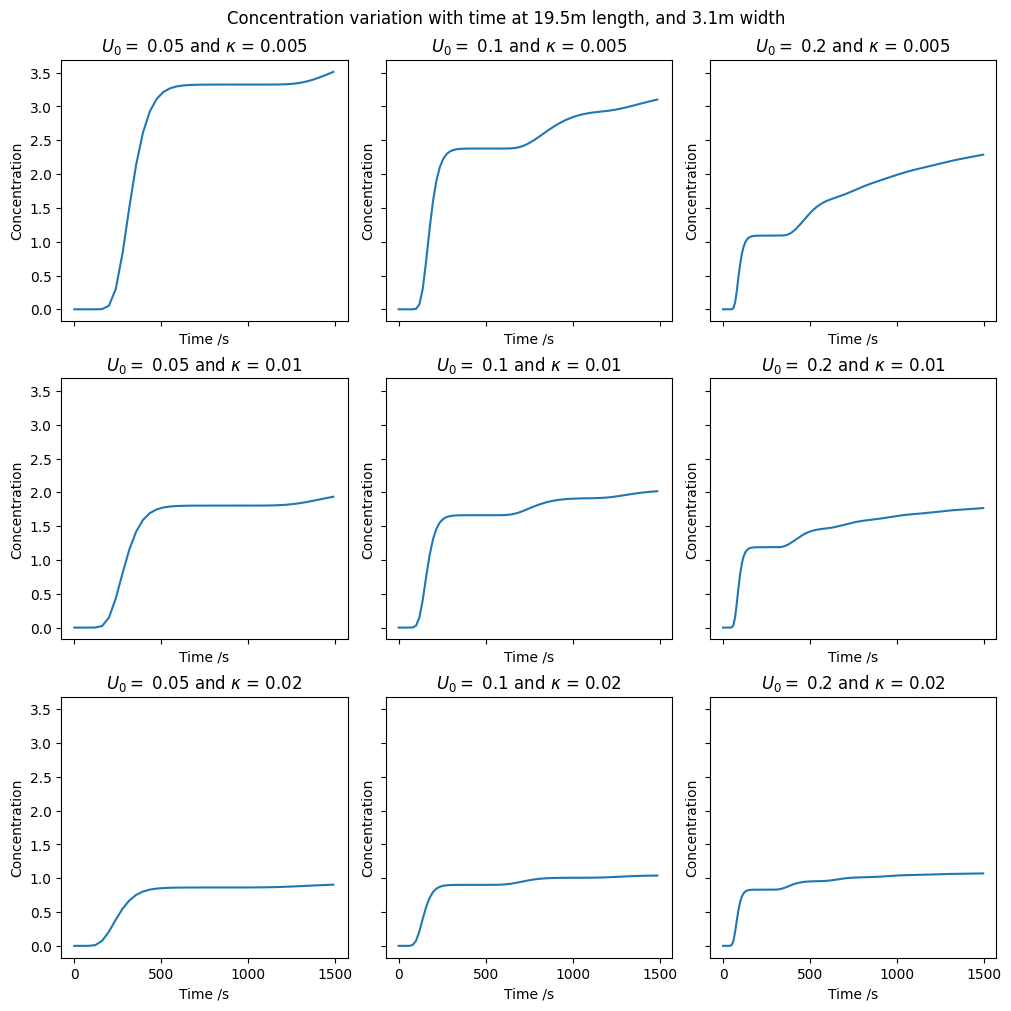

In [11]:
fig, axs = plt.subplots(nrows=3,ncols=3,figsize=(10,10),constrained_layout=True, sharex = True, sharey = True)
axs=axs.flatten()
# maximum flow speed is 0.1 and  κ  is 1e-2.

columns= [[0.05,0.5e-2],[0.1, 0.5e-2],[0.2,0.5e-2],[0.05,1e-2],[0.1, 1e-2],[0.2, 1e-2],[0.05,2e-2],[0.1, 2e-2],[0.2,2e-2]]

for i, ax in enumerate(axs):

    # Set parameters
    U0 = columns[i][0] # maximum current speed in m/s       - CHANGE THIS
    w = 10 # width of the river in m
    L = 50 # length of the river section to simulate
    kappa = columns[i][1] # diffusivity in m^2/s           - CHANGE THIS
    S0 = 1 # amplitude of the pollution source term
    S_w = 1 # width of the source term in m
    S_x = 10 # center of the forcing in x
    S_y = 0 # center of the forcing in y
    S_t = 1 # forcing timescale

    # Numerical parameters
    Nx = 256 # number of gridoints in x
    Ny = 32 # number of gridpoints in y
    stop_sim_time=1500 # end time in seconds
    timestep = (L/Nx)/U0 # timestep in seconds, calculated from the CFL number

    import numpy as np
    import dedalus.public as dedalus
    import logging
    logger = logging.getLogger(__name__)

    # Bases and coordinates
    coords = dedalus.CartesianCoordinates('x', 'y')
    dist = dedalus.Distributor(coords, dtype=np.float64)
    xbasis = dedalus.RealFourier(coords['x'], size=Nx, bounds=(0, L), dealias=3/2)
    ybasis = dedalus.ChebyshevT(coords['y'], size=Ny, bounds=(0, w), dealias=3/2)
    x, y = dist.local_grids(xbasis, ybasis)
    ex, ey = coords.unit_vector_fields(dist) # x and y unit vectors

    # Fields
    c = dist.Field(name='b', bases=(xbasis,ybasis))
    u = dist.Field(name='u', bases=(xbasis,ybasis))
    tau_1 = dist.Field(name='tau_1', bases=xbasis)
    tau_2 = dist.Field(name='tau_2', bases=xbasis)

    # Specify the velocity field
    u['g'] = U0 * (1- (y - w/2)**2.0/(w/2)**2.0) # parabolic velocity profile

    # Substitutions
    lift_basis = ybasis.derivative_basis(1)
    lift = lambda A: dedalus.Lift(A, lift_basis, -1)
    grad_c = dedalus.grad(c) + ey*lift(tau_1)
    dx = lambda A: dedalus.Differentiate(A, coords['x'])

    S = dist.Field(name='u', bases=(xbasis,ybasis))
    S['g'] = S0*np.exp(-(x-S_x)**2.0/S_w**2.0-(y-S_y)**2.0/S_w**2.0)

    # Problem
    problem = dedalus.IVP([c, tau_1, tau_2], namespace=locals())
    problem.add_equation("dt(c) + u*dx(c) - kappa*div(grad_c) + lift(tau_2) = S/S_t")
    problem.add_equation("c(y=0) = 0")
    problem.add_equation("c(y=w) = 0")

    # Now, set the solver
    solver = problem.build_solver(dedalus.RK222)
    solver.stop_sim_time = stop_sim_time

    # Create an array to periodically save the concentration field for plotting later
    c.change_scales(1)
    c_save = [np.copy(c['g'])];

    t_save = [solver.sim_time]; # Save the initial condition and the initial time
    # Main loop
    try:
        logger.info('Starting main loop')
        while solver.proceed:
            solver.step(timestep)
            if (solver.iteration-1) % 10 == 0:
                logger.info('Iteration=%i, Time=%e, dt=%e' %(solver.iteration, solver.sim_time, timestep))
                c.change_scales(1)
                c_save.append(np.copy(c['g']))
                t_save.append(solver.sim_time)
    except:
        logger.error('Exception raised, triggering end of main loop.')
        raise
    finally:
        solver.log_stats()

    # Convert the variables to numpy arrays for allow array slicing
    c_save = np.array(c_save)

    x_bit = 100
    y_bit = 10
    length_bit = x_bit/256 * L
    width_bit = y_bit/32 * w

    axs[i].plot(t_save, c_save[:,x_bit,y_bit])
    axs[i].set_xlabel('Time /s')
    axs[i].set_ylabel('Concentration')

    title = f'$U_0 =$ {columns[i][0]} and $\kappa$ = {columns[i][1]}'
    axs[i].set_title(title)

big_title = f'Concentration variation with time at {round(length_bit,1)}m length, and {round(width_bit,1)}m width'
plt.suptitle(big_title)



**My Answer - continued**

Dimensional analysis tells us that $t\approx L^2/\kappa \approx L/U_0$.

For $L=10$ (width), $\kappa = 0.01$, and $U_0 = 0.1$, the first option gives $t=10,000s$.

For $U_0 = 0.1$, a value of $t=10000s$ using the second equation gives $L=1000m$, where $L$ is how far downstream of the source this would occur.

This speaks to how rapid the river moves relative to rate of diffusion.

## 3. Optional further investigations

* In the river pollution example, you might notice that the concentration field is mixed more effectively in the x-direction than in the y-direction. The combination of differential advection by the currents and cross-stream diffusion is very effective at mixing the plume in the x-direction. This is an example of Taylor dispersion (Taylor, 1953). Construct numerical experiments to quantify Taylor dispersion and its dependence on the current shear and the diffusivity. You could also separate the diffusivity into parts in the x and y directions with different coefficients.  If you set the x-component of the diffusivity to zero, then any spreading of the concentration in the x-direction should be due to Taylor dispersion.

* Try making the river speed a function of time. The easiest way to do this is to add a new equation so that Dedalus solves for the velocity in addition to the concentration field. For example, you could make the river speed decrease exponentially in time, or it could be sinusoidal in time.

* In the ocean mixing example, if $\kappa$ is a function of $x$ and $z$, what would this imply about the velocity field? You could even try writing a Dedalus script to solve the 2D advection/diffusion equation with a prescribed spatially-dependent $\kappa(x,z)$.


### References

Munk, W.H., 1966. Abyssal recipes. In Deep sea research and oceanographic abstracts (Vol. 13, No. 4, pp. 707-730). Elsevier.

Ferrari, R., Mashayek, A., McDougall, T.J., Nikurashin, M. and Campin, J.M., 2016. Turning ocean mixing upside down. Journal of Physical Oceanography, 46(7), pp.2239-2261.

Taylor, G.I., 1953. Dispersion of soluble matter in solvent flowing slowly through a tube. Proceedings of the Royal Society of London. Series A. Mathematical and Physical Sciences, 219(1137), pp.186-203.